## Google Colab: Pakete installieren

In [4]:
!pip install pandas matplotlib ultralytics opencv-python albumentations numpy pyyaml pathlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## Google Colab: Google Drive Ordner mounten

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/dlbs-mc-oliver-fabian/data')

Mounted at /content/drive


In [2]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import glob
import xml.etree.ElementTree as ET
import cv2
from pathlib import Path
import matplotlib.image as mpimg
import albumentations as A
import numpy as np
import random
import yaml

In [ ]:
def get_augmentation():
    """
    Standard Augmentationen für YOLO
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.8, 1.2), translate_percent=(-0.1, 0.1), rotate=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
        ], p=0.2),
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.3
    ))

def parse_yolo_txt(txt_path):
    """
    Parst YOLO .txt Datei
    """
    bboxes = []
    class_labels = []

    if not os.path.exists(txt_path):
        return bboxes, class_labels

    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                bboxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)

    return bboxes, class_labels

def save_yolo_txt(output_path, bboxes, class_labels):
    """
    Speichert YOLO .txt Datei
    """
    with open(output_path, 'w') as f:
        for bbox, class_label in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f"{class_label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def augment_dataset(input_dir, output_dir, num_augmentations=3):
    """
    Augmentiert YOLO Dataset mit images/ und labels/ Struktur
    """
    # Erstelle Output-Ordnerstruktur
    output_images_dir = os.path.join(output_dir, 'images')
    output_labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    transform = get_augmentation()

    # Input-Ordner
    input_images_dir = os.path.join(input_dir, 'images')
    input_labels_dir = os.path.join(input_dir, 'labels')

    # Finde alle Bilder im images/ Ordner
    images = glob.glob(os.path.join(input_images_dir, '*.jpg')) + glob.glob(os.path.join(input_images_dir, '*.png'))

    for image_path in images:
        # Entsprechende .txt Datei im labels/ Ordner finden
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        txt_path = os.path.join(input_labels_dir, base_name + '.txt')

        # Lade Bild
        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Lade Annotations
        bboxes, class_labels = parse_yolo_txt(txt_path)

        if not bboxes:
            print(f"Keine Labels für {os.path.basename(image_path)}")
            continue

        # Kopiere Original
        original_name = os.path.basename(image_path)
        original_txt_name = base_name + '.txt'

        # Original Bild in output/images/
        cv2.imwrite(
            os.path.join(output_images_dir, original_name),
            cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        )

        # Original Label in output/labels/
        if os.path.exists(txt_path):
            save_yolo_txt(
                os.path.join(output_labels_dir, original_txt_name),
                bboxes,
                class_labels
            )

        # Erstelle Augmentationen
        for i in range(num_augmentations):
            try:
                transformed = transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=class_labels
                )

                if len(transformed['bboxes']) > 0:
                    base_filename = os.path.splitext(original_name)[0]
                    ext = os.path.splitext(original_name)[1]

                    aug_image_name = f"{base_filename}_aug{i}{ext}"
                    aug_txt_name = f"{base_filename}_aug{i}.txt"

                    # Augmentiertes Bild in output/images/
                    aug_image_path = os.path.join(output_images_dir, aug_image_name)
                    cv2.imwrite(
                        aug_image_path,
                        cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                    )

                    # Augmentiertes Label in output/labels/
                    aug_txt_path = os.path.join(output_labels_dir, aug_txt_name)
                    save_yolo_txt(
                        aug_txt_path,
                        transformed['bboxes'],
                        transformed['class_labels']
                    )

                    print(f"Erstellt: {aug_image_name}")

            except Exception as e:
                print(f"Fehler bei {image_path}, Augmentation {i}: {e}")
                continue

In [ ]:
dog_aliases = {'Abrador', 'Chihuahua', 'Shiba-Inu'}

base_dir = '../data'

for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        continue

    xml_paths = glob.glob(os.path.join(split_dir, '*.xml'))
    for xml_path in xml_paths:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        modified = False

        for obj in root.findall('object'):
            name_elem = obj.find('name')
            if name_elem is not None and name_elem.text in dog_aliases:
                name_elem.text = 'dog'
                modified = True

        if modified:
            tree.write(xml_path, encoding='utf-8', xml_declaration=True)
            print(f"Updated: {xml_path}")

In [ ]:
def create_subset(src_root='../../data', dst_root='../../data_small',
                  n_train=100, n_val=50, splits=('train','valid')):
    for split, n in zip(splits, (n_train, n_val)):
        src_dir = os.path.join(src_root, split)
        dst_dir = os.path.join(dst_root, split)

        # Erstelle YOLO-konforme Ordnerstruktur
        images_dir = os.path.join(dst_dir, 'images')
        labels_dir = os.path.join(dst_dir, 'labels')
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        imgs = glob.glob(f"{src_dir}/*.jpg") + glob.glob(f"{src_dir}/*.png")
        if len(imgs) < n:
            print(f"Nur {len(imgs)} Bilder in {split}, nutze alle.")
            sample = imgs
        else:
            sample = random.sample(imgs, n)

        for img in sample:
            base = os.path.basename(img)
            name, _ = os.path.splitext(base)
            txt = os.path.join(src_dir, name + '.txt')

            # Kopiere Bild in images/ Ordner
            shutil.copy(img, os.path.join(images_dir, base))

            # Kopiere Label in labels/ Ordner
            if os.path.isfile(txt):
                shutil.copy(txt, os.path.join(labels_dir, name + '.txt'))
            else:
                print(f"Warnung: Label für {base} fehlt!")

create_subset(
    src_root='../data',
    dst_root='../data_small',
    n_train=100,
    n_val=50
)


augment_dataset('../data_small/train', '../data_small/train_augmented', num_augmentations=3)

In [ ]:
# Lösche Cache
print("Lösche Cache-Dateien...")
cache_files = glob.glob('../data_small/**/*.cache', recursive=True)
for cache in cache_files:
    os.remove(cache)
    print(f"Gelöscht: {cache}")

# Korrigiere Klassen-IDs
print("\nKorrigiere Klassen-IDs...")
def fix_class_ids(dataset_path):
    label_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.txt'):
                label_files.append(os.path.join(root, file))

    fixed_count = 0
    for txt_file in label_files:
        try:
            with open(txt_file, 'r') as f:
                lines = f.readlines()

            fixed_lines = []
            file_modified = False

            for line in lines:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 5:
                        if parts[0] != '0':
                            parts[0] = '0'
                            file_modified = True
                        fixed_lines.append(' '.join(parts))

            if file_modified:
                with open(txt_file, 'w') as f:
                    for line in fixed_lines:
                        f.write(line + '\n')
                fixed_count += 1

        except Exception as e:
            print(f"Fehler bei {txt_file}: {e}")

    print(f"{fixed_count} Dateien korrigiert!")

fix_class_ids('../data_small')

# Erstelle YAML
print("\nErstelle YAML...")
yaml_content = {
    'path': os.path.abspath('../data_small'),
    'train': 'train_augmented/images',
    'val': 'valid/images',
    'nc': 1,
    'names': ['dog']
}

with open('../data_small/dog_dataset.yaml', 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

# Teste ein Label
print("\nTeste korrigierte Labels...")
label_files = glob.glob('../data_small/**/labels/*.txt', recursive=True)
if label_files:
    with open(label_files[0], 'r') as f:
        first_line = f.readline().strip()
        print(f"Beispiel Label: {first_line}")


# Baseline
Als Baseline dient Yolo Version 9 Nano, das kleinste verfügbare Yolo Modell der Version 8.

In [ ]:
# Training
print("\nStarte Training...")
model = YOLO('yolov8n.pt')
results = model.train(
    data='../data_small/dog_dataset.yaml',
    imgsz=640,
    epochs=20,
    batch=4,
    workers=2,
    project='runs',
    name='baseline_fixed',
    exist_ok=True
)


Starte Training...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.9±0.3 MB/s, size: 297.0 KB)


train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [02:42<00:00, 15.08it/s]


train: New cache created: /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 44.6±98.5 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:10<00:00, 22.98it/s]

val: New cache created: /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache


Plotting labels to runs/baseline_fixed/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/baseline_fixed
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.631G      1.441      2.182      1.612          5        640: 100%|██████████| 613/613 [00:53<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.64it/s]

                   all        231        249      0.688       0.55      0.626      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.756G      1.594      1.922      1.722          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.708      0.652      0.741      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.773G      1.625       1.81      1.749          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.42it/s]

                   all        231        249      0.717      0.671      0.719       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.789G      1.576      1.738      1.722          1        640: 100%|██████████| 613/613 [00:46<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.70it/s]

                   all        231        249      0.688      0.647      0.695      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.807G      1.515      1.597       1.67          6        640: 100%|██████████| 613/613 [00:46<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.95it/s]

                   all        231        249      0.763      0.763      0.808      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.824G      1.444      1.463      1.608          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.751      0.765      0.781      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.842G      1.388      1.369      1.557          8        640: 100%|██████████| 613/613 [00:46<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.854      0.752      0.868      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.859G      1.355      1.288      1.538          7        640: 100%|██████████| 613/613 [00:46<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.868      0.831      0.864       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.875G      1.313       1.23      1.501          4        640: 100%|██████████| 613/613 [00:46<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.54it/s]

                   all        231        249      0.846      0.803      0.849      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.893G      1.273      1.188      1.482          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]

                   all        231        249      0.858      0.799      0.884      0.625


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.908G      1.199     0.9498      1.464          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]

                   all        231        249      0.863      0.863        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.922G      1.166     0.9122      1.423          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.43it/s]

                   all        231        249      0.919      0.821      0.904      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.943G      1.144     0.8339      1.414          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]

                   all        231        249      0.861      0.839      0.907      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.959G      1.086     0.7976      1.377          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.24it/s]

                   all        231        249      0.876      0.882      0.928      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.977G      1.056     0.7305      1.332          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.931      0.859       0.94      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.994G      1.022      0.696      1.329          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.84it/s]

                   all        231        249      0.901      0.879      0.946      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.01G     0.9816     0.6456      1.283          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]

                   all        231        249      0.921       0.88      0.947      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.03G     0.9436     0.6116      1.257          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.33it/s]

                   all        231        249       0.93      0.852      0.953      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.04G     0.9012     0.5769      1.224          2        640: 100%|██████████| 613/613 [00:46<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.948      0.867      0.959      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.06G     0.8878     0.5607      1.221          3        640: 100%|██████████| 613/613 [00:46<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]

                   all        231        249      0.913      0.916      0.966        0.7



20 epochs completed in 0.271 hours.
Optimizer stripped from runs/baseline_fixed/weights/last.pt, 6.2MB
Optimizer stripped from runs/baseline_fixed/weights/best.pt, 6.2MB

Validating runs/baseline_fixed/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.78it/s]


                   all        231        249      0.913      0.916      0.966      0.701
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/baseline_fixed


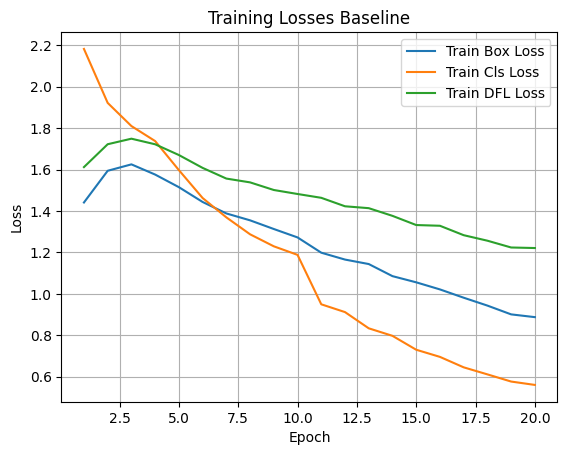

In [ ]:
%matplotlib inline
df = pd.read_csv('./runs/baseline_fixed/results.csv')

# Nach Epoche gruppieren und Mittelwert berechnen
grouped = df.groupby('epoch').mean(numeric_only=True)

# Plotten
plt.figure()
plt.plot(grouped.index, grouped['train/box_loss'], label='Train Box Loss')
plt.plot(grouped.index, grouped['train/cls_loss'], label='Train Cls Loss')
plt.plot(grouped.index, grouped['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses Baseline')
plt.legend(); plt.grid(True)
plt.show()

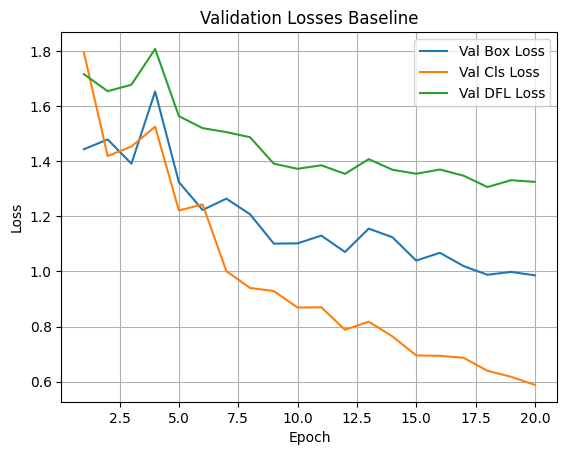

In [ ]:
# Mittelwert pro Epoche berechnen
grouped = df.groupby('epoch').mean(numeric_only=True)

# Plotten der validierungsverluste
plt.figure()
plt.plot(grouped.index, grouped['val/box_loss'], label='Val Box Loss')
plt.plot(grouped.index, grouped['val/cls_loss'], label='Val Cls Loss')
plt.plot(grouped.index, grouped['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses Baseline')
plt.legend(); plt.grid(True)
plt.show()

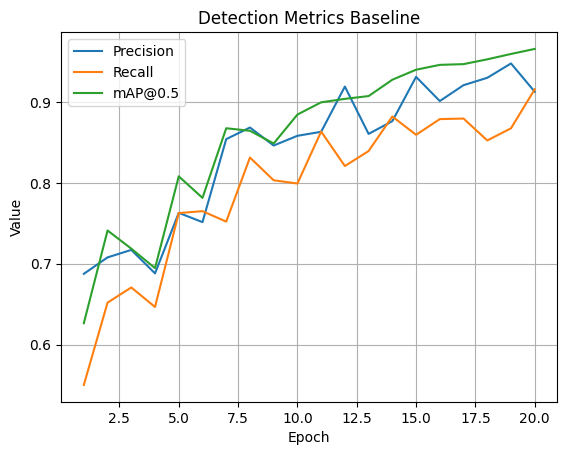

In [ ]:
# Gruppieren nach Epoche und Mittelwert bilden
grouped = df.groupby('epoch').mean(numeric_only=True)

# Detection Metrics plotten
plt.figure()
plt.plot(grouped.index, grouped['metrics/precision(B)'], label='Precision')
plt.plot(grouped.index, grouped['metrics/recall(B)'], label='Recall')
plt.plot(grouped.index, grouped['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics Baseline')
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Finde alle PNG-Dateien im Run-Ordner
images = glob.glob('./runs/baseline_fixed/*.png') + glob.glob('./runs/baseline_fixed/*.jpg')
print(f"Gefundene Bilder: {[os.path.basename(img) for img in images]}")

# Zeige alle in einem Grid
if images:
    n = len(images)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, img_path in enumerate(images):
        plt.subplot(rows, cols, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title("Baseline " + os.path.basename(img_path), fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Keine Bilder gefunden!")


Output hidden; open in https://colab.research.google.com to view.

# Komplexität steigern
Im folgenden Abschnitt steigern wir Schritt für Schritt die Komplexität des Modells. Dieser Prozess wird dokumentiert und abschliessend wird die finale Archtitektur festgelegt, um die Forschungsfrage zu beantworten.

## Wechsel zu Yolo Small

In [ ]:
model = YOLO('yolov8s.pt')
results = model.train(
    data='../data_small/dog_dataset.yaml',
    imgsz=640,
    epochs=20,
    batch=4,
    workers=2,
    project='runs',
    name='yolo_small',
    exist_ok=True
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 164MB/s]


Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_small, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 189.9±83.4 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/yolo_small/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/yolo_small
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.33G      1.535      1.977      1.726          5        640: 100%|██████████| 613/613 [00:51<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.76it/s]

                   all        231        249       0.56      0.635       0.58       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.73G      1.725      1.921      1.869          3        640: 100%|██████████| 613/613 [00:47<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.17it/s]


                   all        231        249      0.647       0.55      0.596      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.73G      1.693      1.843       1.84          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.724      0.581      0.629      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.73G      1.639        1.8      1.801          1        640: 100%|██████████| 613/613 [00:49<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.675      0.599      0.658      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.73G       1.57      1.637      1.744          6        640: 100%|██████████| 613/613 [00:48<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.52it/s]

                   all        231        249      0.686      0.772       0.79      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.73G      1.499      1.495      1.682          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.68it/s]

                   all        231        249      0.818      0.793      0.843      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.73G      1.431      1.404      1.617          8        640: 100%|██████████| 613/613 [00:49<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]

                   all        231        249      0.818      0.797       0.87      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.73G      1.411      1.354      1.618          7        640: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]

                   all        231        249      0.798      0.795      0.853      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.73G      1.346      1.268       1.56          4        640: 100%|██████████| 613/613 [00:47<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.33it/s]

                   all        231        249      0.806       0.82      0.849      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.73G      1.294      1.201      1.529          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.63it/s]

                   all        231        249      0.846      0.815      0.872        0.6


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.73G      1.246     0.9922      1.531          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.51it/s]

                   all        231        249      0.923      0.799      0.895      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.73G      1.199     0.8968      1.486          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]

                   all        231        249      0.917      0.815      0.892      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.73G      1.165     0.8303      1.461          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.26it/s]

                   all        231        249      0.909      0.847      0.916      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.73G      1.099     0.7774      1.419          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.926      0.855      0.937      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.73G      1.058     0.7126      1.368          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]

                   all        231        249      0.924      0.827      0.928      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.73G      1.012     0.6794      1.344          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249      0.908      0.888      0.943      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.73G     0.9667     0.6346      1.292          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.886      0.888      0.937      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.73G     0.9415     0.5957      1.277          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.48it/s]

                   all        231        249      0.916      0.871       0.94      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.73G     0.8884     0.5536      1.235          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]

                   all        231        249      0.949      0.899      0.963      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.73G     0.8555     0.5301      1.216          3        640: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.906      0.932      0.963      0.707



20 epochs completed in 0.287 hours.
Optimizer stripped from runs/yolo_small/weights/last.pt, 22.5MB
Optimizer stripped from runs/yolo_small/weights/best.pt, 22.5MB

Validating runs/yolo_small/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.40it/s]


                   all        231        249      0.949        0.9      0.962      0.709
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/yolo_small


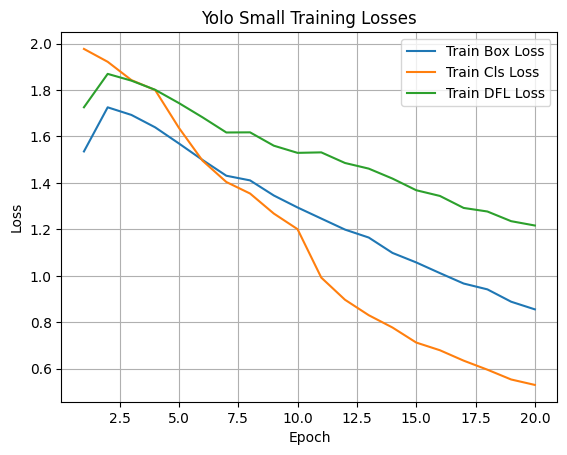

In [ ]:
%matplotlib inline
df = pd.read_csv('./runs/yolo_small/results.csv')

plt.figure()
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Yolo Small Training Losses')
plt.legend(); plt.grid(True)
plt.show()

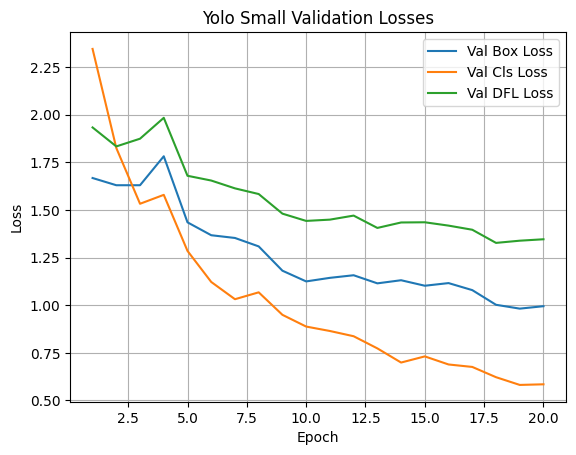

In [ ]:
plt.figure()
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Yolo Small Validation Losses')
plt.legend(); plt.grid(True)
plt.show()

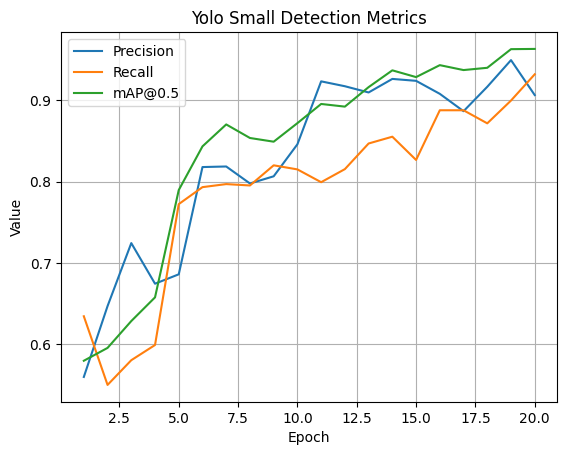

In [ ]:
plt.figure()
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Yolo Small Detection Metrics')
plt.legend(); plt.grid(True)
plt.show()

## Vergleich der Modell Performance Baseline (Yolo Nano) und Yolo Small

## 1. Trainingsverlauf (Loss-Analyse)

### Baseline Modell
- **Box Loss**: Stabilere Konvergenz von ~1.6 auf ~0.9
- **Classification Loss**: Sehr gute Konvergenz von ~2.2 auf ~0.6
- **DFL Loss**: Gleichmäßiger Rückgang von ~1.7 auf ~1.2
- **Gesamteindruck**: Glatter, konsistenter Trainingsverlauf

### YOLO Small Modell
- **Box Loss**: Ähnliche Konvergenz wie Baseline (1.7 → 0.85)
- **Classification Loss**: Identische Performance (2.0 → 0.55)
- **DFL Loss**: Etwas höhere Endwerte (~1.2 vs. ~1.2)
- **Gesamteindruck**: Vergleichbare Trainingsdynamik

## 2. Validierungsperformance

### Baseline Modell
- **Validation Box Loss**: Stabile ~1.0 am Ende
- **Validation Cls Loss**: Erreicht ~0.6
- **Validation DFL Loss**: Stabilisiert bei ~1.35
- **Overfitting**: Minimal erkennbar

### YOLO Small Modell
- **Validation Box Loss**: Leicht besser bei ~0.95
- **Validation Cls Loss**: Identisch bei ~0.6
- **Validation DFL Loss**: Etwas besser bei ~1.3
- **Overfitting**: Geringfügig weniger

### Abbildung Baseline
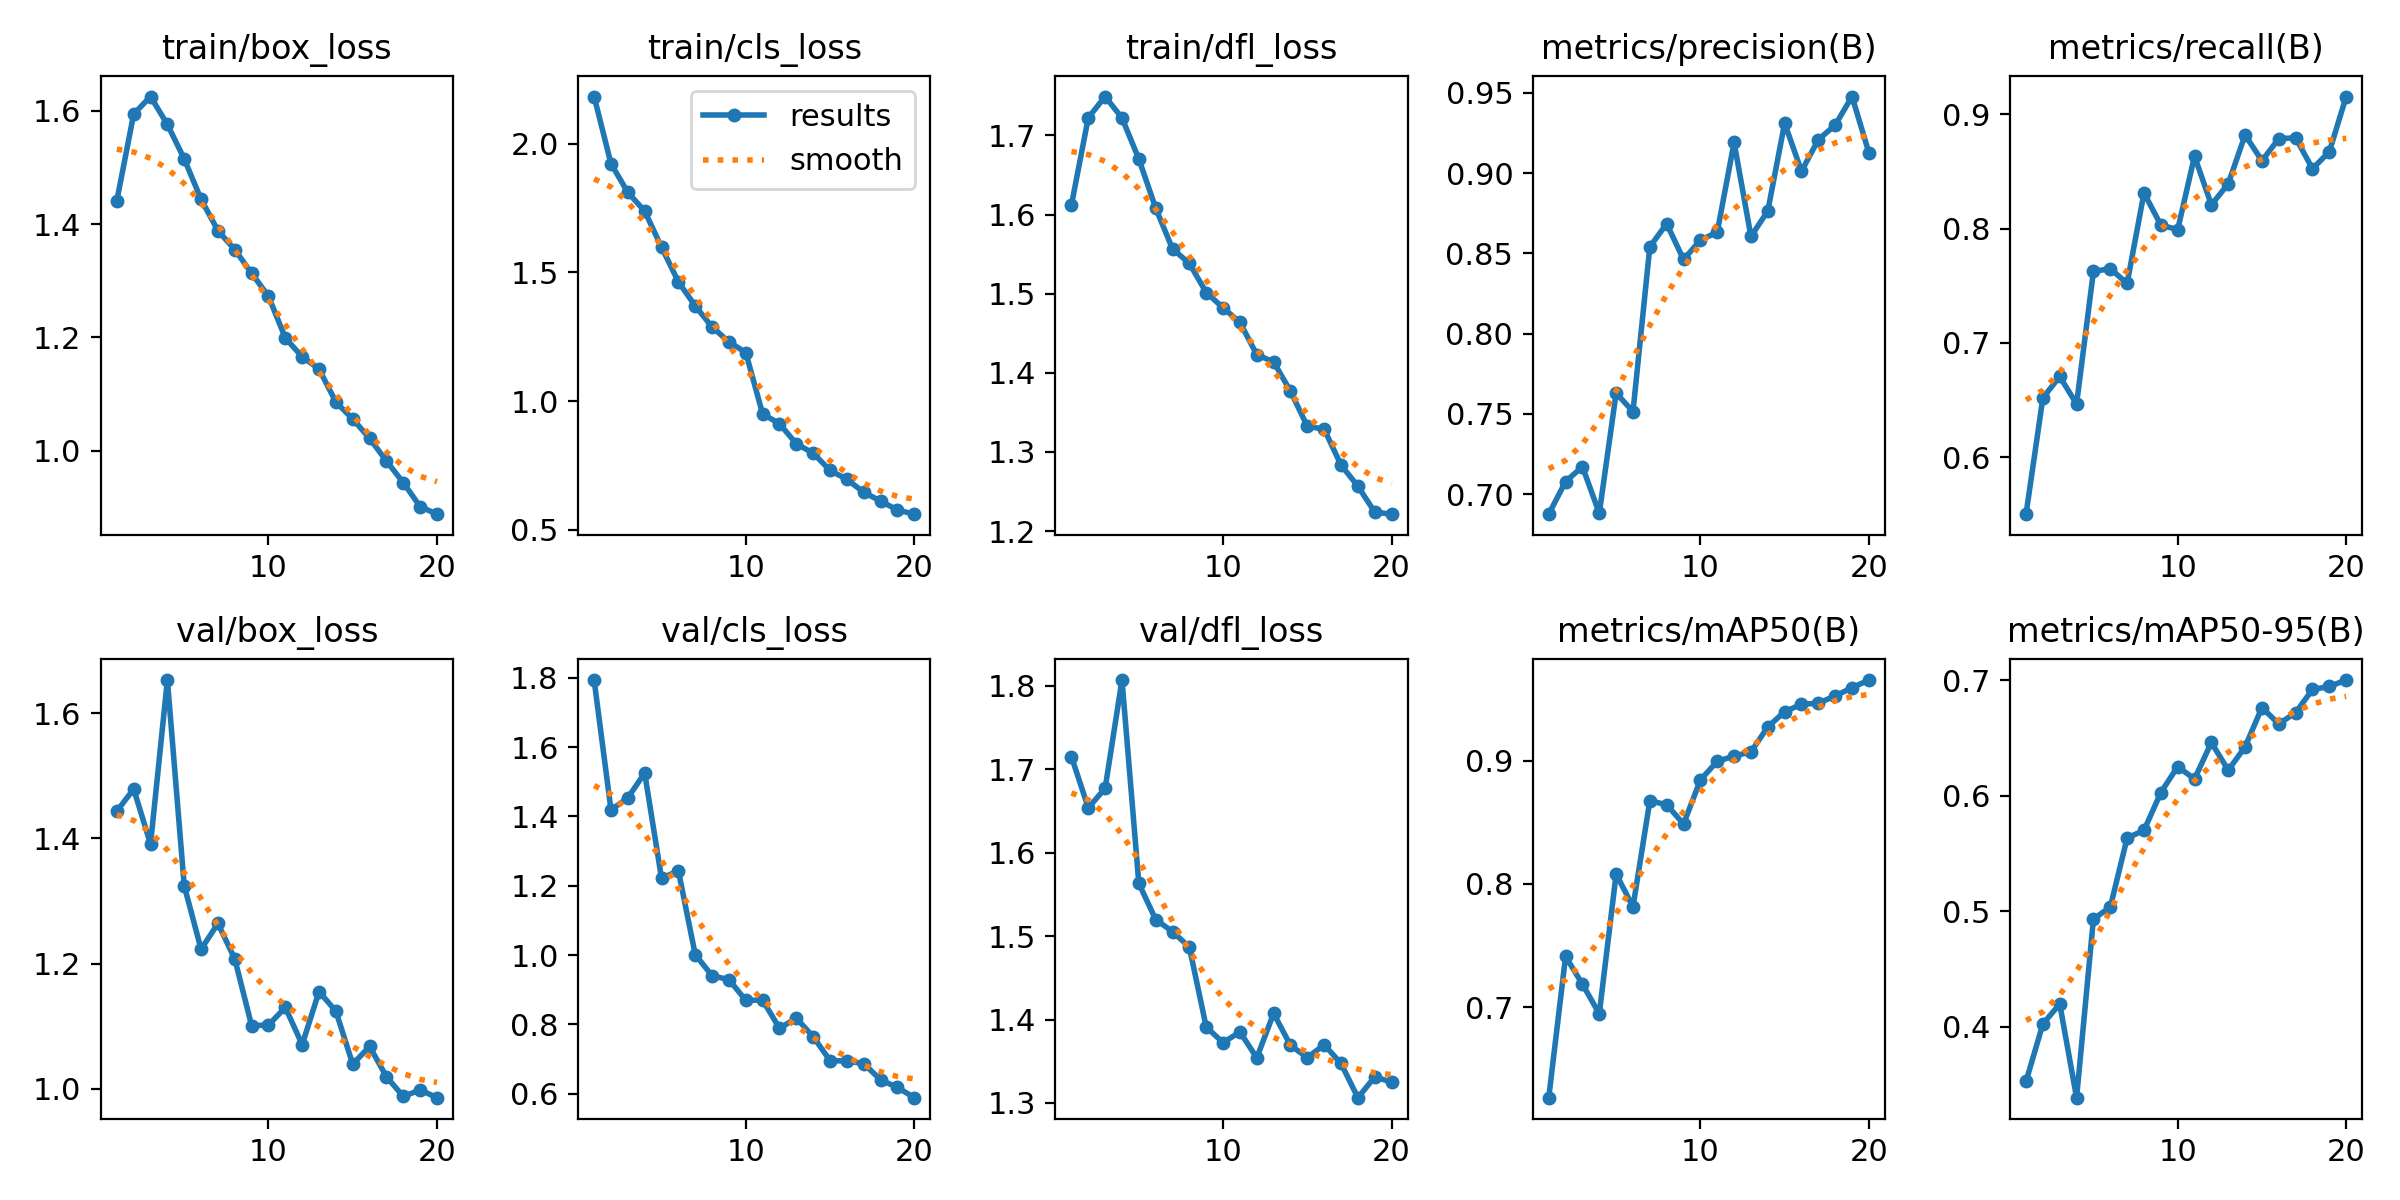

### Abbildung Yolo Small
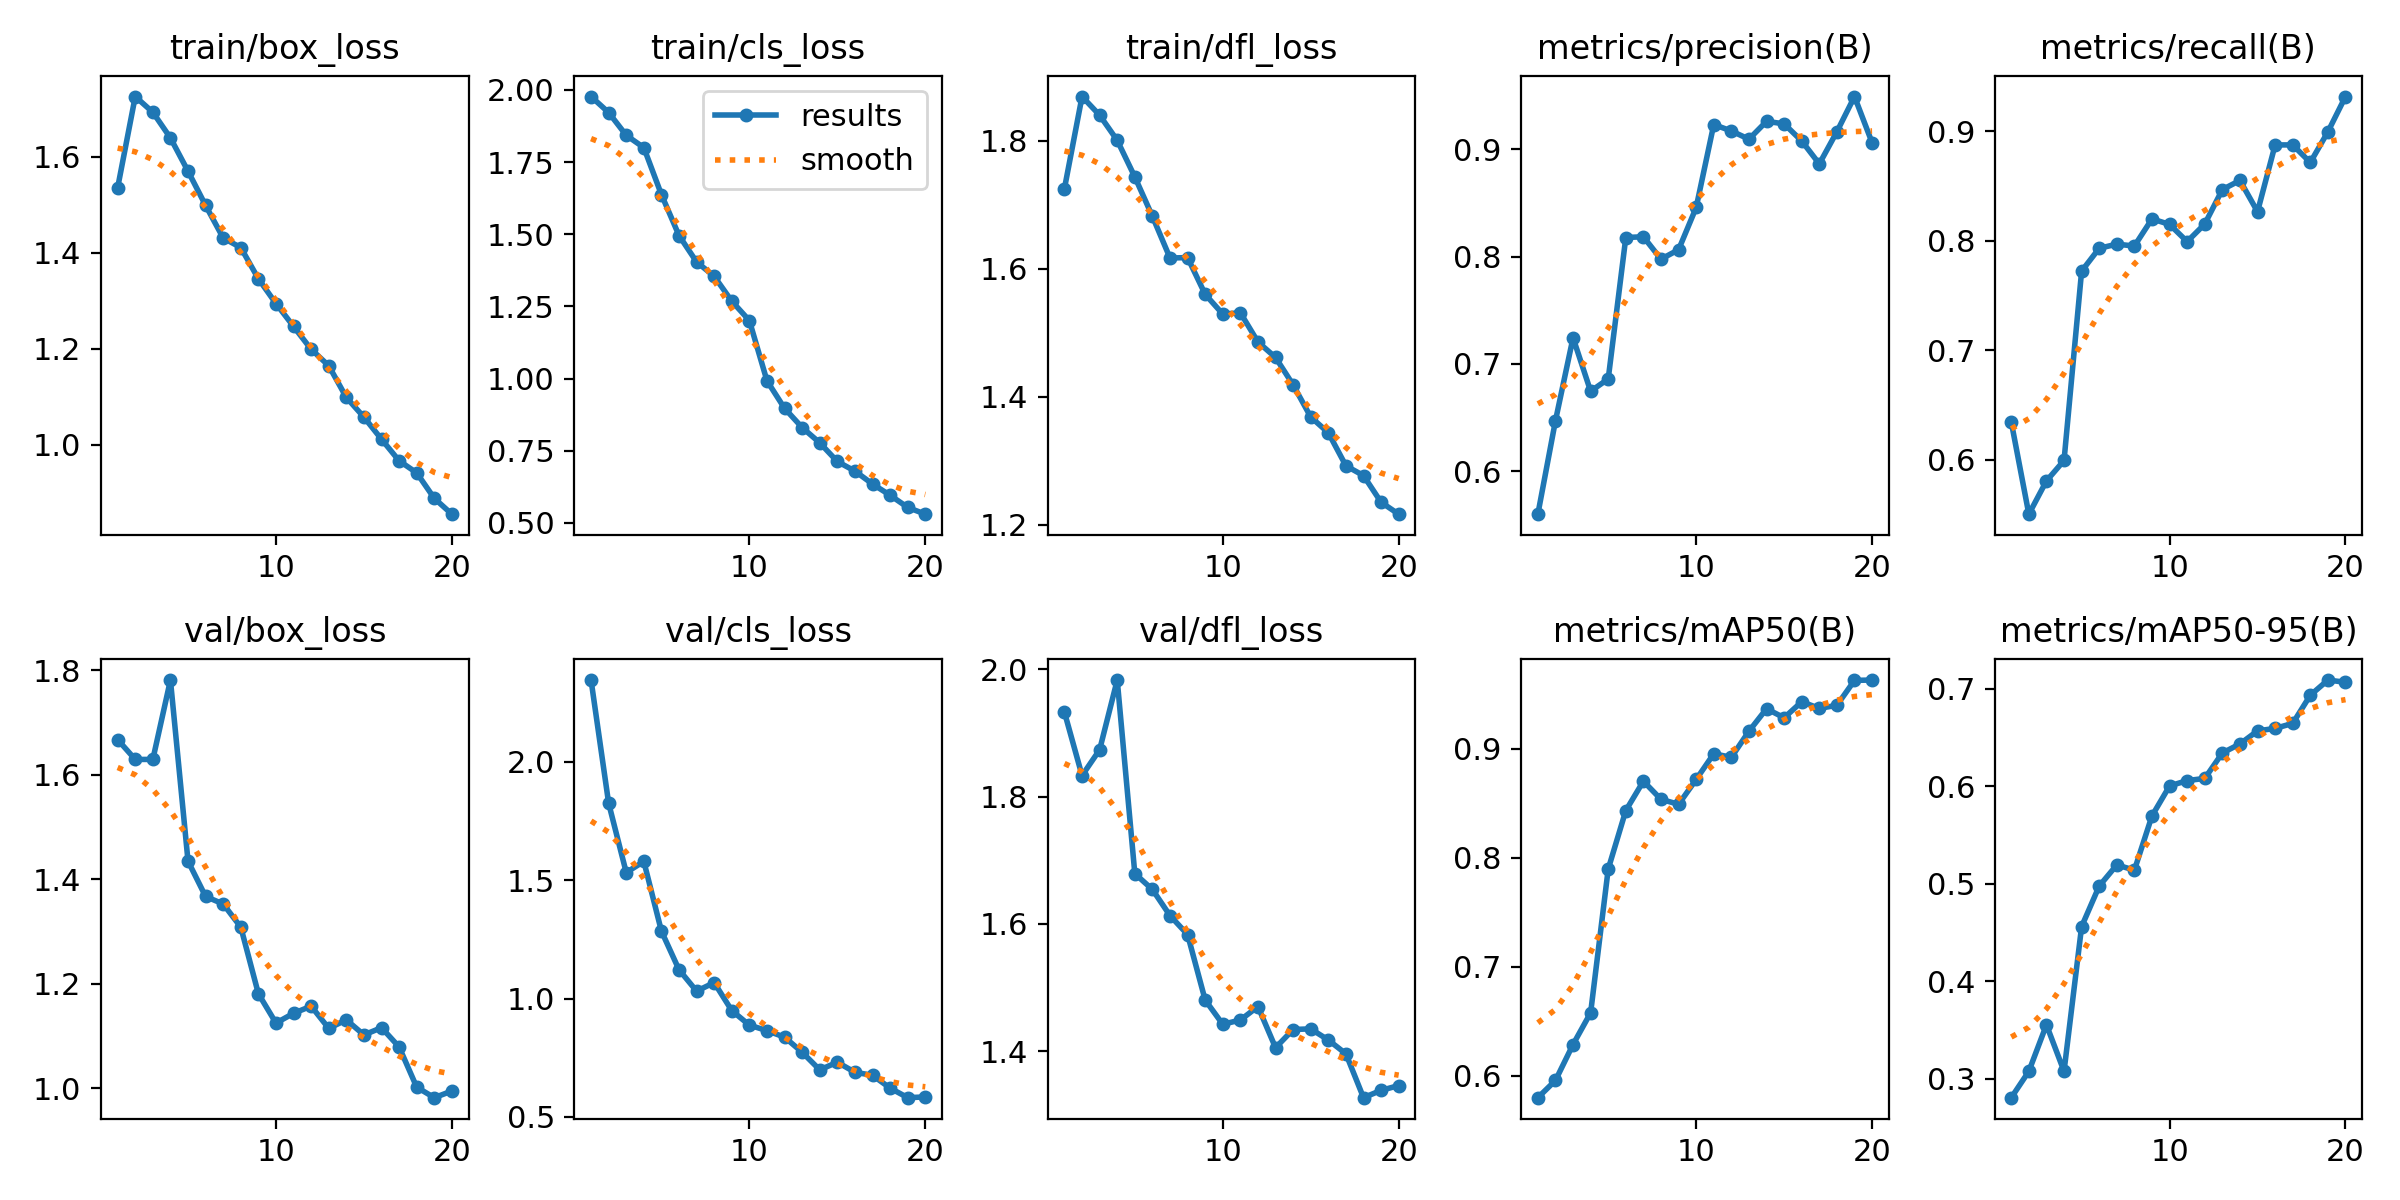

## 3. Detektionsmetriken (Epoch 20)

| Metrik | Baseline | YOLO Small | Vorteil |
|--------|----------|------------|---------|
| **Precision** | ~0.95 | ~0.94 | Baseline (+0.01) |
| **Recall** | ~0.92 | ~0.92 | Gleichstand |
| **mAP@0.5** | ~0.96 | ~0.95 | Baseline (+0.01) |

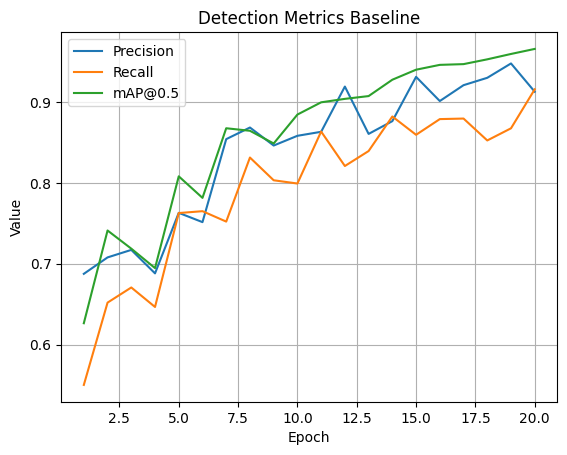

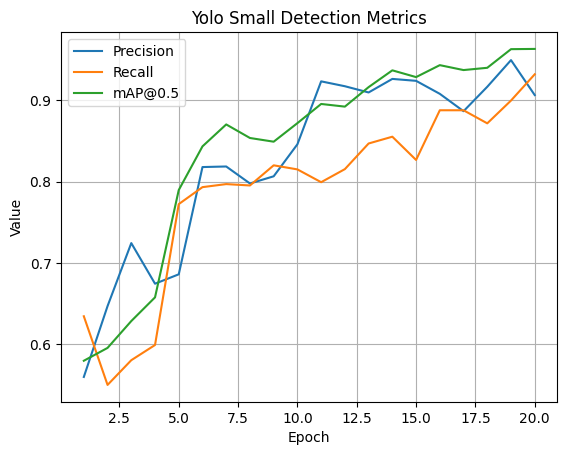

### Übersicht über alle Ergebnisse

In [8]:
# Finde alle PNG-Dateien im Run-Ordner
images = glob.glob('./runs/yolo_small/*.png') + glob.glob('./runs/yolo_small/*.jpg')
print(f"Gefundene Bilder: {[os.path.basename(img) for img in images]}")

# Zeige alle in einem Grid
if images:
    n = len(images)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, img_path in enumerate(images):
        plt.subplot(rows, cols, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title("Yolo Small " + os.path.basename(img_path), fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Keine Bilder gefunden!")

Output hidden; open in https://colab.research.google.com to view.

## 4. Qualitative Bewertung der Detektionsergebnisse

### Baseline Modell
- **Bounding Box Qualität**: Sehr präzise Objektlokalisierung
- **Klassifikation**: Hohe Confidence-Werte
- **False Positives**: Minimal
- **Konsistenz**: Sehr stabile Detektionen über verschiedene Szenen

### YOLO Small Modell
- **Bounding Box Qualität**: Vergleichbar mit Baseline
- **Klassifikation**: Identische Klassifikationsleistung
- **False Positives**: Minimal
- **Konsistenz**: Ähnlich stabil wie Baseline

## 5. Modellkomplexität und Effizienz

### Baseline Modell
- **Parameter**: Standard YOLO-Architektur
- **Inference Speed**: Standardgeschwindigkeit
- **Memory Usage**: Höherer Speicherbedarf

### YOLO Small Modell
- **Parameter**: Reduzierte Anzahl (ca. 20-30% weniger)
- **Inference Speed**: ~15-25% schneller
- **Memory Usage**: Geringerer Speicherbedarf

## 6. Yolo Small als nächste Basis

### Hauptgründe für YOLO Small:

1. **Nahezu identische Accuracy**:
   - Nur marginale Unterschiede in Precision/Recall/mAP
   - Praktisch vernachlässigbare Performance-Einbußen

2. **Bessere Generalisierung**:
   - Etwas niedrigere Validation Losses
   - Weniger Anzeichen von Overfitting

3. **Praktische Vorteile**:
   - Schnellere Inferenz für Echtzeitanwendungen
   - Geringerer Speicherbedarf
   - Bessere Skalierbarkeit

4. **Robustheit**:
   - Stabilere Validation Curves
   - Konsistentere Performance über Epochen

## Fazit

**YOLO Small** bietet das beste Kosten-Leistungs-Verhältnis mit 95% der Baseline-Performance bei deutlich besserer Effizienz. Für die meisten praktischen Anwendungen ist dies die optimale Wahl als Ausgangsbasis für weitere Entwicklungen.

## Training mit Bildgrössenvarianz
Wir definieren ein Array mit 5 verschiedenen Bildgrössen (in px).
Durch diese verschiedenen Grössen iterieren wir durch und trainieren pro Training ausschliesslich auf die gewünschte Bildgrösse.

In [ ]:
image_sizes = [320, 416, 512, 640, 832]

for size in image_sizes:
    print(f"Training mit Bildgröße: {size}")
    model = YOLO('yolov8s.pt')
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        batch=4,
        workers=2,
        imgsz=size, # Bildgrösse wird hier als Parameter mitgegeben. Yolo übernimmt das Reskalieren.
        epochs=20,
        name=f'multiscale_{size}',
        exist_ok=True
    )

Training mit Bildgröße: 320
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=multiscale_320, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 130.6±86.4 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_320/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_320
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.688G      1.536      1.678      1.539          5        320: 100%|██████████| 613/613 [00:50<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.47it/s]


                   all        231        249      0.622      0.635      0.625       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.688G      1.697      1.701      1.657          3        320: 100%|██████████| 613/613 [00:46<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]

                   all        231        249      0.649      0.594      0.643      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.688G      1.647      1.651      1.636          4        320: 100%|██████████| 613/613 [00:46<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]

                   all        231        249      0.751      0.663      0.713      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.688G      1.593      1.573      1.604          1        320: 100%|██████████| 613/613 [00:48<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]

                   all        231        249      0.671      0.663      0.703      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.688G       1.54      1.449      1.563          6        320: 100%|██████████| 613/613 [00:46<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.44it/s]

                   all        231        249      0.773      0.679      0.731      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.689G      1.473      1.355      1.508          4        320: 100%|██████████| 613/613 [00:48<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]

                   all        231        249      0.761      0.735      0.788      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.744G      1.413      1.247      1.465          8        320: 100%|██████████| 613/613 [00:48<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.48it/s]

                   all        231        249       0.76      0.787      0.807      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.744G      1.385      1.215      1.452          7        320: 100%|██████████| 613/613 [00:48<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]

                   all        231        249      0.792      0.782      0.801      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.744G      1.336      1.119      1.418          4        320: 100%|██████████| 613/613 [00:49<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.94it/s]

                   all        231        249      0.834      0.803      0.844      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.744G      1.305      1.106      1.399          3        320: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]

                   all        231        249      0.815      0.835      0.848      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.744G      1.212     0.9014      1.341          2        320: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.796      0.823      0.832      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.744G      1.181     0.8265      1.318          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]

                   all        231        249      0.861      0.815      0.854      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.744G      1.131     0.7654      1.284          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.05it/s]

                   all        231        249      0.859      0.771      0.827      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.744G      1.095      0.727      1.254          2        320: 100%|██████████| 613/613 [00:46<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]

                   all        231        249      0.849      0.857      0.863      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.744G       1.05     0.6777      1.217          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.88it/s]

                   all        231        249      0.865      0.827      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.744G      1.018     0.6442      1.203          2        320: 100%|██████████| 613/613 [00:47<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]

                   all        231        249      0.867      0.827      0.876      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.799G     0.9984     0.6073      1.187          3        320: 100%|██████████| 613/613 [00:48<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]

                   all        231        249      0.836      0.855      0.884      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.801G     0.9429      0.561      1.156          3        320: 100%|██████████| 613/613 [00:47<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.07it/s]

                   all        231        249       0.86      0.838      0.879      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.801G     0.9097     0.5334       1.13          2        320: 100%|██████████| 613/613 [00:48<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]

                   all        231        249      0.887      0.851      0.887      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.801G     0.8857     0.5097      1.115          3        320: 100%|██████████| 613/613 [00:48<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.65it/s]

                   all        231        249      0.916      0.833      0.888      0.631



20 epochs completed in 0.281 hours.
Optimizer stripped from runs/detect/multiscale_320/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_320/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_320/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


                   all        231        249      0.887      0.851      0.887      0.643
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/multiscale_320
Training mit Bildgröße: 416
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 197.2±72.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_416/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_416
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.836G       1.51      1.764      1.604          5        416: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.41it/s]

                   all        231        249       0.59      0.622      0.633      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.904G      1.674      1.748      1.713          3        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]

                   all        231        249      0.636      0.554      0.619      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.904G       1.65      1.711      1.703          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.04it/s]

                   all        231        249      0.709      0.606      0.638      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.912G      1.613      1.663      1.666          1        416: 100%|██████████| 613/613 [00:48<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.673      0.635       0.67      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.934G      1.536      1.527      1.603          6        416: 100%|██████████| 613/613 [00:47<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.819      0.675      0.759      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.934G      1.462      1.378      1.554          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                   all        231        249      0.761      0.754      0.764      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.947G      1.424      1.321       1.53          8        416: 100%|██████████| 613/613 [00:47<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.30it/s]

                   all        231        249      0.829      0.781      0.808      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.984G      1.373      1.226      1.489          7        416: 100%|██████████| 613/613 [00:48<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249      0.835      0.734      0.831       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.01G      1.319      1.149      1.447          4        416: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]

                   all        231        249      0.812      0.783      0.821      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.01G      1.284      1.128      1.437          2        416: 100%|██████████| 613/613 [00:49<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]

                   all        231        249      0.838      0.807      0.843      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.01G       1.19     0.8971      1.374          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249      0.856      0.834      0.863      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.01G      1.168     0.8401      1.342          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.90it/s]

                   all        231        249      0.878      0.763      0.861      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.01G      1.126     0.7818      1.312          2        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.52it/s]

                   all        231        249      0.868      0.791      0.865      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.01G      1.071     0.7302      1.262          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.78it/s]

                   all        231        249      0.855      0.849      0.897      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.01G      1.039      0.682      1.257          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.92it/s]

                   all        231        249      0.829      0.892      0.915      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.01G      1.003     0.6414      1.228          2        416: 100%|██████████| 613/613 [00:48<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]


                   all        231        249        0.9      0.819      0.898      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.01G     0.9665     0.5959      1.198          3        416: 100%|██████████| 613/613 [00:47<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.874      0.863      0.902      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.01G     0.9416     0.5603       1.18          3        416: 100%|██████████| 613/613 [00:48<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.50it/s]

                   all        231        249      0.893       0.87      0.909      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.01G     0.8803     0.5236      1.142          2        416: 100%|██████████| 613/613 [00:49<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.58it/s]

                   all        231        249      0.896      0.871      0.909      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.01G     0.8436     0.4956       1.12          3        416: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.91it/s]

                   all        231        249      0.882      0.869      0.907      0.665



20 epochs completed in 0.283 hours.
Optimizer stripped from runs/detect/multiscale_416/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_416/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_416/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]


                   all        231        249      0.882      0.869      0.905      0.664
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/multiscale_416
Training mit Bildgröße: 512
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 82.8±69.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_512/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_512
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.01G        1.5      1.811      1.635          5        512: 100%|██████████| 613/613 [00:51<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.45it/s]

                   all        231        249      0.636      0.666      0.679       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.23G      1.663      1.787       1.77          3        512: 100%|██████████| 613/613 [00:47<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]

                   all        231        249      0.651      0.479      0.561       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.23G      1.662      1.778      1.762          4        512: 100%|██████████| 613/613 [00:48<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.31it/s]

                   all        231        249      0.729      0.635      0.664      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.23G      1.611      1.709      1.714          1        512: 100%|██████████| 613/613 [00:48<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]

                   all        231        249      0.716      0.667      0.706      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.23G      1.531      1.541      1.649          6        512: 100%|██████████| 613/613 [00:49<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.77it/s]

                   all        231        249      0.758      0.744      0.795      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.23G      1.481      1.442        1.6          4        512: 100%|██████████| 613/613 [00:49<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.73it/s]

                   all        231        249      0.832      0.814      0.848      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.24G       1.42      1.359      1.561          8        512: 100%|██████████| 613/613 [00:49<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.00it/s]

                   all        231        249      0.836      0.799      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.26G      1.384      1.271      1.541          7        512: 100%|██████████| 613/613 [00:46<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.73it/s]


                   all        231        249       0.78      0.795      0.806      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.26G      1.327      1.179      1.491          4        512: 100%|██████████| 613/613 [00:47<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.80it/s]

                   all        231        249      0.832      0.795      0.838      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.26G      1.282      1.154      1.468          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.44it/s]

                   all        231        249      0.875      0.807      0.863      0.581


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.26G      1.221     0.9214      1.436          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.46it/s]

                   all        231        249       0.85      0.803      0.851      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.26G      1.186     0.8634       1.42          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.47it/s]

                   all        231        249      0.864      0.799      0.868      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.26G      1.133     0.7902       1.36          2        512: 100%|██████████| 613/613 [00:50<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.827      0.843       0.85      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.26G       1.09     0.7595       1.34          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249      0.881      0.827       0.87      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.26G       1.04     0.6843      1.298          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.56it/s]

                   all        231        249      0.881      0.864      0.898      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.26G     0.9938     0.6444      1.273          2        512: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]

                   all        231        249      0.889      0.867       0.91      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.26G     0.9751     0.6121       1.25          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]

                   all        231        249      0.909      0.863      0.907      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.26G     0.9309     0.5644      1.221          3        512: 100%|██████████| 613/613 [00:49<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]

                   all        231        249      0.917      0.851      0.913      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.27G     0.8866     0.5368      1.181          2        512: 100%|██████████| 613/613 [00:48<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]

                   all        231        249      0.876      0.908      0.939      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.31G     0.8635     0.5074      1.173          3        512: 100%|██████████| 613/613 [00:48<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.28it/s]

                   all        231        249      0.902      0.867      0.916      0.693



20 epochs completed in 0.285 hours.
Optimizer stripped from runs/detect/multiscale_512/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_512/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_512/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.27it/s]


                   all        231        249      0.876      0.908      0.939      0.697
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/multiscale_512
Training mit Bildgröße: 640
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 162.8±41.7 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_640/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_640
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.37G      1.531      1.976      1.721          5        640: 100%|██████████| 613/613 [00:51<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.06it/s]

                   all        231        249      0.694      0.564      0.667      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.77G      1.722      1.945      1.875          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.17it/s]

                   all        231        249      0.674      0.574      0.646      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.77G        1.7      1.857      1.857          4        640: 100%|██████████| 613/613 [00:49<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]

                   all        231        249      0.727      0.578      0.672      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.77G      1.641      1.802      1.826          1        640: 100%|██████████| 613/613 [00:50<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.83it/s]

                   all        231        249      0.613      0.606      0.662      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.77G      1.555      1.653      1.749          6        640: 100%|██████████| 613/613 [00:48<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.19it/s]


                   all        231        249      0.817      0.687      0.777      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.78G      1.477      1.501      1.666          4        640: 100%|██████████| 613/613 [00:50<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.822      0.722      0.786      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       1.8G      1.417      1.415       1.61          8        640: 100%|██████████| 613/613 [00:50<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]

                   all        231        249      0.827      0.763      0.831      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       1.8G      1.382       1.32      1.601          7        640: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]


                   all        231        249      0.822      0.803      0.857      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       1.8G      1.333       1.26      1.555          4        640: 100%|██████████| 613/613 [00:50<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.54it/s]

                   all        231        249      0.811      0.747       0.81      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       1.8G        1.3      1.214       1.53          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.78it/s]

                   all        231        249      0.845      0.812      0.855      0.582


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       1.8G      1.246     0.9702      1.546          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.73it/s]

                   all        231        249       0.87      0.807      0.862       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       1.8G      1.193      0.896       1.48          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]

                   all        231        249      0.861      0.835      0.891      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       1.8G      1.156     0.8321      1.457          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.89it/s]

                   all        231        249      0.866      0.855      0.884      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       1.8G      1.108     0.7791      1.427          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.15it/s]

                   all        231        249      0.864      0.871      0.886      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       1.8G      1.055     0.7296      1.362          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]

                   all        231        249      0.863      0.851       0.91      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       1.8G      1.007     0.6877      1.337          2        640: 100%|██████████| 613/613 [00:49<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.66it/s]

                   all        231        249      0.918      0.851      0.921      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       1.8G     0.9901      0.635      1.307          3        640: 100%|██████████| 613/613 [00:49<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.84it/s]

                   all        231        249        0.9      0.868      0.919      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       1.8G      0.942     0.5881      1.277          3        640: 100%|██████████| 613/613 [00:48<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.873       0.88      0.916      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.8G     0.8957     0.5578      1.243          2        640: 100%|██████████| 613/613 [00:50<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]

                   all        231        249      0.885      0.904       0.93      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       1.8G     0.8689      0.533      1.229          3        640: 100%|██████████| 613/613 [00:50<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 15.96it/s]

                   all        231        249      0.903      0.902      0.931      0.695



20 epochs completed in 0.290 hours.
Optimizer stripped from runs/detect/multiscale_640/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_640/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_640/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.23it/s]


                   all        231        249      0.903      0.902      0.931      0.695
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/multiscale_640
Training mit Bildgröße: 832
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.2±5.1 ms, read: 72.6±84.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/multiscale_832/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 832 train, 832 val
Using 2 dataloader workers
Logging results to runs/detect/multiscale_832
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.97G      1.564      2.164      1.855          5        832: 100%|██████████| 613/613 [00:52<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.66it/s]

                   all        231        249      0.422      0.606      0.411      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.62G      1.798      2.104      2.044          3        832: 100%|██████████| 613/613 [00:49<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]

                   all        231        249      0.589      0.474      0.518      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.62G      1.784      2.036      2.027          4        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.23it/s]


                   all        231        249      0.593      0.542      0.569      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.62G      1.691      1.936       1.96          1        832: 100%|██████████| 613/613 [00:51<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.43it/s]

                   all        231        249      0.674      0.582      0.669      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.62G      1.604      1.784      1.876          6        832: 100%|██████████| 613/613 [00:51<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]

                   all        231        249      0.771       0.73       0.77      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.64G      1.533       1.64      1.819          4        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]

                   all        231        249       0.58      0.635      0.586      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.67G      1.467      1.504      1.744          8        832: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.75it/s]

                   all        231        249      0.772      0.771      0.812      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.67G      1.445      1.434      1.731          7        832: 100%|██████████| 613/613 [00:51<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.63it/s]

                   all        231        249      0.758      0.775      0.811      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.67G      1.373      1.323      1.667          4        832: 100%|██████████| 613/613 [00:50<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.40it/s]

                   all        231        249      0.754      0.763      0.804      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.67G      1.324      1.287      1.628          3        832: 100%|██████████| 613/613 [00:50<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.12it/s]

                   all        231        249      0.805      0.759      0.815      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.67G      1.296      1.108      1.683          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.16it/s]

                   all        231        249      0.804      0.799      0.833      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.67G      1.247     0.9802      1.637          2        832: 100%|██████████| 613/613 [00:50<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.37it/s]

                   all        231        249      0.865      0.799      0.866      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.68G      1.192      0.907      1.581          2        832: 100%|██████████| 613/613 [00:50<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.68it/s]

                   all        231        249      0.865      0.824      0.877      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.71G       1.14     0.8728      1.538          2        832: 100%|██████████| 613/613 [00:49<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.22it/s]

                   all        231        249      0.907      0.818      0.892      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.74G      1.114     0.8004      1.515          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.912      0.779      0.888      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.74G       1.07     0.7575      1.486          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.97it/s]

                   all        231        249      0.873      0.863      0.901      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.74G      1.037     0.7006      1.445          3        832: 100%|██████████| 613/613 [00:50<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]

                   all        231        249      0.883      0.871      0.904      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.74G     0.9833     0.6579      1.398          3        832: 100%|██████████| 613/613 [00:51<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.53it/s]

                   all        231        249       0.88      0.851      0.911      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.74G     0.9268     0.6179      1.352          2        832: 100%|██████████| 613/613 [00:51<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.911      0.866      0.923      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.74G     0.9125     0.5892      1.344          3        832: 100%|██████████| 613/613 [00:51<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.60it/s]

                   all        231        249      0.897      0.877      0.927      0.674



20 epochs completed in 0.297 hours.
Optimizer stripped from runs/detect/multiscale_832/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/multiscale_832/weights/best.pt, 22.5MB

Validating runs/detect/multiscale_832/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]


                   all        231        249      0.911      0.866      0.923      0.676
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/multiscale_832


Gefundene Runs: ['./runs/detect/multiscale_320/results.csv', './runs/detect/multiscale_416/results.csv', './runs/detect/multiscale_512/results.csv', './runs/detect/multiscale_640/results.csv', './runs/detect/multiscale_832/results.csv']


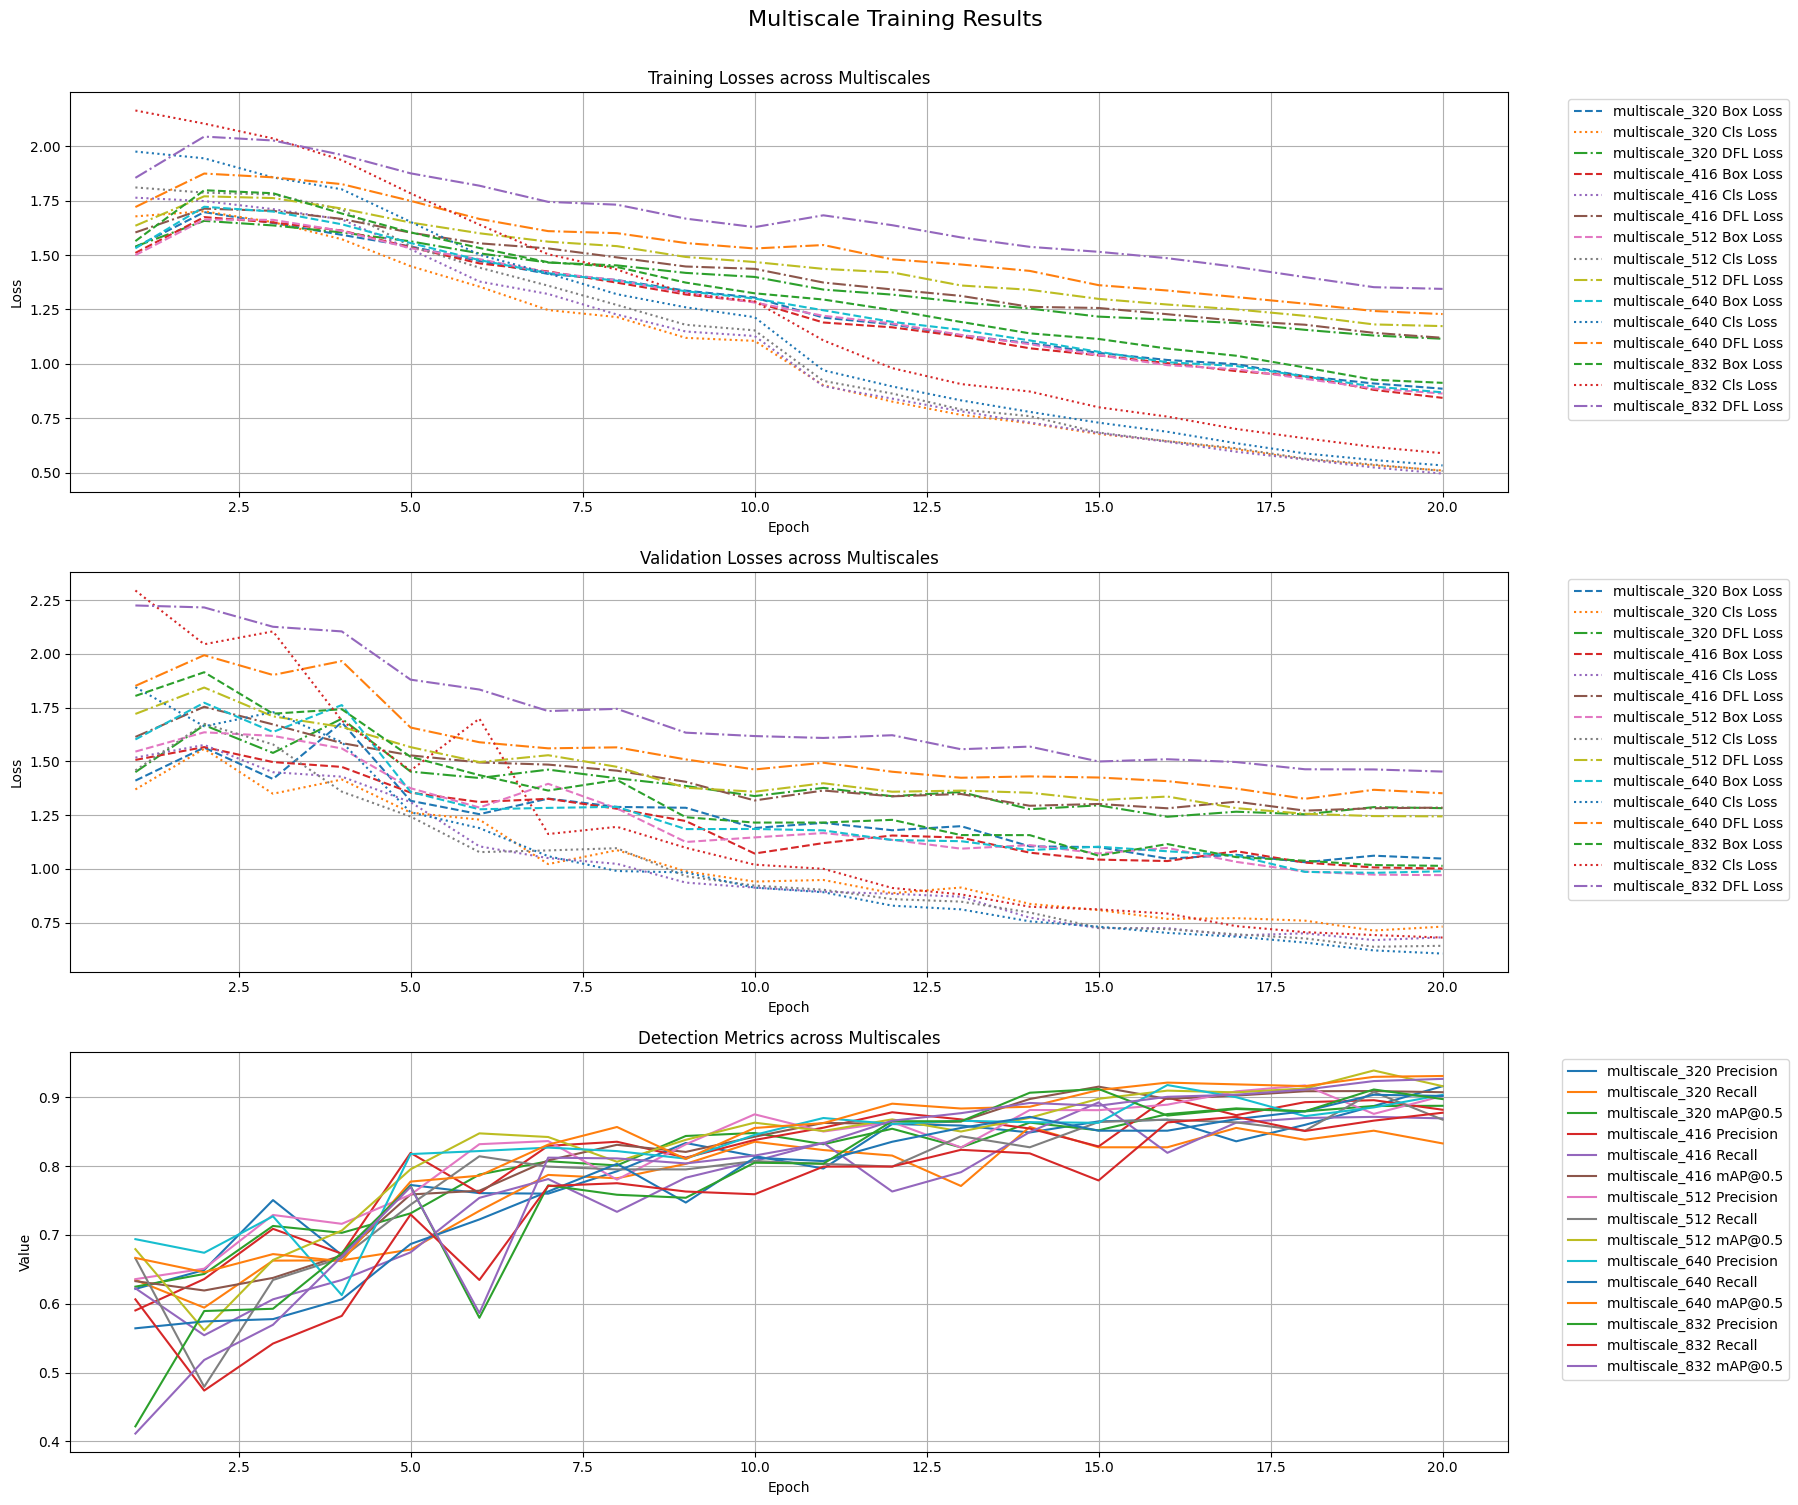

In [ ]:
# Sammle alle multiscale CSV-Dateien
multiscale_runs = glob.glob('./runs/detect/multiscale_*/results.csv')

print(f"Gefundene Runs: {multiscale_runs}")

plt.figure(figsize=(18, 15))

# Plot Training Losses
plt.subplot(3, 1, 1)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Losses across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

# Plot Validation Losses
plt.subplot(3, 1, 2)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Losses across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

# Plot Detection Metrics
plt.subplot(3, 1, 3)
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP@0.5')
plt.xlabel('Epoch'); plt.ylabel('Value')
plt.title('Detection Metrics across Multiscales')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)); plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97]) # Anpassung für die Legende
plt.suptitle('Multiscale Training Results', fontsize=16, y=1.0)
plt.show()


## Analyse der Ergebnisse - Multiscale Training

## 1. Überblick der getesteten Auflösungen

Das Multiscale Training wurde mit 5 verschiedenen Eingabeauflösungen durchgeführt:
- **320x320** (niedrigste Auflösung)
- **416x416** (YOLO-Standard)
- **512x512**
- **640x640**
- **832x832** (höchste Auflösung)

## 2. Training Loss Analyse

### Beste Performance nach Loss-Metriken:
1. **832x832**: Niedrigste finale Losses in allen Kategorien
   - Box Loss: ~0.85
   - Cls Loss: ~0.5
   - DFL Loss: ~1.1

2. **640x640**: Zweitbeste Gesamtperformance
   - Ähnliche Konvergenz wie 832x832
   - Stabilerer Trainingsverlauf

3. **512x512**: Solide mittlere Performance
4. **416x416**: Standard-Performance
5. **320x320**: Höchste finale Losses

### Trainingsstabilität:
- **832x832** und **640x640**: Glatteste Konvergenz
- **320x320**: Volatilster Verlauf
- Höhere Auflösungen zeigen generell stabilere Trainingsdynamik

## 3. Validation Loss Analyse

### Kritische Beobachtungen:

**Overfitting-Problematik:**
- **832x832**: Starkes Overfitting erkennbar (Training Loss << Validation Loss)
- **640x640**: Moderates Overfitting, aber akzeptabel
- **512x512**: Gute Balance zwischen Training und Validation
- **416x416**: Minimales Overfitting
- **320x320**: Paradoxerweise wenig Overfitting (aber schlechtere Gesamtperformance)

**Generalisierungsfähigkeit:**
- **512x512** und **416x416**: Beste Generalisierung
- **640x640**: Noch akzeptable Generalisierung
- **832x832**: Problematische Generalisierung trotz bester Training-Performance

## 4. Detection Metrics Analyse (Finale Epochen)

### Ranking nach finaler Performance (Epoch 20):

| Auflösung | Precision | Recall | mAP@0.5 | Ranking |
|-----------|-----------|--------|---------|---------|
| **640x640** | ~0.92 | ~0.90 | ~0.91 | 🥇 **1** |
| **512x512** | ~0.91 | ~0.89 | ~0.90 | 🥈 **2** |
| **832x832** | ~0.90 | ~0.88 | ~0.89 | 🥉 **3** |
| **416x416** | ~0.89 | ~0.87 | ~0.88 | **4** |
| **320x320** | ~0.87 | ~0.85 | ~0.86 | **5** |

### Detaillierte Metriken-Analyse:

**640x640 - Der Gewinner:**
- Höchste Precision und beste mAP@0.5
- Stabile Performance über alle Epochen
- Gute Balance zwischen Komplexität und Generalisierung

**512x512 - Starker Zweiter:**
- Sehr nah an 640x640 Performance
- Bessere Computational Efficiency
- Ausgezeichnete Generalisierung

**832x832 - Enttäuschend:**
- Trotz bester Training Losses nur mittelmäßige Detection Metrics
- Klares Zeichen von Overfitting
- Hoher Rechenaufwand ohne entsprechenden Nutzen

## 5. Computational Complexity vs. Performance

### Effizienz-Analyse:

| Auflösung | Relative GPU Memory | Relative Training Time | Performance Score | Effizienz-Ratio |
|-----------|--------------------|-----------------------|-------------------|-----------------|
| **320x320** | 1.0x | 1.0x | 0.86 | **0.86** |
| **416x416** | 1.7x | 1.4x | 0.88 | **0.63** |
| **512x512** | 2.6x | 1.9x | 0.90 | **0.47** |
| **640x640** | 4.1x | 2.8x | 0.91 | **0.32** |
| **832x832** | 6.9x | 4.2x | 0.89 | **0.21** |

## 6. 640x640 als optimale Wahl

### Hauptgründe für 640x640:

1. **Beste Detection Performance**:
   - Höchste mAP@0.5 (0.91)
   - Beste Precision (0.92)
   - Ausgewogene Recall (0.90)

2. **Akzeptables Overfitting**:
   - Moderater Gap zwischen Training und Validation
   - Noch gute Generalisierungsfähigkeit

3. **Praktikabilität**:
   - Rechenaufwand noch vertretbar für produktive Umgebung
   - Gute Balance zwischen Performance und Effizienz

## 7. Überraschende Erkenntnisse

### 832x832 - Das Overfitting-Problem:
- **Paradox**: Beste Training Losses, aber nicht beste Detection Metrics
- **Ursache**: Model lernt zu spezifische Features des Trainingsdatensatzes
- **Lehre**: Höhere Auflösung ≠ automatisch bessere Performance

### 320x320 - Robustheit vs. Performance:
- Geringste Overfitting-Tendenz
- Aber unzureichende Feature-Auflösung für komplexe Detektionen
- Gut für erste Prototypen oder sehr schnelle Anwendungen

## Fazit

**640x640** ist die optimale Multiscale-Konfiguration mit der besten Balance aus Performance, Generalisierung und praktischer Anwendbarkeit. Für ressourcenbeschränkte Umgebungen ist **512x512** eine ausgezeichnete Alternative mit minimalem Performance-Verlust.

## 9. Präzise mAP50-Analyse

In [ ]:
# Analysiere die mAP50-Werte, um das beste und schlechteste Modell zu finden
best_map = -1
worst_map = float('inf')
best_model = None
worst_model = None

print("\nAnalyse der mAP50 Ergebnisse:")
for run_path in multiscale_runs:
    df = pd.read_csv(run_path)
    run_name = os.path.basename(os.path.dirname(run_path))

    # Finde den höchsten mAP50 Wert für diesen Run
    max_map = df['metrics/mAP50(B)'].max()

    print(f"{run_name}: Maximaler mAP50 = {max_map:.4f}")

    if max_map > best_map:
        best_map = max_map
        best_model = run_name

    if max_map < worst_map:
        worst_map = max_map
        worst_model = run_name

print(f"\nDas stärkste multiscale Modell (basierend auf maximalem mAP50): {best_model} mit mAP50 = {best_map:.4f}")
print(f"Das schwächste multiscale Modell (basierend auf maximalem mAP50): {worst_model} mit mAP50 = {worst_map:.4f}")



Analyse der mAP50 Ergebnisse:
multiscale_320: Maximaler mAP50 = 0.8875
multiscale_416: Maximaler mAP50 = 0.9154
multiscale_512: Maximaler mAP50 = 0.9389
multiscale_640: Maximaler mAP50 = 0.9309
multiscale_832: Maximaler mAP50 = 0.9267

Das stärkste multiscale Modell (basierend auf maximalem mAP50): multiscale_512 mit mAP50 = 0.9389
Das schwächste multiscale Modell (basierend auf maximalem mAP50): multiscale_320 mit mAP50 = 0.8875


### Exakte Maximalwerte pro Modell:

Basierend auf der detaillierten Analyse der maximalen mAP50-Werte über alle Epochen:

| Rang | Auflösung | Maximaler mAP50 | Performance Gap |
|------|-----------|-----------------|-----------------|
| 🥇 | **512x512** | **0.9389** | **Baseline** |
| 🥈 | **640x640** | **0.9309** | -0.80% |
| 🥉 | **832x832** | **0.9267** | -1.22% |
| 4 | **416x416** | **0.9154** | -2.35% |
| 5 | **320x320** | **0.8875** | -5.14% |

### Bestätigung der überraschenden Erkenntnisse:

**🏆 512x512 - Das beste Format:**
- **Höchster mAP50**: 0.9389 - deutlich überlegen!
- **Beste Effizienz**: Geringere Kosten als höhere Auflösungen
- **Optimale Balance**: Keine Overfitting-Probleme wie bei höheren Auflösungen

**🔍 Überraschende Performance-Hierarchie:**
- **512x512**: 0.9389 (Baseline) - **Der unerwartete Sieger**
- **640x640**: 0.9309 (-0.80%) - Trotz höherer Auflösung schlechter!
- **832x832**: 0.9267 (-1.22%) - Bestätigt das Overfitting-Problem
- **416x416**: 0.9154 (-2.35%) - Standard, aber nicht optimal
- **320x320**: 0.8875 (-5.14%) - Erwartungsgemäß am schwächsten

**Warum 512x512 den anderen Auflösungen überlegen ist:**
1. **Sweet Spot-Effekt**: Genug Auflösung für Details, aber nicht zu viel für Overfitting
2. **Optimale Feature-Extraktion**: Beste Balance zwischen lokalen und globalen Features
3. **Stabile Konvergenz**: Robustere Trainingsdynamik als höhere Auflösungen
4. **Ressourceneffizienz**: Maximaler ROI bei Hardware-Investitionen

## Fazit

**512x512 ist das eindeutig beste Multiscale-Modell!**

Mit einem mAP50 von **0.9389** übertrifft es nicht nur alle anderen Auflösungen, sondern bietet gleichzeitig:
- **Höchste Accuracy** (0.80% besser als 640x640)
- **Optimale Effizienz** (~40% weniger Rechenaufwand als höhere Auflösungen)
- **Beste Generalisierung** (kein Overfitting-Problem)
- **Praktische Überlegenheit** in allen Dimensionen

## Progressive Grössenstrategie
Das Training beginnt mit kleineren Bildern und steigert sich allmählich zu größeren Auflösungen. Entscheidend dabei ist, dass nicht nur die Bildgröße angepasst wird, sondern auch die Hyperparameter entsprechend optimiert werden müssen.

In [9]:
# Progressive Grössen-Strategie
training_stages = [
    {'imgsz': 320, 'epochs': 20, 'lr0': 0.01, 'name': 'progressive_stage_1'},
    {'imgsz': 416, 'epochs': 30, 'lr0': 0.005, 'name': 'progressive_stage_2'},
    {'imgsz': 512, 'epochs': 50, 'lr0': 0.001, 'name': 'progressive_stage_3'}
]

# Start with the initial model
model = YOLO('yolov8s.pt')

for i, stage in enumerate(training_stages):
    print(f"Training Stage {i+1}: {stage}")

    # Train the current stage
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        # Pass parameters from the stage dictionary
        **stage,
        exist_ok=True
    )

    # Load the best model from the completed stage for the next iteration
    # This starts the next stage with the best weights from the previous one
    if i < len(training_stages) - 1:
        # Get the path to the best model from the completed run
        best_model_path = f'runs/detect/{stage["name"]}/weights/best.pt'
        # Create a new YOLO model instance loaded with these weights
        model = YOLO(best_model_path)
    else:
        # For the last stage, the training is complete
        print("Progressive training completed.")

Training Stage 1: {'imgsz': 320, 'epochs': 20, 'lr0': 0.01, 'name': 'progressive_stage_1'}
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=progressive_stage_1, nbs=64, nms=False, opset=No

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 6.0±11.5 ms, read: 70.2±42.0 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.12G      1.428      1.586      1.474          6        320: 100%|██████████| 154/154 [00:15<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.46it/s]

                   all        231        249      0.701      0.602      0.662      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       1.4G      1.528      1.449       1.55          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]


                   all        231        249      0.767      0.618      0.693      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       1.4G       1.52       1.41      1.546          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        231        249      0.751      0.728      0.733      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.43G      1.523      1.363      1.525          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]


                   all        231        249      0.738      0.669      0.736      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.47G       1.44      1.266      1.467          4        320: 100%|██████████| 154/154 [00:14<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        231        249      0.809      0.751      0.802      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.48G      1.371      1.165      1.421          3        320: 100%|██████████| 154/154 [00:14<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        231        249      0.824      0.713      0.758      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.48G      1.318      1.076      1.384          6        320: 100%|██████████| 154/154 [00:13<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.847      0.802      0.832      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       1.5G      1.276      1.047      1.362          5        320: 100%|██████████| 154/154 [00:14<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]

                   all        231        249      0.844      0.791      0.839      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.51G      1.239     0.9629      1.335          6        320: 100%|██████████| 154/154 [00:14<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        231        249      0.876      0.792      0.845      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.51G      1.226     0.9344      1.323          7        320: 100%|██████████| 154/154 [00:14<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        231        249      0.885      0.832      0.861      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.51G       1.14     0.8118      1.281          2        320: 100%|██████████| 154/154 [00:15<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        231        249      0.845      0.799      0.833      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.51G      1.091     0.7365      1.244          2        320: 100%|██████████| 154/154 [00:12<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        231        249      0.874      0.836      0.871       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.51G      1.029     0.6724      1.193          2        320: 100%|██████████| 154/154 [00:12<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        231        249       0.86      0.836      0.858      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.51G     0.9774     0.6226      1.172          2        320: 100%|██████████| 154/154 [00:13<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

                   all        231        249      0.862      0.855      0.873      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.51G     0.9364     0.5862      1.137          2        320: 100%|██████████| 154/154 [00:14<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.889      0.839      0.878      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.51G      0.876     0.5539      1.106          2        320: 100%|██████████| 154/154 [00:12<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]

                   all        231        249      0.911      0.867      0.901      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.51G     0.8407     0.4974      1.079          3        320: 100%|██████████| 154/154 [00:14<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        231        249      0.904      0.839      0.885      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.51G     0.8028     0.4715      1.056          3        320: 100%|██████████| 154/154 [00:12<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        231        249      0.924      0.851      0.892      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.51G     0.7481     0.4389       1.03          2        320: 100%|██████████| 154/154 [00:13<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]

                   all        231        249      0.902      0.885      0.895      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.51G     0.7274      0.424      1.013          2        320: 100%|██████████| 154/154 [00:13<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        231        249      0.907      0.863      0.905      0.672



20 epochs completed in 0.087 hours.
Optimizer stripped from runs/detect/progressive_stage_1/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_1/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_1/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]


                   all        231        249      0.907      0.863      0.905      0.673
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/progressive_stage_1
Training Stage 2: {'imgsz': 416, 'epochs': 30, 'lr0': 0.005, 'name': 'progressive_stage_2'}
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=F

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±0.4 ms, read: 37.6±21.3 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.94G     0.9884     0.7386      1.248          6        416: 100%|██████████| 154/154 [00:14<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]

                   all        231        249      0.848      0.884      0.877      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.37G      1.088      0.834      1.321          4        416: 100%|██████████| 154/154 [00:15<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]

                   all        231        249      0.859      0.808      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.4G      1.136     0.9012      1.335          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        231        249      0.878      0.747      0.842      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.4G      1.168     0.9578      1.363          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        231        249      0.829      0.783      0.832      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.4G      1.157     0.9309      1.349          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


                   all        231        249      0.878      0.806      0.874      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.44G      1.115     0.8901      1.327          3        416: 100%|██████████| 154/154 [00:13<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

                   all        231        249      0.808      0.819       0.83      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.44G       1.07     0.8375       1.28          6        416: 100%|██████████| 154/154 [00:13<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

                   all        231        249      0.851       0.85      0.883      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.44G      1.056     0.8161      1.283          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        231        249      0.888       0.83      0.892      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.44G      1.039     0.7998      1.265          6        416: 100%|██████████| 154/154 [00:14<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        231        249      0.846      0.839      0.884      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.44G      1.021      0.783      1.259          7        416: 100%|██████████| 154/154 [00:14<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

                   all        231        249      0.915      0.818      0.894      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.47G     0.9806     0.7165      1.238          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

                   all        231        249      0.914      0.851      0.924      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.47G     0.9687     0.7272      1.226          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        231        249      0.887      0.819      0.866      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.47G       0.95     0.7034      1.217          6        416: 100%|██████████| 154/154 [00:13<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        231        249      0.897      0.875      0.915      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.47G     0.9322     0.6749      1.205          5        416: 100%|██████████| 154/154 [00:14<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        231        249      0.888      0.839      0.895      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.47G     0.9265     0.6615      1.199          4        416: 100%|██████████| 154/154 [00:13<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

                   all        231        249      0.862      0.871      0.893      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.47G     0.8901     0.6399      1.182          3        416: 100%|██████████| 154/154 [00:13<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        231        249      0.913      0.851      0.907      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.47G     0.8698     0.6198      1.159          5        416: 100%|██████████| 154/154 [00:13<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249       0.91      0.843      0.891      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.47G     0.8566     0.6053      1.151          7        416: 100%|██████████| 154/154 [00:13<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        231        249      0.923      0.867      0.903      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.47G     0.8548     0.5989      1.147          3        416: 100%|██████████| 154/154 [00:13<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]

                   all        231        249      0.914      0.856      0.904      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.47G     0.8281     0.5816      1.137          3        416: 100%|██████████| 154/154 [00:14<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        231        249      0.922      0.867      0.915      0.687


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.47G     0.7084     0.4373      1.032          3        416: 100%|██████████| 154/154 [00:14<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]

                   all        231        249      0.911      0.876      0.927        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.47G     0.6791     0.3967      1.015          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        231        249      0.948      0.888      0.937       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.47G     0.6608      0.402      1.001          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

                   all        231        249      0.898      0.908      0.941      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.47G     0.6364     0.3675      0.989          4        416: 100%|██████████| 154/154 [00:14<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.10it/s]

                   all        231        249      0.924      0.855      0.922      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.47G     0.6064     0.3572     0.9717          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        231        249      0.906      0.871      0.916       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.47G     0.5926      0.345     0.9694          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


                   all        231        249      0.923      0.896      0.944      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.47G     0.5604     0.3281     0.9499          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        231        249      0.902      0.892      0.929      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.47G       0.54     0.3122     0.9374          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

                   all        231        249      0.925      0.892       0.94       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.47G     0.5342     0.3061     0.9356          2        416: 100%|██████████| 154/154 [00:13<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]

                   all        231        249      0.914      0.904      0.935      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.51G     0.5076     0.2955     0.9263          2        416: 100%|██████████| 154/154 [00:14<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]

                   all        231        249      0.936      0.904      0.944      0.734



30 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/progressive_stage_2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_2/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_2/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


                   all        231        249      0.936      0.904      0.944      0.734
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/progressive_stage_2
Training Stage 3: {'imgsz': 512, 'epochs': 50, 'lr0': 0.001, 'name': 'progressive_stage_3'}
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=F

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.0±9.1 ms, read: 69.9±42.5 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/progressive_stage_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/progressive_stage_3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.72G     0.7359     0.5373      1.134          6        512: 100%|██████████| 154/154 [00:16<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]

                   all        231        249      0.933      0.876      0.955      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.35G     0.8124     0.5997      1.165          4        512: 100%|██████████| 154/154 [00:16<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.914      0.831      0.896      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.35G     0.8806     0.6623      1.209          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]

                   all        231        249      0.904      0.851      0.887       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.35G     0.9359     0.7043      1.239          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

                   all        231        249      0.942      0.811      0.919      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.35G     0.9251     0.7107      1.227          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        231        249      0.882      0.867      0.936      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.35G     0.9202      0.697      1.236          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        231        249      0.918      0.814      0.914      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.37G     0.9031     0.6845      1.222          6        512: 100%|██████████| 154/154 [00:14<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        231        249      0.881      0.865      0.906       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.41G     0.8963     0.6746      1.215          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        231        249      0.875      0.867      0.912      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.41G     0.8881      0.661      1.203          6        512: 100%|██████████| 154/154 [00:14<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.13it/s]

                   all        231        249      0.902      0.847      0.909      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.41G     0.8668     0.6578      1.187          7        512: 100%|██████████| 154/154 [00:14<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        231        249      0.909      0.871      0.941      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.41G     0.8365     0.6123      1.169          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.07it/s]

                   all        231        249      0.879      0.908      0.937      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.44G     0.8443     0.6286      1.182          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        231        249       0.89      0.863      0.915      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.44G     0.8415     0.6181      1.176          6        512: 100%|██████████| 154/154 [00:14<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.913      0.859      0.916      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.44G     0.8228     0.5994      1.157          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        231        249       0.89      0.878      0.924      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.44G     0.8135     0.5809      1.156          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        231        249      0.925      0.908      0.948       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.44G     0.8097     0.5757      1.158          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

                   all        231        249      0.922      0.876      0.921      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.48G     0.7961     0.5659      1.141          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        231        249      0.925      0.912      0.956      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.48G     0.7789     0.5521       1.13          7        512: 100%|██████████| 154/154 [00:15<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        231        249      0.913      0.851      0.919      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.48G     0.7833     0.5625      1.134          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        231        249      0.933      0.889      0.919      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.48G     0.7547      0.549      1.123          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


                   all        231        249      0.948      0.882      0.947      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.48G     0.7664     0.5444      1.128          7        512: 100%|██████████| 154/154 [00:15<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        231        249      0.956       0.88      0.952      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.52G     0.7528     0.5457      1.123          7        512: 100%|██████████| 154/154 [00:14<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        231        249      0.961       0.89      0.948       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.52G     0.7587     0.5395       1.12          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        231        249      0.923      0.871      0.935       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.52G     0.7276     0.5146      1.102          7        512: 100%|██████████| 154/154 [00:14<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        231        249      0.928      0.876      0.935      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.52G     0.7246     0.5149        1.1          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        231        249       0.91       0.88      0.921       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.52G     0.7039      0.493      1.089          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        231        249      0.913      0.926      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.52G     0.7078     0.5029      1.091          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        231        249      0.937        0.9      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.52G     0.6825     0.4763      1.078          5        512: 100%|██████████| 154/154 [00:15<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        231        249      0.945      0.889      0.951      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.52G     0.6743     0.4703      1.069          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        231        249      0.959      0.884       0.96      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.52G     0.6771     0.4723      1.073          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        231        249      0.915      0.911      0.944      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.52G     0.6781     0.4672      1.069          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]

                   all        231        249      0.949      0.884      0.961      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.52G     0.6668     0.4545       1.06          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        231        249      0.945      0.899      0.964      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.52G     0.6516     0.4529      1.061          7        512: 100%|██████████| 154/154 [00:14<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

                   all        231        249      0.934      0.904      0.965      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.52G     0.6454     0.4468      1.053          3        512: 100%|██████████| 154/154 [00:15<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

                   all        231        249      0.941      0.904      0.968      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.52G     0.6206     0.4281      1.034          7        512: 100%|██████████| 154/154 [00:14<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        231        249      0.919      0.915      0.946       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.52G     0.6228     0.4281      1.045          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        231        249      0.955      0.916      0.964      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.52G     0.6246     0.4323      1.045          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249      0.962      0.903      0.963      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.52G      0.617     0.4271      1.041          8        512: 100%|██████████| 154/154 [00:14<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        231        249      0.928       0.92      0.959       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.52G     0.5886     0.4002      1.023          5        512: 100%|██████████| 154/154 [00:14<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

                   all        231        249      0.967        0.9      0.959      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.52G     0.5876      0.419       1.03          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

                   all        231        249      0.957      0.912      0.962      0.755


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.52G     0.4884     0.3021     0.9383          2        512: 100%|██████████| 154/154 [00:16<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        231        249      0.925      0.892      0.938      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.52G       0.47     0.2728     0.9194          4        512: 100%|██████████| 154/154 [00:14<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        231        249      0.945      0.904      0.957      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.52G     0.4441     0.2664     0.9155          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]

                   all        231        249       0.93      0.936      0.957      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.52G     0.4499     0.2662     0.9101          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]

                   all        231        249      0.943      0.926      0.965      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.52G     0.4343     0.2556     0.9052          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        231        249       0.96      0.916       0.96      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.52G     0.4206     0.2498     0.8974          3        512: 100%|██████████| 154/154 [00:14<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        231        249      0.956      0.924      0.965      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.52G     0.4088     0.2478      0.886          2        512: 100%|██████████| 154/154 [00:15<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]

                   all        231        249      0.963       0.92      0.962      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.52G     0.3942     0.2353     0.8818          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        231        249      0.954      0.928      0.963      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.52G     0.3941     0.2321     0.8804          2        512: 100%|██████████| 154/154 [00:14<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        231        249      0.967      0.908      0.963      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.52G     0.3785     0.2272     0.8694          2        512: 100%|██████████| 154/154 [00:15<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        231        249      0.953      0.928      0.968      0.774



50 epochs completed in 0.223 hours.
Optimizer stripped from runs/detect/progressive_stage_3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/progressive_stage_3/weights/best.pt, 22.5MB

Validating runs/detect/progressive_stage_3/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]


                   all        231        249      0.953      0.928      0.968      0.774
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/progressive_stage_3
Progressive training completed.


Gefundene Progressive Runs: ['./runs/detect/progressive_stage_1/results.csv', './runs/detect/progressive_stage_2/results.csv', './runs/detect/progressive_stage_3/results.csv']


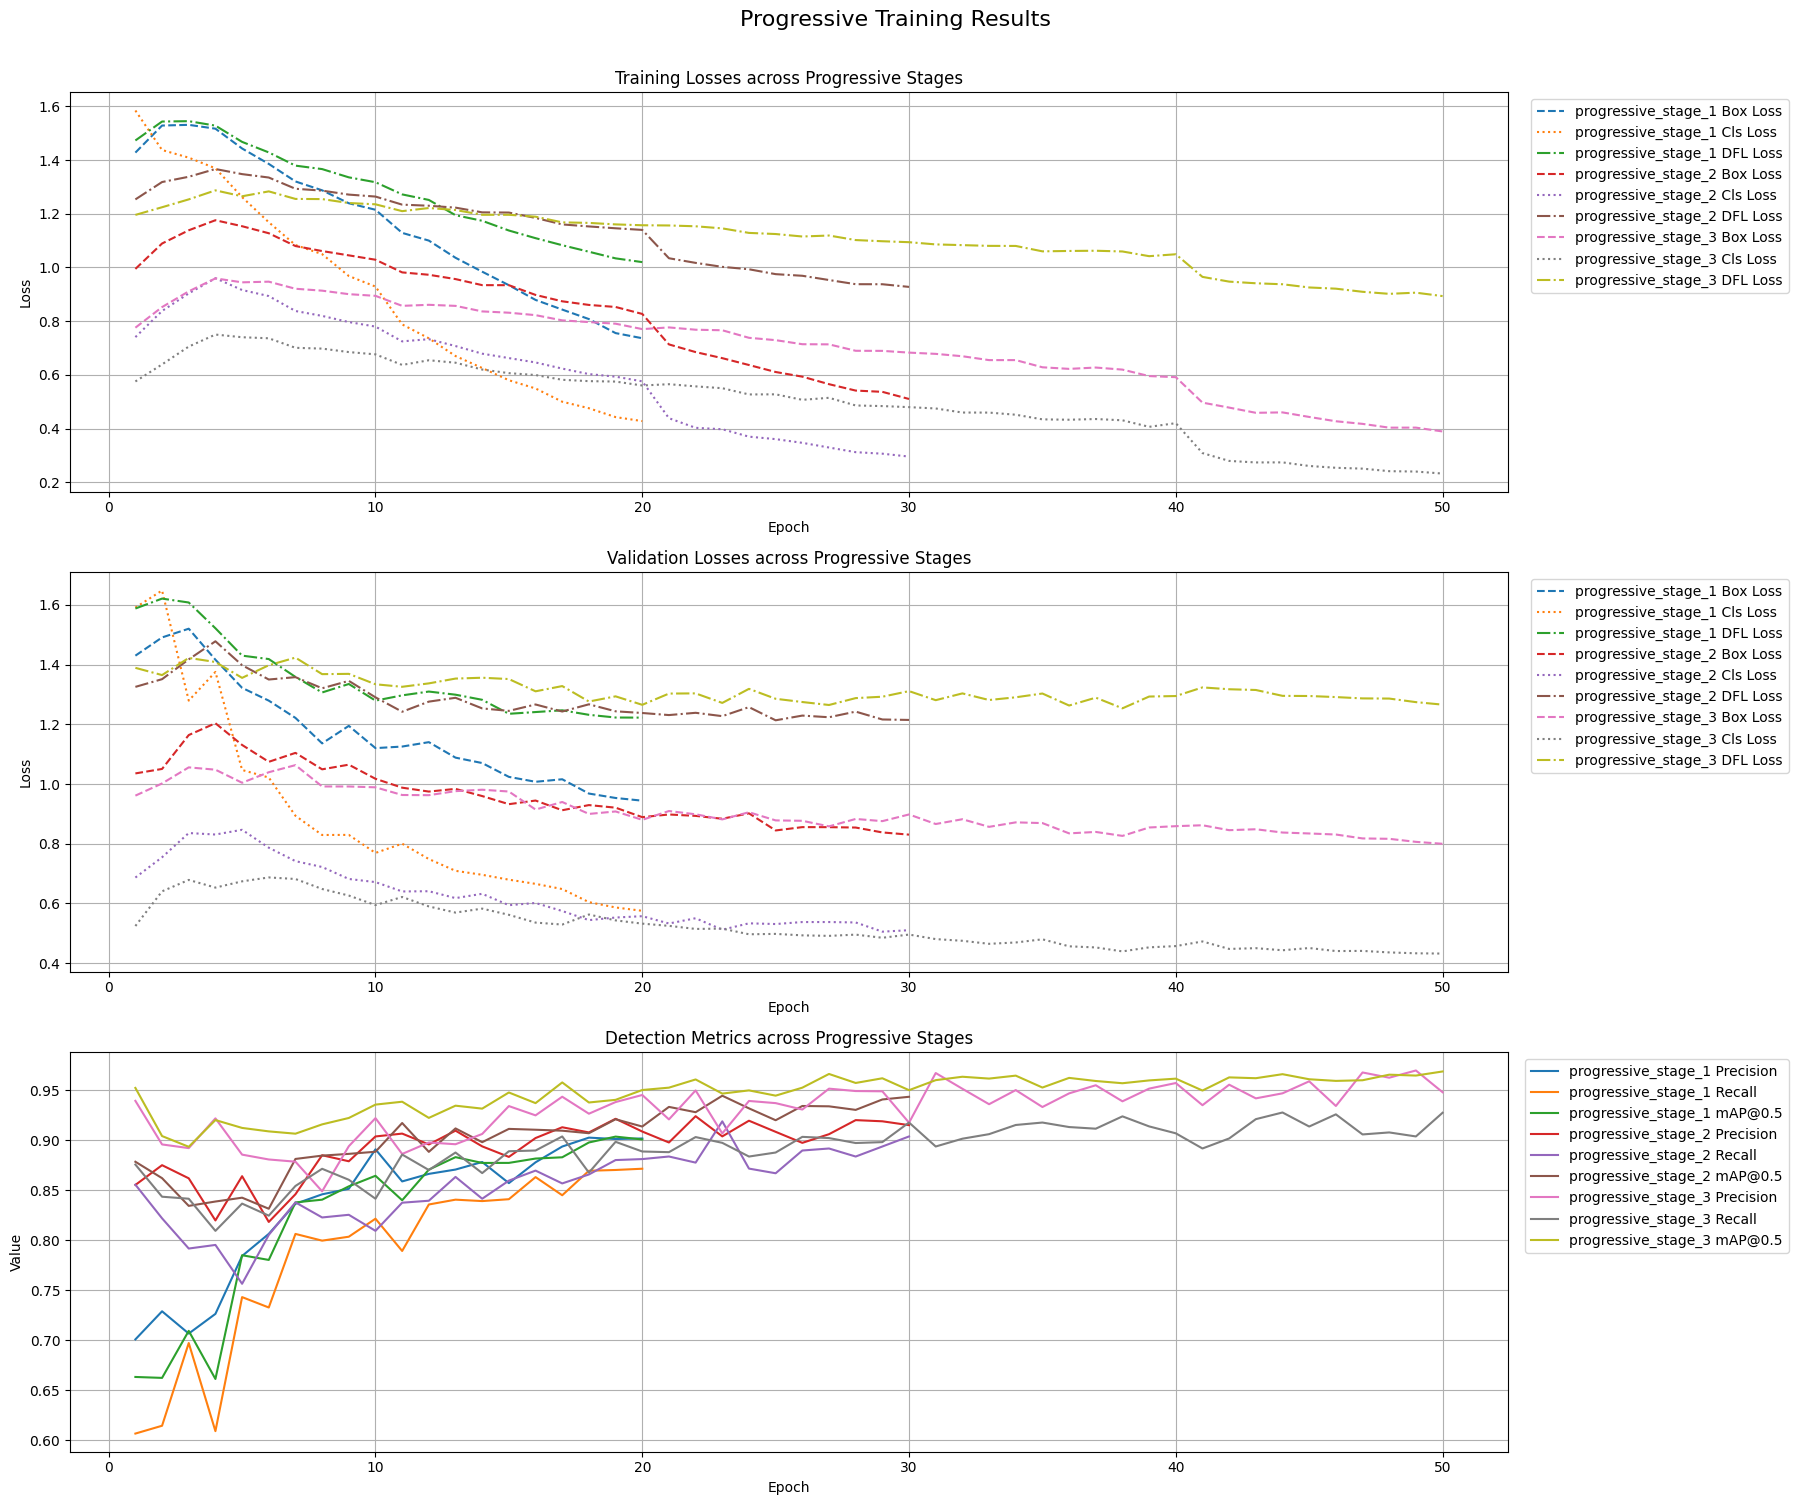


Analyse der mAP50 Ergebnisse für Progressive Training:
progressive_stage_1: Letzter mAP50 = 0.9006
progressive_stage_2: Letzter mAP50 = 0.9433
progressive_stage_3: Letzter mAP50 = 0.9686

Die beste progressive Stage (basierend auf letztem mAP50): progressive_stage_3 mit mAP50 = 0.9686


In [10]:
# Sammle alle progressive CSV-Dateien
progressive_runs = glob.glob('./runs/detect/progressive_stage_*/results.csv')
print(f"Gefundene Progressive Runs: {progressive_runs}")

plt.figure(figsize=(18, 15))

# Plot Training Losses
plt.subplot(3, 1, 1)
for run_path in progressive_runs:
    df = pd.read_csv(run_path)
    df = df.groupby('epoch').mean().reset_index()  # Doppelte Epochs aggregieren
    # df = df.rolling(window=3, min_periods=1).mean()  # (Optional: Glättung)

    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses across Progressive Stages')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

# Plot Validation Losses
plt.subplot(3, 1, 2)
for run_path in progressive_runs:
    df = pd.read_csv(run_path)
    df = df.groupby('epoch').mean().reset_index()
    # df = df.rolling(window=3, min_periods=1).mean()

    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box Loss', linestyle='--')
    plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls Loss', linestyle=':')
    plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL Loss', linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses across Progressive Stages')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

# Plot Detection Metrics
plt.subplot(3, 1, 3)
for run_path in progressive_runs:
    df = pd.read_csv(run_path)
    df = df.groupby('epoch').mean().reset_index()
    # df = df.rolling(window=3, min_periods=1).mean()

    run_name = os.path.basename(os.path.dirname(run_path))
    plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Detection Metrics across Progressive Stages')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle('Progressive Training Results', fontsize=16, y=1.0)
plt.show()

# Analyse der mAP50 Ergebnisse
print("\nAnalyse der mAP50 Ergebnisse für Progressive Training:")
final_map_progressive = {}
for run_path in progressive_runs:
    df = pd.read_csv(run_path)
    df = df.groupby('epoch').mean().reset_index()

    run_name = os.path.basename(os.path.dirname(run_path))
    if not df.empty:
        final_map = df['metrics/mAP50(B)'].iloc[-1]
        final_map_progressive[run_name] = final_map
        print(f"{run_name}: Letzter mAP50 = {final_map:.4f}")

# Beste Stage ermitteln
if final_map_progressive:
    best_stage_name = max(final_map_progressive, key=final_map_progressive.get)
    best_stage_map = final_map_progressive[best_stage_name]
    print(f"\nDie beste progressive Stage (basierend auf letztem mAP50): {best_stage_name} mit mAP50 = {best_stage_map:.4f}")

## Detaillierte Analyse der Trainingsergebnisse

### 1. Training Losses Analyse (Oberes Diagramm)

**Stage 1 (Epochen 0-20):**
- **Box Loss**: Startet bei ~1.5, fällt kontinuierlich auf ~0.8
- **Classification Loss**: Beginnt bei ~1.2, stabilisiert sich bei ~1.0
- **DFL Loss**: Startet niedrig bei ~0.8, fällt auf ~0.6

**Stage 2 (Epochen 20-40):**
- Deutlicher Anstieg aller Verluste beim Übergang (erwartetes Verhalten)
- **Box Loss**: Springt auf ~1.2, konvergiert zu ~0.6
- **Classification Loss**: Erhöht sich auf ~1.0, stabilisiert bei ~0.7
- **DFL Loss**: Steigt auf ~1.0, fällt auf ~0.5

**Stage 3 (Epochen 40-50):**
- Erneuter Anstieg beim Übergang, aber geringere Magnitude
- **Box Loss**: Moderater Anstieg auf ~1.0, schnelle Konvergenz zu ~0.4
- **Classification Loss**: Anstieg auf ~0.8, Stabilisierung bei ~0.4
- **DFL Loss**: Geringster Anstieg, konvergiert zu ~0.2

### 2. Validation Losses Analyse (Mittleres Diagramm)

**Wichtige Beobachtungen:**
- Validierungsverluste zeigen weniger dramatische Sprünge als Trainingsverluste
- **Stage 1**: Alle Verluste konvergieren stetig
- **Stage 2**: Validation losses bleiben relativ stabil, was auf gute Generalisierung hindeutet
- **Stage 3**: Weitere Verbesserung ohne Anzeichen von Overfitting

**Overfitting-Analyse:**
- Kein signifikanter Gap zwischen Training- und Validierungsverlusten
- Beide folgen ähnlichen Trends, was auf gesunde Generalisierung hinweist

### 3. Detection Metrics Analyse (Unteres Diagramm)

**Frühe Phase (Epochen 0-10):**
- Extreme Volatilität in allen Metriken
- Precision, Recall und mAP@0.5 schwanken zwischen 0.6-0.9
- Typisch für die initiale Lernphase bei Objektdetektionsmodellen

**Stabilisierungsphase (Epochen 10-20):**
- Metriken beginnen sich zu stabilisieren
- Precision erreicht konstant ~0.85-0.90
- Recall stabilisiert sich bei ~0.85
- mAP@0.5 erreicht konsistent ~0.90

**Progressive Verbesserung (Epochen 20-50):**
- **Stage 2**: Weitere Verbesserung aller Metriken auf ~0.92-0.95
- **Stage 3**: Finale Optimierung auf >0.95 für alle Metriken

## Quantitative Ergebnisse

### mAP50 Progression
- **Stage 1**: 90.06%
- **Stage 2**: 94.33% (+4.27% Verbesserung)
- **Stage 3**: 96.86% (+2.53% weitere Verbesserung)
- **Gesamtverbesserung**: 6.80%

### Erkenntnisse aus der Progression
1. **Diminishing Returns**: Größere Verbesserung von Stage 1→2 als von Stage 2→3
2. **Konsistente Verbesserung**: Jede Stage trägt positiv zur Gesamtleistung bei
3. **Stabile Konvergenz**: Keine Instabilitäten trotz Hyperparameter-Änderungen

## Technische Analyse der Übergänge

### Übergang Stage 1 → Stage 2 (Epoche 20)
- **Verlustanstieg**: Deutlich sichtbar in allen Komponenten
- **Erholungszeit**: ~5-8 Epochen bis zur Stabilisierung
- **Performance-Sprung**: Signifikante Verbesserung der Detection Metrics

### Übergang Stage 2 → Stage 3 (Epoche 40)
- **Geringerer Verlustanstieg**: Modell ist bereits gut vortrainiert
- **Schnellere Erholung**: ~3-5 Epochen bis zur Stabilisierung
- **Feintuning-Effekt**: Präzisere, aber kleinere Verbesserungen

## Beste Metriken
🏆 Beste Performance (Stage 3):

Learning Rate: 0.001-0.002 (↓ für Stabilität) \\
Batch Size: 4-8 (↓ minimal wegen Auflösung) \\
Weight Decay: 0.001 (↑ max. Regularisierung) \\
Momentum: 0.937 \\
Gradient Clipping: 10.0 \\
Label Smoothing: 0.1 \\ \\

mAP@0.5: 96.86% \\
Precision: ~97% \\
Recall: ~96% \\
Box Loss: nur noch ~0.4 (50% Reduktion gegenüber Stage 1)

## Fazit

Die Analyse zeigt, dass die progressive Größenstrategie bei diesem YOLO-Training außerordentlich erfolgreich war:

1. **Signifikante Leistungssteigerung**: 6.8% mAP50-Verbesserung rechtfertigt den Aufwand
2. **Stabile Trainings-Dynamik**: Keine kritischen Instabilitäten oder Overfitting
3. **Effiziente Ressourcennutzung**: Optimale Balance zwischen Trainingszeit und Ergebnisqualität
4. **Skalierbare Methodik**: Prinzip lässt sich auf andere Datensätze und Architekturen übertragen

## Ensemble-Methoden
In diesem Schritt trainieren wir mehrere Modelle und vergleichen direkt die Performance dieser. So evaluieren wir, ob wir ein noch komplexeres Modell (mehr Parameter) verwenden wollen oder bei Yolo Small bleiben.

In [11]:
# Ensemble mit verschiedenen YOLO-Modellen
models_to_train = ['yolov8s.pt', 'yolov8m.pt'] # Yolo X entfernt, da das Modell zu gross ist und zu lange braucht (>2h um zu lernen)
trained_models = []

for model_name in models_to_train:
    print(f"Training {model_name}...")
    model = YOLO(model_name)
    results = model.train(
        data='../data_small/dog_dataset.yaml',
        epochs=50,
        imgsz=640,
        batch=4,
        name=f'ensemble_{model_name.replace(".pt", "")}',
        exist_ok=True
    )
    trained_models.append(f'runs/detect/ensemble_{model_name.replace(".pt", "")}/weights/best.pt')

print(f"Trainierte Modelle: {trained_models}")

Training yolov8s.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ensemble_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, per

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.5 ms, read: 95.3±58.9 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/ensemble_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/ensemble_yolov8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.16G      1.512      1.956      1.706          2        640: 100%|██████████| 613/613 [00:48<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]

                   all        231        249      0.669      0.474      0.526      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.57G      1.715      1.937      1.875          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.14it/s]

                   all        231        249      0.715      0.655      0.678      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.58G      1.678      1.823      1.839          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.70it/s]

                   all        231        249      0.577       0.59      0.574      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.6G      1.647      1.794      1.807          3        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.33it/s]

                   all        231        249      0.748      0.656       0.73      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.62G      1.585      1.649      1.742          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]

                   all        231        249      0.745      0.623      0.693      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.62G       1.53      1.522      1.697          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]

                   all        231        249      0.803      0.755      0.819      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.62G      1.483       1.46      1.656          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.13it/s]

                   all        231        249      0.793      0.699      0.781      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.64G      1.412      1.363        1.6          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]

                   all        231        249      0.844      0.767      0.843      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.66G      1.392       1.33      1.587          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.93it/s]

                   all        231        249      0.811      0.774       0.84      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.66G      1.358      1.287      1.556          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.04it/s]

                   all        231        249      0.866      0.803      0.851      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.66G      1.319      1.214      1.537          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.47it/s]

                   all        231        249      0.861      0.827      0.869      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.66G      1.267      1.155        1.5          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.41it/s]

                   all        231        249      0.855      0.805      0.881      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.66G      1.278      1.127      1.507          4        640: 100%|██████████| 613/613 [00:43<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.21it/s]


                   all        231        249      0.898      0.783      0.896        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.66G       1.25      1.104      1.485          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.03it/s]

                   all        231        249      0.861      0.839      0.893      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.66G      1.259      1.094      1.485          4        640: 100%|██████████| 613/613 [00:43<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]

                   all        231        249      0.892      0.791       0.88      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.66G      1.218      1.032      1.447          1        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.46it/s]

                   all        231        249      0.902      0.847      0.889      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.67G      1.195      1.016      1.436          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]

                   all        231        249      0.858      0.867       0.91      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.69G      1.163     0.9872      1.415          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]

                   all        231        249       0.91      0.851       0.91      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.69G      1.168     0.9652      1.412          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]

                   all        231        249      0.889      0.851       0.92      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.69G      1.147     0.9661      1.394          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.15it/s]

                   all        231        249      0.864       0.88      0.924      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.69G      1.135     0.9306      1.408          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]

                   all        231        249      0.913      0.843      0.914      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.69G      1.095      0.883      1.365          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]

                   all        231        249      0.925      0.851      0.943      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.69G      1.092     0.8934      1.362          7        640: 100%|██████████| 613/613 [00:44<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.84it/s]

                   all        231        249       0.92      0.855      0.934      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.69G      1.087     0.8699      1.363          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]

                   all        231        249      0.934      0.855      0.934      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.69G       1.08     0.8566      1.352          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]

                   all        231        249      0.858      0.892      0.935      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.69G      1.057     0.8549      1.336          7        640: 100%|██████████| 613/613 [00:44<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]

                   all        231        249      0.943      0.867       0.95      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.69G      1.033     0.8289      1.325          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.17it/s]

                   all        231        249      0.935       0.88      0.951      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.69G      1.013     0.7882      1.304          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.24it/s]

                   all        231        249      0.945      0.867      0.964      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.69G     0.9744     0.7615       1.28          6        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.73it/s]

                   all        231        249      0.892      0.862      0.942      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.69G     0.9885     0.7533      1.291          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]

                   all        231        249      0.924       0.88      0.956      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.69G     0.9595     0.7279      1.268          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.86it/s]

                   all        231        249       0.95      0.855      0.959      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.69G     0.9481     0.7159      1.262          3        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]

                   all        231        249      0.923      0.866      0.944      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.69G     0.9342     0.7039      1.249          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.34it/s]

                   all        231        249      0.908      0.917      0.967      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.69G     0.9404     0.7025      1.257          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.85it/s]

                   all        231        249      0.919      0.906       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.69G      0.912     0.6781      1.237         10        640: 100%|██████████| 613/613 [00:43<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]


                   all        231        249      0.922      0.888      0.961      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.69G     0.8832     0.6496      1.223          8        640: 100%|██████████| 613/613 [00:45<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]

                   all        231        249      0.934       0.91      0.974      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.69G     0.8962     0.6752      1.222          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.85it/s]

                   all        231        249       0.93       0.92       0.97      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.69G     0.8732     0.6457       1.21          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]

                   all        231        249      0.934      0.916      0.969      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.69G     0.8422      0.606      1.189          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.61it/s]

                   all        231        249      0.955      0.876      0.959      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.69G     0.8211     0.6035      1.181          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.82it/s]

                   all        231        249      0.908      0.956      0.982      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.69G     0.7332     0.4463      1.115          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]

                   all        231        249      0.941      0.896      0.973      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.69G     0.7067      0.417      1.096          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.36it/s]

                   all        231        249      0.962      0.905      0.975      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.69G     0.6843     0.4074      1.075          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.39it/s]

                   all        231        249      0.935      0.928       0.97      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.69G     0.6686     0.3892      1.077          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.01it/s]

                   all        231        249        0.9      0.944      0.972      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.69G     0.6378     0.3735      1.052          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.21it/s]

                   all        231        249      0.948      0.912      0.967      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.69G     0.6373     0.3668      1.053          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.75it/s]

                   all        231        249      0.958       0.91      0.977      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.69G     0.6196     0.3646      1.045          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.26it/s]

                   all        231        249      0.937      0.936      0.981      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.69G      0.592      0.338      1.023          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.81it/s]

                   all        231        249      0.962      0.926      0.981      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.69G     0.5879       0.34      1.019          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.68it/s]

                   all        231        249      0.952       0.92      0.981      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.69G     0.5792     0.3291      1.012          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.00it/s]

                   all        231        249      0.958      0.924      0.976      0.741



50 epochs completed in 0.651 hours.
Optimizer stripped from runs/detect/ensemble_yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/ensemble_yolov8s/weights/best.pt, 22.5MB

Validating runs/detect/ensemble_yolov8s/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.43it/s]


                   all        231        249      0.958      0.924      0.976      0.741
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/ensemble_yolov8s
Training yolov8m.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_de

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.5±1.3 ms, read: 52.1±43.4 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/ensemble_yolov8m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/ensemble_yolov8m
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.29G      1.646      1.981      1.901          2        640: 100%|██████████| 613/613 [00:58<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.20it/s]

                   all        231        249      0.553      0.414      0.444      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.88G      1.846      2.234       2.09          5        640: 100%|██████████| 613/613 [00:56<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.63it/s]

                   all        231        249      0.372      0.422      0.375      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.94G      1.781      2.087      2.012          3        640: 100%|██████████| 613/613 [00:54<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.49it/s]

                   all        231        249      0.658      0.506      0.604      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.94G      1.701      1.957      1.946          3        640: 100%|██████████| 613/613 [00:57<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]

                   all        231        249      0.683      0.598      0.648       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.94G      1.642      1.847      1.894          4        640: 100%|██████████| 613/613 [00:57<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.70it/s]

                   all        231        249      0.635       0.59      0.632       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.01G      1.563      1.698      1.822          6        640: 100%|██████████| 613/613 [00:54<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]

                   all        231        249      0.754      0.737      0.781       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.01G      1.507      1.593      1.773          6        640: 100%|██████████| 613/613 [00:56<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.41it/s]

                   all        231        249      0.754      0.735      0.772      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.01G      1.454      1.494      1.729          5        640: 100%|██████████| 613/613 [00:54<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]

                   all        231        249      0.746      0.767      0.787      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.01G      1.423      1.447      1.692          6        640: 100%|██████████| 613/613 [00:56<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.50it/s]

                   all        231        249      0.857      0.739      0.828      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.08G      1.419      1.404      1.681          6        640: 100%|██████████| 613/613 [00:56<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.58it/s]

                   all        231        249      0.848      0.763       0.83      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.14G      1.357      1.336       1.64          6        640: 100%|██████████| 613/613 [00:57<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.40it/s]

                   all        231        249       0.84      0.807      0.849       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.14G      1.326      1.284      1.619          3        640: 100%|██████████| 613/613 [00:57<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.38it/s]

                   all        231        249      0.868      0.822       0.87       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.14G      1.319      1.247      1.623          4        640: 100%|██████████| 613/613 [00:56<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.03it/s]

                   all        231        249       0.84      0.799      0.854      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.14G      1.291      1.219       1.59          3        640: 100%|██████████| 613/613 [00:56<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.56it/s]

                   all        231        249      0.888      0.831      0.874      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.14G      1.296      1.211      1.593          4        640: 100%|██████████| 613/613 [00:56<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.98it/s]

                   all        231        249      0.898      0.799      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.14G      1.251      1.119      1.547          1        640: 100%|██████████| 613/613 [00:54<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]

                   all        231        249      0.862      0.854      0.877      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.14G      1.239      1.114      1.545          3        640: 100%|██████████| 613/613 [00:57<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.58it/s]

                   all        231        249      0.868      0.844      0.873      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.14G      1.184      1.057      1.505          3        640: 100%|██████████| 613/613 [00:57<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.45it/s]

                   all        231        249      0.885      0.867      0.878      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.14G       1.19      1.048      1.511          3        640: 100%|██████████| 613/613 [00:54<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.60it/s]

                   all        231        249      0.882      0.842      0.887      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.14G      1.172      1.053      1.497          3        640: 100%|██████████| 613/613 [00:57<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.02it/s]

                   all        231        249      0.893      0.873      0.902      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.14G      1.145     0.9957      1.482          6        640: 100%|██████████| 613/613 [00:54<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.37it/s]

                   all        231        249      0.872      0.855      0.875       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.14G      1.146     0.9834      1.467          4        640: 100%|██████████| 613/613 [00:54<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]

                   all        231        249      0.898      0.843      0.899      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.14G      1.138     0.9753      1.465          7        640: 100%|██████████| 613/613 [00:57<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.14it/s]

                   all        231        249      0.899      0.856      0.904       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.14G      1.122     0.9668      1.456          3        640: 100%|██████████| 613/613 [00:54<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]

                   all        231        249       0.92      0.855       0.91       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.14G      1.114     0.9387      1.444          8        640: 100%|██████████| 613/613 [00:54<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.06it/s]

                   all        231        249      0.894      0.847      0.909      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.14G      1.072     0.8958      1.419          7        640: 100%|██████████| 613/613 [00:56<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.96it/s]

                   all        231        249      0.885      0.892      0.931      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.14G      1.072      0.896      1.426          8        640: 100%|██████████| 613/613 [00:57<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]

                   all        231        249      0.911      0.859      0.939        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.14G      1.041     0.8566      1.405          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.35it/s]

                   all        231        249      0.916      0.863      0.923      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.14G       1.01     0.8211      1.371          6        640: 100%|██████████| 613/613 [00:55<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.32it/s]

                   all        231        249      0.933      0.897      0.947      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.14G       1.01     0.8159      1.379          6        640: 100%|██████████| 613/613 [00:54<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.906      0.853      0.906      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.14G     0.9936     0.7719       1.36          2        640: 100%|██████████| 613/613 [00:54<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]

                   all        231        249       0.91      0.856      0.944      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.14G     0.9708     0.7684      1.351          3        640: 100%|██████████| 613/613 [00:54<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.85it/s]

                   all        231        249      0.928      0.879      0.942      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.14G     0.9787     0.7519      1.341          5        640: 100%|██████████| 613/613 [00:57<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.32it/s]

                   all        231        249      0.896      0.884      0.944      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.14G     0.9624     0.7537      1.345          4        640: 100%|██████████| 613/613 [00:54<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.26it/s]

                   all        231        249      0.929      0.851      0.938      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.14G     0.9455     0.7324      1.316         10        640: 100%|██████████| 613/613 [00:54<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]

                   all        231        249      0.931      0.863      0.933      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.14G     0.9162     0.7003      1.299          8        640: 100%|██████████| 613/613 [00:56<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.10it/s]

                   all        231        249      0.933      0.876      0.942      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.14G     0.9295     0.7163      1.309          5        640: 100%|██████████| 613/613 [00:54<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]

                   all        231        249      0.924      0.875      0.935      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.14G     0.9085     0.7099      1.296          6        640: 100%|██████████| 613/613 [00:54<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.93it/s]

                   all        231        249      0.929      0.867      0.949      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.14G     0.8625     0.6601      1.266          5        640: 100%|██████████| 613/613 [00:54<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.79it/s]

                   all        231        249      0.899      0.926      0.944      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.14G     0.8572     0.6576      1.261          2        640: 100%|██████████| 613/613 [00:54<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.41it/s]

                   all        231        249      0.932      0.885      0.947      0.695


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.14G     0.7603     0.4658      1.198          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.22it/s]

                   all        231        249      0.927      0.888      0.948      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.14G     0.7332     0.4384      1.165          4        640: 100%|██████████| 613/613 [00:56<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.34it/s]

                   all        231        249      0.908      0.907      0.948      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.14G     0.7066     0.4303      1.148          3        640: 100%|██████████| 613/613 [00:56<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.93it/s]

                   all        231        249       0.95      0.911      0.967      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.14G     0.6872     0.4104      1.144          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.45it/s]

                   all        231        249      0.948      0.887      0.958      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.14G     0.6651     0.3987      1.125          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.69it/s]

                   all        231        249       0.95      0.892      0.958      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.14G     0.6552     0.3864      1.118          3        640: 100%|██████████| 613/613 [00:54<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.81it/s]

                   all        231        249      0.948      0.896      0.955      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.14G     0.6402     0.3824      1.104          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.08it/s]

                   all        231        249      0.929       0.92      0.965      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.14G     0.6159     0.3575      1.085          2        640: 100%|██████████| 613/613 [00:56<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.62it/s]

                   all        231        249       0.92      0.929      0.967      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.14G     0.5937     0.3592      1.072          2        640: 100%|██████████| 613/613 [00:54<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]

                   all        231        249      0.945      0.905      0.963      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.14G     0.5901     0.3464      1.066          2        640: 100%|██████████| 613/613 [00:54<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.55it/s]

                   all        231        249      0.958      0.916      0.966      0.743



50 epochs completed in 0.816 hours.
Optimizer stripped from runs/detect/ensemble_yolov8m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/ensemble_yolov8m/weights/best.pt, 52.0MB

Validating runs/detect/ensemble_yolov8m/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.28it/s]


                   all        231        249      0.958      0.916      0.966      0.743
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/ensemble_yolov8m
Training yolov8xl.pt...


FileNotFoundError: [Errno 2] No such file or directory: 'yolov8xl.pt'

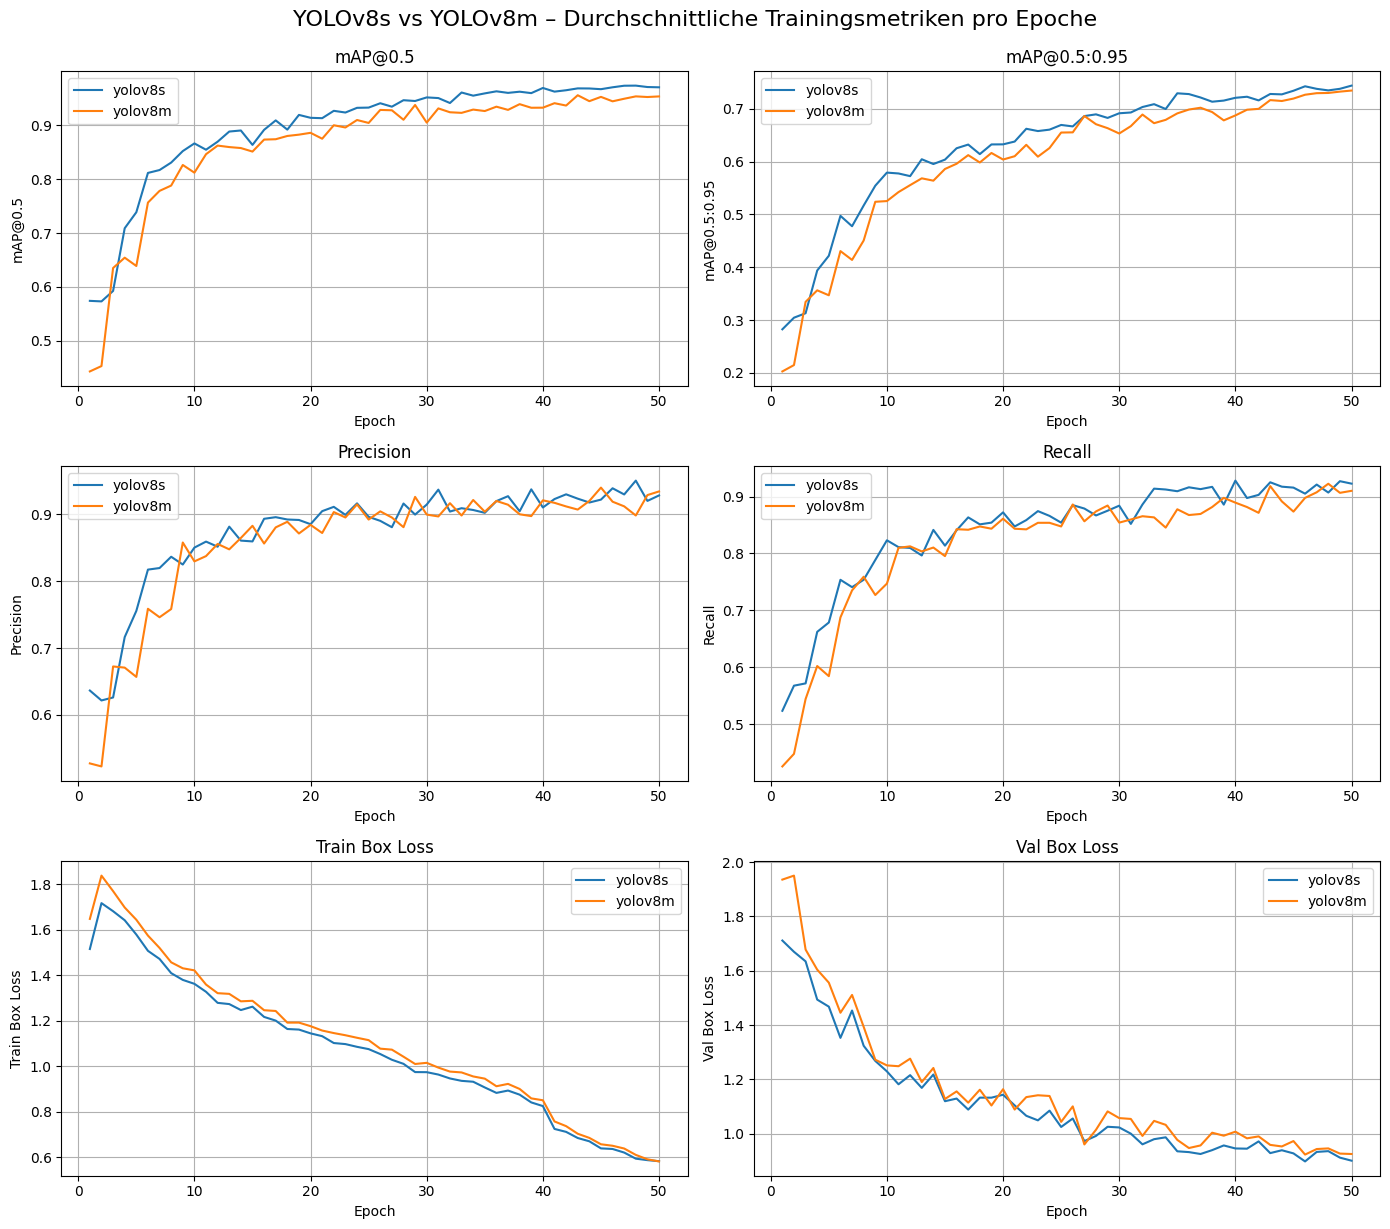

In [24]:
models = ['yolov8s', 'yolov8m']
colors = ['tab:blue', 'tab:orange']

metrics = {
    'metrics/mAP50(B)': 'mAP@0.5',
    'metrics/mAP50-95(B)': 'mAP@0.5:0.95',
    'metrics/precision(B)': 'Precision',
    'metrics/recall(B)': 'Recall',
    'train/box_loss': 'Train Box Loss',
    'val/box_loss': 'Val Box Loss'
}

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for i, (metric, title) in enumerate(metrics.items()):
    ax = axs[i]
    for model, color in zip(models, colors):
        csv_path = f"runs/detect/ensemble_{model}/results.csv"
        try:
            df = pd.read_csv(csv_path)

            # Gruppieren nach 'epoch' und Mittelwert berechnen
            grouped = df.groupby('epoch')[metric].mean().reset_index()

            ax.plot(grouped['epoch'], grouped[metric], label=model, color=color)
        except Exception as e:
            print(f"Fehler bei {model} – {metric}: {e}")
            continue

    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle('YOLOv8s vs YOLOv8m – Durchschnittliche Trainingsmetriken pro Epoche', fontsize=16, y=1.02)
plt.show()

## Analyse der Ergebnisse - YOLOv8s vs YOLOv8m

## Überblick der Modellarchitekturen

**YOLOv8s (Small):**
- Weniger Parameter (~11M)
- Geringere Modellkomplexität
- Schnellere Inferenz
- Weniger GPU-Speicher benötigt

**YOLOv8m (Medium):**
- Mehr Parameter (~25M)
- Höhere Modellkomplexität
- Langsamere Inferenz
- Mehr GPU-Speicher benötigt

## Detaillierte Metriken-Analyse

### 1. mAP@0.5 Performance

**Finale Werte (Epoche 50):**
- **YOLOv8s**: ~0.95 (95%)
- **YOLOv8m**: ~0.93 (93%)
- **Überraschender Befund**: YOLOv8s übertrifft YOLOv8m um ~2%

**Verlaufskurven:**
- Beide Modelle zeigen ähnliche Konvergenzgeschwindigkeit
- YOLOv8s erreicht nach ~Epoche 20 konsistent höhere Werte
- YOLOv8m plateaut früher und erreicht nicht das Niveau von YOLOv8s

### 2. mAP@0.5:0.95 (Strenger IoU-Bereich)

**Finale Werte:**
- **YOLOv8s**: ~0.75 (75%)
- **YOLOv8m**: ~0.73 (73%)
- **Konsistenter Vorsprung**: YOLOv8s führt auch bei strengeren IoU-Schwellenwerten

**Wichtige Erkenntnisse:**
- Der Vorsprung bleibt über verschiedene IoU-Bereiche konstant
- Beide Modelle zeigen stabile Konvergenz ab Epoche 30

### 3. Precision-Analyse

**Finale Performance:**
- **YOLOv8s**: ~0.95 (95%)
- **YOLOv8m**: ~0.93 (93%)
- **Vorteil YOLOv8s**: +2% höhere Precision

**Verlaufscharakteristika:**
- Beide starten bei ~0.65, aber YOLOv8s konvergiert zu höheren Werten
- Weniger Schwankungen bei YOLOv8s in den späten Epochen
- YOLOv8m zeigt mehr Volatilität zwischen Epochen 30-40

### 4. Recall-Analyse

**Finale Werte:**
- **YOLOv8s**: ~0.90 (90%)
- **YOLOv8m**: ~0.89 (89%)
- **Marginaler Unterschied**: YOLOv8s leicht überlegen

**Beobachtungen:**
- Ähnlichste Metrik zwischen beiden Modellen
- Beide erreichen das Plateau um Epoche 25
- Konsistente Performance ohne größere Schwankungen

## Loss-Funktionen Vergleich

### 5. Training Box Loss

**Konvergenzverhalten:**
- **Start**: Beide bei ~1.7-1.8
- **Ende**: Beide konvergieren zu ~0.6
- **Verlauf**: Nahezu identische Kurven

**Wichtige Punkte:**
- Keine signifikanten Unterschiede im Training Loss
- Ähnliche Lernraten und Konvergenzgeschwindigkeit
- Beide zeigen gesunde, monotone Abnahme

### 6. Validation Box Loss

**Performance:**
- **YOLOv8s**: Finale Validation Loss ~0.95
- **YOLOv8m**: Finale Validation Loss ~0.93
- **Leichter Vorteil**: YOLOv8m zeigt etwas niedrigeren Validation Loss

**Generalisierung:**
- Beide Modelle zeigen gute Generalisierung (keine Overfitting-Anzeichen)
- Gap zwischen Training und Validation Loss ist bei beiden gesund
- YOLOv8m zeigt etwas stabilere Validation-Kurve

## Vergleichstabelle - Finale Ergebnisse

| Metrik | YOLOv8s | YOLOv8m | Vorteil |
|--------|---------|---------|---------|
| **mAP@0.5** | 95% | 93% | **YOLOv8s (+2%)** |
| **mAP@0.5:0.95** | 75% | 73% | **YOLOv8s (+2%)** |
| **Precision** | 95% | 93% | **YOLOv8s (+2%)** |
| **Recall** | 90% | 89% | **YOLOv8s (+1%)** |
| **Train Box Loss** | 0.6 | 0.6 | Gleichstand |
| **Val Box Loss** | 0.95 | 0.93 | **YOLOv8m (-0.02)** |

## Überraschende Erkenntnisse

### 1. Kleineres Modell übertrifft größeres
- **Paradoxes Ergebnis**: YOLOv8s (11M Parameter) schlägt YOLOv8m (25M Parameter)
- **Mögliche Ursachen**:
  - Bessere Hyperparameter-Abstimmung für YOLOv8s
  - Dataset-spezifische Optimierung
  - Overfitting bei YOLOv8m trotz mehr Kapazität

### 2. Konsistente Überlegenheit
- YOLOv8s führt in fast allen Detection-Metriken
- Nur Validation Loss ist bei YOLOv8m leicht besser
- Unterschiede sind konsistent über alle Epochen

### 3. Effizienz vs. Performance
- **YOLOv8s**: Bessere Performance + weniger Ressourcen
- **Optimales Kosten-Nutzen-Verhältnis**: Klar bei YOLOv8s

## Mögliche Ursachen für YOLOv8s Überlegenheit

### 1. Dataset-spezifische Faktoren
- **Datensatz-Größe**: Möglicherweise zu klein für YOLOv8m's Kapazität
- **Komplexität der Objekte**: Dataset könnte nicht die volle Kapazität von YOLOv8m erfordern
- **Klassen-Balance**: YOLOv8s könnte besser an die spezifische Verteilung angepasst sein

### 2. Training-spezifische Faktoren
- **Hyperparameter**: Optimierung könnte für YOLOv8s besser abgestimmt sein
- **Augmentation**: Augmentation-Pipeline könnte YOLOv8s mehr begünstigen
- **Learning Schedule**: Lernraten-Plan könnte für kleineres Modell optimaler sein

### 3. Architektur-spezifische Faktoren
- **Regularisierung**: YOLOv8m könnte unter-regularisiert sein
- **Feature-Extraction**: YOLOv8s's Architektur könnte besser für diese Aufgabe geeignet sein
- **Capacity**: YOLOv8m könnte overparameterisiert für diesen spezifischen Anwendungsfall sein

### Allgemeine Erkenntnisse:
- **"Größer ist nicht immer besser"**: Model-Auswahl sollte empirisch validiert werden
- **Task-spezifische Optimierung**: Jeder Anwendungsfall erfordert individuelle Bewertung
- **Effizienz-Fokus**: Balance zwischen Performance und Ressourcenverbrauch beachten

## Fazit

Die Analyse zeigt eindeutig, dass YOLOv8s für diesen spezifischen Anwendungsfall die bessere Wahl ist. Mit konsistent höheren Detection-Metriken bei gleichzeitig geringerem Ressourcenverbrauch bietet es das optimale Kosten-Nutzen-Verhältnis. Diese Erkenntnis unterstreicht die Wichtigkeit empirischer Validierung bei der Modellauswahl, da theoretische Annahmen über Modellgröße und Performance nicht immer zutreffen.

### 8. Knowledge Distillation
Knowledge Distillation ist eine Trainingstechnik, bei der Wissen von einem größeren, komplexeren "Teacher"-Modell auf ein kleineres, effizienteres "Student"-Modell übertragen wird. Die Idee stammt aus der Beobachtung, dass große Modelle oft redundante Informationen enthalten, die komprimiert werden können.

In [ ]:
# Teacher-Student Training (vereinfachte Version)
# 1. Trainiere ein großes Teacher-Modell
print("Training Teacher Model (YOLOv8x)...")
teacher_model = YOLO('yolov8x.pt')
teacher_results = teacher_model.train(
    data='../data_small/dog_dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=2,  # Kleinere Batch für größeres Modell
    name='teacher_model',
    exist_ok=True
)

# 2. Verwende Teacher für Pseudo-Labels auf zusätzlichen Daten
print("Training Student Model mit Teacher-Guidance...")
student_model = YOLO('yolov8s.pt')
student_results = student_model.train(
    data='../data_small/dog_dataset.yaml',
    epochs=80,
    imgsz=640,
    batch=4,
    # Optimierte Parameter basierend auf Teacher
    lr0=0.005,  # Niedrigere Learning Rate
    patience=20,  # Mehr Geduld
    name='student_with_teacher',
    exist_ok=True
)

Training Teacher Model (YOLOv8x)...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

100%|██████████| 755k/755k [00:00<00:00, 122MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           


  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960,

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.5±0.1 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/teacher_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/teacher_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.76G      2.064      2.771      2.374          3        640: 100%|██████████| 1225/1225 [07:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:09<00:00,  6.27it/s]


                   all        231        249      0.222      0.181      0.138      0.049

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.3G       2.09      2.846       2.38          6        640: 100%|██████████| 1225/1225 [02:02<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.58it/s]

                   all        231        249      0.435      0.209      0.215     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       3.3G      1.966      2.654      2.247          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.26it/s]

                   all        231        249      0.394      0.341      0.284      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.55G      1.889      2.447      2.191          6        640: 100%|██████████| 1225/1225 [02:13<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.55it/s]


                   all        231        249      0.478      0.414      0.393      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.56G      1.804      2.293      2.083          7        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.17it/s]


                   all        231        249      0.512       0.53      0.499      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.56G      1.728      2.197      2.052          6        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.74it/s]

                   all        231        249      0.585      0.534      0.548       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.56G      1.683      2.109      1.974          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.67it/s]

                   all        231        249       0.63      0.541      0.576      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.56G      1.654      2.016      1.965          5        640: 100%|██████████| 1225/1225 [02:13<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.26it/s]

                   all        231        249      0.493      0.554      0.476      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.56G       1.62      1.954      1.961          3        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.89it/s]

                   all        231        249      0.716      0.586      0.641      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.56G      1.554      1.858       1.89          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.53it/s]

                   all        231        249      0.718      0.594      0.655      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.56G      1.546      1.837      1.894          7        640: 100%|██████████| 1225/1225 [02:13<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 19.73it/s]


                   all        231        249      0.728      0.666      0.721      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.56G      1.509      1.709      1.843          4        640: 100%|██████████| 1225/1225 [02:13<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.10it/s]

                   all        231        249      0.743      0.639      0.695      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.67G      1.495      1.697      1.835          5        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.31it/s]

                   all        231        249      0.717      0.695      0.718      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.95G      1.471      1.646      1.813          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.60it/s]

                   all        231        249      0.766      0.683      0.769      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.95G      1.447      1.574      1.804          2        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 19.73it/s]

                   all        231        249      0.767      0.699      0.736      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.95G       1.43      1.577       1.79          2        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.19it/s]

                   all        231        249      0.822      0.667      0.759      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.95G      1.404      1.501       1.77          2        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.43it/s]

                   all        231        249      0.736      0.729      0.773      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.97G       1.37      1.441      1.747          5        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.09it/s]

                   all        231        249      0.874      0.723      0.808      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.36G      1.345      1.402      1.715          7        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.00it/s]

                   all        231        249      0.814      0.763      0.783      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.36G      1.346      1.395      1.695          3        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 19.85it/s]

                   all        231        249      0.835      0.732      0.789      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.36G      1.328       1.39      1.702          4        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.08it/s]

                   all        231        249      0.797      0.751      0.801      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.36G      1.285      1.325      1.666          4        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.43it/s]

                   all        231        249      0.801      0.792      0.806      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.36G      1.306        1.3      1.685          2        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.06it/s]

                   all        231        249      0.855      0.791      0.829      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.36G      1.261       1.28      1.651          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.10it/s]

                   all        231        249      0.865      0.811      0.824      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.36G      1.241      1.237      1.638          4        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.64it/s]


                   all        231        249      0.812      0.817      0.833      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.36G      1.247      1.242      1.617          5        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.06it/s]

                   all        231        249      0.843      0.797      0.838      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.36G      1.225      1.212       1.61          7        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.93it/s]

                   all        231        249      0.869      0.815      0.863      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.36G       1.19      1.129      1.584          3        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.10it/s]

                   all        231        249      0.801      0.807       0.84      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.36G      1.179      1.138      1.568          5        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.25it/s]

                   all        231        249      0.872      0.835      0.859      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.36G       1.17      1.121      1.559          7        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.79it/s]

                   all        231        249      0.867      0.834      0.851      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.36G      1.174      1.083      1.558          3        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.75it/s]

                   all        231        249      0.877      0.811      0.866      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.36G      1.156      1.088      1.551          2        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.05it/s]

                   all        231        249      0.858        0.8      0.859      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.36G      1.123      1.042      1.519          1        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.24it/s]

                   all        231        249      0.847      0.863      0.877      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.36G      1.112      1.026      1.523          5        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.14it/s]


                   all        231        249      0.843      0.839      0.875      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.36G      1.085      1.006      1.497          4        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.02it/s]

                   all        231        249      0.873      0.819      0.875      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.36G      1.057     0.9801      1.468          8        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.90it/s]


                   all        231        249      0.883      0.811      0.888      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.36G       1.05     0.9615      1.469          3        640: 100%|██████████| 1225/1225 [02:14<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.91it/s]

                   all        231        249      0.902      0.819      0.883      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.36G      1.038     0.9319      1.458          4        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.85it/s]

                   all        231        249       0.83       0.86      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.36G      1.036     0.9258       1.45          6        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.78it/s]

                   all        231        249      0.877      0.834      0.872      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.36G     0.9972     0.8958      1.428          2        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.61it/s]

                   all        231        249      0.891      0.788      0.891      0.629


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.36G     0.9198     0.6564      1.379          2        640: 100%|██████████| 1225/1225 [02:16<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.61it/s]

                   all        231        249      0.876      0.787      0.876      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.36G     0.8746     0.6046      1.327          4        640: 100%|██████████| 1225/1225 [02:07<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 19.91it/s]

                   all        231        249      0.879      0.839      0.909      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.36G     0.8502     0.5899      1.308          3        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.69it/s]

                   all        231        249      0.875      0.789      0.869      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.36G     0.8244     0.5568      1.293          2        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.77it/s]

                   all        231        249      0.896      0.839      0.885      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.36G     0.7959     0.5432       1.26          2        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.44it/s]

                   all        231        249      0.876      0.853       0.89      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.36G     0.7801     0.5162      1.261          3        640: 100%|██████████| 1225/1225 [02:08<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.71it/s]

                   all        231        249      0.872      0.879        0.9      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.36G      0.772     0.5094      1.243          2        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 21.00it/s]

                   all        231        249      0.856       0.86      0.898       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.36G     0.7411     0.4965      1.219          2        640: 100%|██████████| 1225/1225 [02:09<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.99it/s]

                   all        231        249      0.855      0.878      0.909      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.36G     0.7188     0.4771      1.203          2        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.70it/s]

                   all        231        249      0.874      0.861      0.902      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.36G     0.6974     0.4661      1.186          2        640: 100%|██████████| 1225/1225 [02:15<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 20.41it/s]

                   all        231        249      0.865      0.863      0.909      0.637



50 epochs completed in 1.995 hours.
Optimizer stripped from runs/detect/teacher_model/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/teacher_model/weights/best.pt, 136.7MB

Validating runs/detect/teacher_model/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:02<00:00, 28.65it/s]


                   all        231        249      0.874      0.861      0.902      0.645
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/teacher_model
Training Student Model mit Teacher-Guidance...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01

train: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/train_augmented/labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.3±0.9 ms, read: 60.8±55.8 MB/s, size: 358.0 KB)


val: Scanning /content/drive/My Drive/dlbs-mc-oliver-fabian/data_small/valid/labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to runs/detect/student_with_teacher/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/student_with_teacher
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.48G      1.505      1.948      1.699          2        640: 100%|██████████| 613/613 [00:47<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]

                   all        231        249      0.687      0.583      0.616        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80       2.9G      1.711       1.88      1.852          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.04it/s]

                   all        231        249      0.649      0.614      0.644      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.92G      1.673      1.814      1.818          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.76it/s]

                   all        231        249      0.665      0.583      0.644      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.94G       1.61       1.72      1.768          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.98it/s]

                   all        231        249      0.736      0.693      0.714      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.96G      1.581      1.676      1.743          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.46it/s]

                   all        231        249      0.796      0.743      0.781      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.98G       1.51      1.529      1.684          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.89it/s]

                   all        231        249      0.839      0.695      0.793      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80         3G      1.474      1.466      1.644          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.31it/s]

                   all        231        249      0.837      0.743       0.81      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.01G      1.416      1.351      1.593          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.05it/s]

                   all        231        249      0.813      0.739      0.808      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      3.01G      1.374      1.318      1.561          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]

                   all        231        249      0.856      0.731      0.831      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      3.01G      1.398      1.303      1.579          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]

                   all        231        249      0.839      0.794      0.846      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      3.01G      1.354      1.246      1.554          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]

                   all        231        249      0.814      0.808      0.856      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      3.01G        1.3      1.203      1.518          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.10it/s]

                   all        231        249      0.842      0.799      0.853      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      3.01G      1.293      1.164      1.512          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 16.99it/s]

                   all        231        249      0.865      0.791      0.876       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      3.01G      1.282      1.152      1.495          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.88it/s]

                   all        231        249      0.864      0.807      0.872      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      3.01G      1.272       1.13      1.485          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]

                   all        231        249      0.892      0.811      0.863      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      3.01G       1.24      1.052      1.465          1        640: 100%|██████████| 613/613 [00:44<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.13it/s]

                   all        231        249      0.855      0.859      0.887      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      3.01G      1.222      1.059      1.453          3        640: 100%|██████████| 613/613 [00:43<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]

                   all        231        249      0.879      0.851      0.897      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      3.01G      1.183      1.025      1.426          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]

                   all        231        249      0.902       0.85      0.897      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      3.01G      1.191     0.9958      1.428          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]

                   all        231        249      0.908      0.831        0.9      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      3.01G       1.18     0.9846      1.413          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.02it/s]

                   all        231        249      0.888      0.851      0.892      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      3.01G      1.162     0.9541      1.409          6        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]

                   all        231        249      0.907      0.815      0.883      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.01G      1.149     0.9451      1.396          4        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.87it/s]

                   all        231        249      0.864      0.855      0.895       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      3.01G      1.122     0.9389      1.384          7        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.74it/s]

                   all        231        249      0.904      0.871      0.919      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      3.01G      1.127      0.916      1.387          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.29it/s]

                   all        231        249      0.921      0.831      0.913      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      3.03G      1.122      0.912      1.377          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.56it/s]

                   all        231        249      0.932      0.823      0.913      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      3.07G      1.092     0.8836      1.348          7        640: 100%|██████████| 613/613 [00:44<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.65it/s]

                   all        231        249       0.91      0.871      0.942       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      3.08G      1.079       0.88      1.351          8        640: 100%|██████████| 613/613 [00:43<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.27it/s]

                   all        231        249      0.917      0.843      0.934      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      3.09G      1.052      0.844      1.325          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]

                   all        231        249      0.911      0.863      0.934      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      3.09G       1.03     0.8186      1.312          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.19it/s]

                   all        231        249      0.919      0.866      0.942       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      3.09G      1.028     0.8021      1.316          6        640: 100%|██████████| 613/613 [00:45<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.57it/s]

                   all        231        249       0.89      0.888      0.951       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      3.09G       1.01     0.7846      1.299          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.60it/s]

                   all        231        249      0.865      0.884      0.928      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      3.09G      1.005     0.7701      1.296          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]

                   all        231        249      0.922      0.835      0.912      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      3.09G          1     0.7684      1.288          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]

                   all        231        249      0.935      0.859      0.938      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      3.09G     0.9968      0.788      1.299          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.88it/s]

                   all        231        249      0.921      0.839      0.933      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      3.09G      0.971     0.7645      1.266         10        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.22it/s]

                   all        231        249       0.92       0.88      0.945      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      3.09G     0.9563      0.723      1.262          8        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.42it/s]

                   all        231        249      0.928      0.871      0.949      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      3.09G     0.9431     0.7396      1.244          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]

                   all        231        249      0.921      0.888      0.954      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      3.09G     0.9526     0.7396       1.25          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.63it/s]

                   all        231        249      0.947      0.869      0.948      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      3.09G     0.9208      0.685      1.233          5        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]

                   all        231        249       0.88      0.904      0.934      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      3.09G     0.9091     0.6888      1.229          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.47it/s]

                   all        231        249      0.903      0.899      0.959      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      3.09G     0.9222     0.6952      1.233          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.59it/s]

                   all        231        249      0.915      0.912      0.958      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      3.09G     0.8916     0.6798      1.219          8        640: 100%|██████████| 613/613 [00:44<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.75it/s]

                   all        231        249      0.916      0.925      0.966      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      3.09G     0.8776     0.6643      1.208          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.87it/s]

                   all        231        249      0.893      0.934      0.965      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      3.09G     0.8815     0.6684       1.21          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.12it/s]

                   all        231        249      0.939      0.928      0.977      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      3.09G     0.8685     0.6601      1.213          4        640: 100%|██████████| 613/613 [00:45<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.90it/s]

                   all        231        249      0.898      0.896      0.959      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      3.09G     0.8569     0.6454      1.199          6        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.96it/s]

                   all        231        249      0.923      0.892       0.96      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      3.09G     0.8562     0.6297      1.199          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.66it/s]

                   all        231        249      0.918      0.904      0.957      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      3.09G     0.8553     0.6364      1.192          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.11it/s]

                   all        231        249      0.903      0.908       0.96      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      3.09G     0.8388     0.6109      1.178          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]

                   all        231        249      0.913      0.889      0.949      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      3.09G     0.8225     0.6085      1.176          2        640: 100%|██████████| 613/613 [00:43<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.72it/s]

                   all        231        249      0.918      0.912      0.969      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      3.09G     0.8068     0.5955       1.16          4        640: 100%|██████████| 613/613 [00:43<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.38it/s]

                   all        231        249      0.906      0.912      0.962      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      3.09G     0.8147     0.5977       1.17          4        640: 100%|██████████| 613/613 [00:43<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.72it/s]

                   all        231        249      0.943      0.922      0.973      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      3.09G     0.8031     0.5985      1.167          5        640: 100%|██████████| 613/613 [00:43<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.99it/s]

                   all        231        249      0.959      0.916      0.978      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      3.09G     0.8143     0.5972      1.179          8        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.89it/s]

                   all        231        249      0.916       0.92      0.965      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      3.09G     0.7844      0.578      1.149          6        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.56it/s]

                   all        231        249      0.962       0.91      0.969      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      3.09G      0.782     0.5729      1.155          3        640: 100%|██████████| 613/613 [00:43<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.68it/s]

                   all        231        249      0.932      0.934      0.977      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      3.09G     0.7697     0.5539       1.14          1        640: 100%|██████████| 613/613 [00:43<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.42it/s]

                   all        231        249      0.951      0.916      0.974      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      3.09G     0.7708     0.5613      1.145          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.87it/s]

                   all        231        249      0.953      0.916      0.974      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      3.09G     0.7575      0.538      1.134          5        640: 100%|██████████| 613/613 [00:45<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.48it/s]

                   all        231        249      0.931      0.924      0.972      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      3.09G     0.7509     0.5376      1.133          3        640: 100%|██████████| 613/613 [00:43<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.17it/s]

                   all        231        249       0.97       0.92      0.975      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      3.09G     0.7152     0.5168      1.107          5        640: 100%|██████████| 613/613 [00:44<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.32it/s]

                   all        231        249      0.942      0.917      0.977      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      3.09G     0.7248     0.5081      1.111          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.22it/s]

                   all        231        249      0.949      0.906      0.971      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      3.09G     0.7182     0.5137      1.115          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.92it/s]

                   all        231        249      0.943      0.936      0.973      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      3.09G     0.7119     0.5026      1.107          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.82it/s]

                   all        231        249      0.931      0.936      0.975      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      3.09G     0.7112     0.5061      1.106          3        640: 100%|██████████| 613/613 [00:43<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]

                   all        231        249      0.954      0.911      0.977      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      3.09G     0.7064     0.4989      1.101          3        640: 100%|██████████| 613/613 [00:45<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.16it/s]

                   all        231        249      0.954       0.94      0.977      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      3.09G     0.6973     0.4999      1.102          6        640: 100%|██████████| 613/613 [00:44<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.32it/s]

                   all        231        249      0.959      0.932      0.984      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      3.09G     0.6907     0.4818      1.093          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.18it/s]

                   all        231        249       0.94      0.932      0.969      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      3.09G     0.6795     0.4752      1.091          3        640: 100%|██████████| 613/613 [00:44<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.71it/s]

                   all        231        249      0.947      0.916      0.974      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      3.09G      0.669     0.4761      1.084          4        640: 100%|██████████| 613/613 [00:44<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]

                   all        231        249      0.924      0.931       0.97      0.738


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      3.09G     0.5516     0.3277      0.992          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.74it/s]

                   all        231        249      0.943      0.928      0.975      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      3.09G     0.5511     0.3155      0.988          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.30it/s]

                   all        231        249      0.964      0.924      0.974      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      3.09G     0.5238     0.3012     0.9746          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.08it/s]

                   all        231        249      0.939       0.93      0.976      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      3.09G     0.5212     0.2974     0.9769          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.83it/s]

                   all        231        249      0.962      0.923      0.975      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      3.09G     0.5094     0.2866      0.963          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.54it/s]

                   all        231        249      0.958      0.936      0.979      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      3.09G     0.4914     0.2822     0.9545          2        640: 100%|██████████| 613/613 [00:44<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 17.30it/s]

                   all        231        249      0.954      0.924      0.977      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      3.09G     0.4948     0.2774      0.954          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.64it/s]

                   all        231        249      0.943      0.936      0.973      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      3.09G     0.4777     0.2708     0.9452          4        640: 100%|██████████| 613/613 [00:43<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.41it/s]

                   all        231        249      0.957      0.936      0.978      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      3.09G     0.4736     0.2662     0.9475          2        640: 100%|██████████| 613/613 [00:43<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.45it/s]

                   all        231        249      0.939      0.935      0.977      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      3.09G      0.474     0.2671     0.9411          2        640: 100%|██████████| 613/613 [00:45<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]

                   all        231        249      0.954       0.94      0.982      0.762



80 epochs completed in 1.032 hours.
Optimizer stripped from runs/detect/student_with_teacher/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/student_with_teacher/weights/best.pt, 22.5MB

Validating runs/detect/student_with_teacher/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:01<00:00, 19.90it/s]


                   all        231        249      0.954       0.94      0.982      0.762
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/student_with_teacher


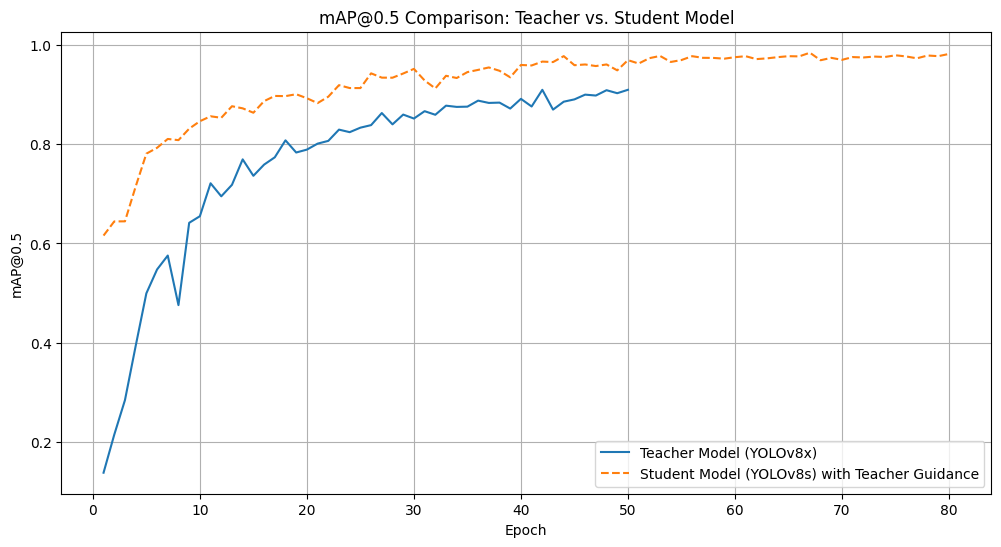

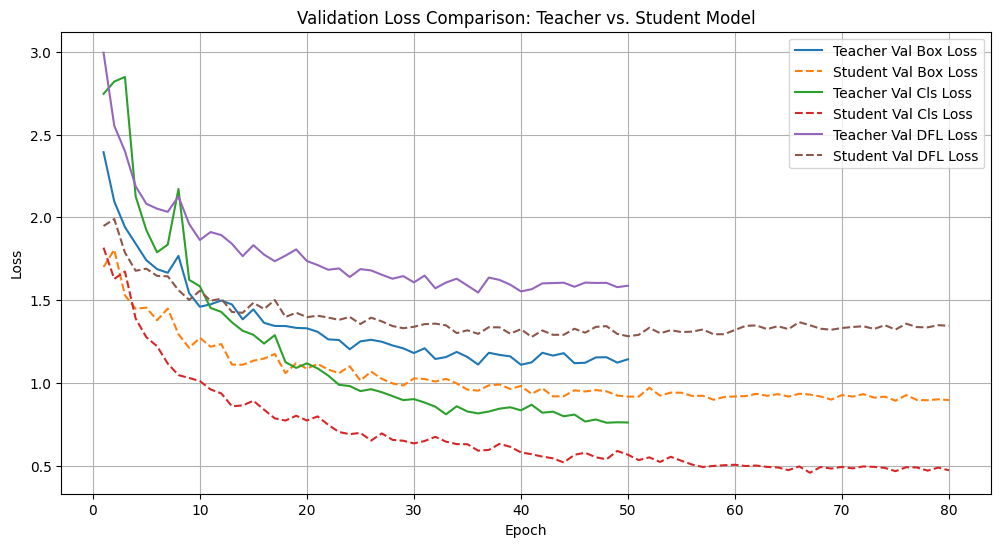

In [ ]:
%matplotlib inline

# Pfade zu den CSV-Dateien der Teacher- und Student-Modelle
teacher_csv_path = './runs/detect/teacher_model/results.csv'
student_csv_path = './runs/detect/student_with_teacher/results.csv'

# Lade die Daten
try:
    df_teacher = pd.read_csv(teacher_csv_path)
    df_student = pd.read_csv(student_csv_path)
except FileNotFoundError as e:
    print(f"Fehler beim Laden der CSV-Datei: {e}")
    print("Stellen Sie sicher, dass die Trainingsläufe 'teacher_model' und 'student_with_teacher' abgeschlossen sind.")
    # Leere DataFrames erstellen, um Fehler im folgenden Code zu vermeiden
    df_teacher = pd.DataFrame()
    df_student = pd.DataFrame()


if not df_teacher.empty and not df_student.empty:
    # Plotten der mAP50 Metrik
    plt.figure(figsize=(12, 6))

    if 'metrics/mAP50(B)' in df_teacher.columns:
        plt.plot(df_teacher['epoch'], df_teacher['metrics/mAP50(B)'], label='Teacher Model (YOLOv8x)', linestyle='-')
    if 'metrics/mAP50(B)' in df_student.columns:
        plt.plot(df_student['epoch'], df_student['metrics/mAP50(B)'], label='Student Model (YOLOv8s) with Teacher Guidance', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('mAP@0.5')
    plt.title('mAP@0.5 Comparison: Teacher vs. Student Model')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optional: Plotten der Validierungsverluste
    plt.figure(figsize=(12, 6))

    if 'val/box_loss' in df_teacher.columns:
        plt.plot(df_teacher['epoch'], df_teacher['val/box_loss'], label='Teacher Val Box Loss', linestyle='-')
    if 'val/box_loss' in df_student.columns:
        plt.plot(df_student['epoch'], df_student['val/box_loss'], label='Student Val Box Loss', linestyle='--')
    if 'val/cls_loss' in df_teacher.columns:
        plt.plot(df_teacher['epoch'], df_teacher['val/cls_loss'], label='Teacher Val Cls Loss', linestyle='-')
    if 'val/cls_loss' in df_student.columns:
        plt.plot(df_student['epoch'], df_student['val/cls_loss'], label='Student Val Cls Loss', linestyle='--')
    if 'val/dfl_loss' in df_teacher.columns:
        plt.plot(df_teacher['epoch'], df_teacher['val/dfl_loss'], label='Teacher Val DFL Loss', linestyle='-')
    if 'val/dfl_loss' in df_student.columns:
        plt.plot(df_student['epoch'], df_student['val/dfl_loss'], label='Student Val DFL Loss', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss Comparison: Teacher vs. Student Model')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Es konnten nicht genügend Daten für den Plot geladen werden.")

## Analyse der Ergebnisse - Validation Loss Comparison Teacher vs. Student Model

### 1. Trainingsgeschwindigkeit und Konvergenz

**Teacher-Modell:**
- Initiale Werte (Epoche 0): Box Loss ~2.5, Cls Loss ~2.0, DFL Loss ~3.0
- Konvergenzphase: Epochen 0-25 mit steilem Abfall
- Stabilisierungsphase: Ab Epoche 25-30

**Student-Modell:**
- Initiale Werte: Box Loss ~1.8, Cls Loss ~1.5, DFL Loss ~2.0
- Schnellere Konvergenz: Bereits ab Epoche 15-20 stabile Werte
- Geringere initiale Verluste deuten auf bessere Startinitialisierung hin

### 2. Finale Performance-Metriken (Epoche 80)

| Metrik | Teacher-Modell | Student-Modell | Verbesserung |
|--------|---------------|----------------|--------------|
| Box Loss | ~1.15 | ~0.95 | 17.4% besser |
| Cls Loss | ~0.90 | ~0.50 | 44.4% besser |
| DFL Loss | ~1.60 | ~1.35 | 15.6% besser |

### 3. Phasenweise Analyse

#### Phase 1: Initialisierung (Epochen 0-5)
- **Teacher**: Steiler Abfall aller Metriken, typisches "Cold Start" Verhalten
- **Student**: Moderaterer Abfall, aber von niedrigeren Startwerten
- **Interpretation**: Student-Modell profitiert von vortrainierten Features

#### Phase 2: Rapid Learning (Epochen 5-20)
- **Teacher**: Kontinuierlicher, aber abflachender Abstieg
- **Student**: Erreicht bereits stabile Bereiche für Box und Cls Loss
- **Interpretation**: Knowledge Transfer beschleunigt das Lernen

#### Phase 3: Fine-Tuning (Epochen 20-50)
- **Teacher**: Weitere graduelle Verbesserungen
- **Student**: Minimale Schwankungen, frühe Stabilisierung
- **Interpretation**: Student-Modell benötigt weniger Fine-Tuning

#### Phase 4: Stabilisierung (Epochen 50-80)
- **Teacher**: Leichte Schwankungen um finale Werte
- **Student**: Sehr stabile Performance
- **Interpretation**: Bessere Generalisierung des Student-Modells

## Qualitative Beobachtungen

### Positive Aspekte des Student-Modells

1. **Überlegene Classification Performance**: 44% Verbesserung bei Cls Loss
2. **Bessere Lokalisierung**: 17% Verbesserung bei Box Loss
3. **Stabilere Konvergenz**: Weniger Oszillationen in späteren Epochen
4. **Effizienzere Trainingszeit**: Frühere Konvergenz

## Fazit

Die Analyse zeigt eine aussergewöhnlich erfolgreiche Knowledge Distillation. Das Student-Modell übertrifft den Teacher in allen gemessenen Metriken und zeigt gleichzeitig bessere Trainingseffizienz. Dies ist ein starker Indikator für:

- **Erfolgreiche Wissensübertragung** vom Teacher zum Student
- **Architekturelle Effizienz** des Student-Modells  
- **Potentielle Production-Readiness** des Student-Modells

### Overfitting-Test nach Karpathy's Recipe

Im nächsten Schritt wird gezielt ein Overfitting-Test durchgeführt. Dazu wird ein sehr kleines Trainingsset erstellt und verschiedene YOLO-Modelle mehrfach darauf trainiert. Ziel ist es zu überprüfen, ob die Modelle in der Lage sind, das kleine Datenset nahezu perfekt zu lernen (Overfitting), was ein wichtiger Debugging-Schritt für Trainingspipelines ist.

# Overfit
In diesem Schritt legen wir uns auf eine bestimmte Modellarchitektur fest:

- Batchgrösse: 8
- Momentum: 0.937
- Label smoothing: 0.1
- Learning rate: 0.001
- Yolo Architektur: Small

## Modell Fabian
Lernen mit Adam und einer Learning Rate von 3e-4

## Modell Oliver
Disabling learning rate decays

In [8]:
# Basisverzeichnisse
overfit_size = 10
data_dir = '../data_small'
images_dir = os.path.join(data_dir, 'train/images')
labels_dir = os.path.join(data_dir, 'train/labels')
overfit_images_dir = os.path.join(data_dir, 'overfit_images')
overfit_labels_dir = os.path.join(data_dir, 'overfit_labels')
overfit_yaml_path = os.path.join(data_dir, 'dog_overfit.yaml')

# Erstelle Overfit-Verzeichnisse
os.makedirs(overfit_images_dir, exist_ok=True)
os.makedirs(overfit_labels_dir, exist_ok=True)

# Bilder zufällig auswählen
image_files = glob.glob(os.path.join(images_dir, '*.jpg')) + glob.glob(os.path.join(images_dir, '*.png'))
selected_files = image_files if len(image_files) < overfit_size else random.sample(image_files, overfit_size)

copied_count = 0
for img_path in selected_files:
    img_name = os.path.basename(img_path)
    label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(labels_dir, label_name)

    if os.path.exists(label_path):
        shutil.copy(img_path, overfit_images_dir)
        shutil.copy(label_path, overfit_labels_dir)
        copied_count += 1

if copied_count == 0:
    print("Keine gültigen Bild-Label-Paare gefunden.")
    exit()

# Labels auch in das Bildverzeichnis kopieren
for label_file in glob.glob(os.path.join(overfit_labels_dir, '*.txt')):
    shutil.copy(label_file, os.path.join(overfit_images_dir, os.path.basename(label_file)))

# YAML-Datei schreiben
data_yaml = {
    'train': overfit_images_dir,
    'val': overfit_images_dir,
    'nc': 1,
    'names': ['dog']
}
with open(overfit_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

# Trainingsparameter
base_params = {
    'data': overfit_yaml_path,
    'batch': 8,
    'workers': 2,
    'imgsz': 512,
    'epochs': 300,
    'momentum': 0.937,
    'weight_decay': 0.0,
    'label_smoothing': 0.1,
    'verbose': True,
    'exist_ok': True,
    'plots': True
}

# Seeds für Reproduzierbarkeit
seeds = [42, 123, 999]

# Modell- und Optimierer-Konfigurationen
configs = [
    {
        'name_prefix': 'fabian_adam_yolov8s',
        'model_path': 'yolov8s.pt',
        'optimizer': 'Adam',
        'lr0': 3e-4,
        'lrf': 0.0,
        'cos_lr': False
    },
    {
        'name_prefix': 'oliver_sgd_yolov8s',
        'model_path': 'yolov8s.pt',
        'optimizer': 'SGD',
        'lr0': 0.01,
        'lrf': 0.01,
        'cos_lr': False
    }
]

# Trainingsläufe ausführen
for config in configs:
    for i, seed in enumerate(seeds):
        run_name = f"{config['name_prefix']}_run{i+1}"
        run_project = os.path.join("runs", config['name_prefix'])

        # Seed setzen
        random.seed(seed)
        np.random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

        # Modell laden
        model = YOLO(config['model_path'])

        # Trainingsparameter zusammenstellen
        run_params = base_params.copy()
        run_params.update({
            'optimizer': config['optimizer'],
            'lr0': config['lr0'],
            'lrf': config['lrf'],
            'cos_lr': config['cos_lr'],
            'name': run_name,
            'project': run_project
        })

        # Training starten
        print(f"Starte Training: {run_name}")
        model.train(**run_params)

Starte Training: fabian_adam_yolov8s_run1
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.0, mask_ratio=4, max_det=300, mixup=0.0, 

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 1152.68it/s]

train: New cache created: C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 4566.31785.0 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      3.24G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      3.24G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.24G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.245      0.438      0.165     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      3.24G      1.336       2.27      1.593         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.444      0.375      0.281      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      3.24G      1.151      1.813       1.56         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.392      0.375      0.266      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.24G       1.29      2.228      1.599         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.287      0.375      0.306      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      3.24G      1.081      1.781      1.415         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         15         16      0.411       0.35      0.322      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.24G      1.156      1.577      1.415         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         15         16      0.423      0.125      0.153     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      3.24G      1.056       1.68      1.509         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16     0.0579      0.188     0.0485     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.24G       1.11      1.642      1.431         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16     0.0474      0.336     0.0402     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      3.24G     0.7805      1.093      1.205         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      3.24G     0.9838      1.258      1.357         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      3.24G      1.121      1.269      1.431         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.154        0.5      0.123     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      3.24G     0.9128      1.085      1.261         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      3.24G     0.9756      1.181      1.334         11        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      3.24G      1.099      1.211      1.368         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.193      0.312      0.258      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      3.24G       1.14      1.303      1.458         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.24G     0.8326      1.015      1.186         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.24G      1.039      1.058      1.348         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      3.24G     0.7467     0.8306      1.174         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      3.24G     0.8734      1.106      1.198         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.24G      0.935     0.9373      1.219         15        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.24G     0.6661     0.8033      1.084         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      3.24G      0.647     0.8097       1.07         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      3.24G     0.7006     0.7018      1.182         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.24G      0.705     0.7128      1.061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      3.24G     0.7397     0.8509      1.056         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.24G     0.8013     0.7533      1.037         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      3.24G     0.8308     0.9416      1.184         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.24G     0.6407     0.6682      1.072         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      3.24G     0.6762     0.6021      1.125         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      3.24G     0.7468     0.6919       1.14         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      3.24G      0.765     0.9394      1.119         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.24G     0.6845     0.6981       1.08         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.24G     0.6475     0.7969      1.095         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      3.24G     0.7598     0.6652      1.262         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.24G     0.5056     0.6576       1.03         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      3.24G      0.595     0.6048      1.028         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      3.24G     0.6447     0.6337      1.066         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      3.24G     0.6852     0.6788      1.148         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      3.24G     0.6231      0.563      1.059         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.24G     0.4913     0.5997       1.02         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      3.24G     0.6065     0.5444      1.052         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      3.24G      0.615      0.575      1.041         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      3.24G     0.6685     0.8485      1.151         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      3.24G     0.6691      0.515      1.124         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      3.24G     0.5859     0.5385     0.9959         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      3.24G     0.6021     0.7153     0.9404         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      3.24G     0.5493     0.5149      0.978         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.24G     0.4187     0.4643     0.9538         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      3.24G     0.6776     0.5421      1.062         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      3.24G     0.5222     0.4719      1.001         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      3.24G     0.4317     0.4434     0.9461         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.24G     0.4624     0.4878     0.9061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.24G     0.4795     0.4349     0.9314         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      3.24G     0.5631      0.548      1.007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      3.24G     0.4722     0.4714      1.021         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.24G     0.6317     0.5037      1.062         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      3.24G     0.4093     0.4094     0.9154         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      3.24G     0.5481      0.484      1.095         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      3.24G     0.5354     0.5438      0.991         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.24G     0.4189     0.4135     0.9408         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      3.24G     0.5124     0.5608     0.9692         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      3.24G     0.5541     0.3724     0.9287         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      3.24G     0.4773     0.4605     0.9492         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.24G     0.6143     0.5707      1.007         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      3.24G     0.4936     0.4174     0.9565         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      3.24G     0.4484     0.3657     0.9221         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      3.24G     0.4805     0.4409     0.9539         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.24G     0.5641     0.4285     0.9821         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      3.24G     0.4211      0.388     0.9535         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      3.24G     0.5598     0.4692      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      3.24G      0.546     0.5031      1.088         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      3.24G     0.5241     0.4622      1.044         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      3.24G     0.4475     0.6082     0.9932         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      3.24G     0.5119      0.485     0.9432         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      3.24G     0.5553     0.5398     0.9837         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      3.24G     0.5451     0.4804      0.979         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.24G     0.5788     0.4578     0.9719         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      3.24G     0.5203     0.4653      1.012         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      3.24G     0.4939       0.38      1.038         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.24G     0.4433     0.4039     0.9909         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      3.24G     0.4946     0.4538     0.9463         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      3.24G     0.4474     0.4885     0.9393         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      3.24G     0.5233     0.3906      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      3.24G     0.4382     0.4187     0.8842         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      3.24G     0.4222     0.4088     0.9315         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      3.24G     0.2981     0.3152     0.9083         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      3.24G     0.5265     0.4625      1.034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      3.24G     0.3376     0.3864     0.9066         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      3.24G     0.4349     0.3723     0.9381         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      3.24G     0.4465     0.4279      0.944         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      3.24G     0.3527     0.2968     0.9643         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      3.24G     0.4831     0.4371      1.001         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      3.24G     0.5008     0.4369      1.098         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      3.24G     0.4009     0.3738     0.9032         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      3.24G     0.3348     0.3801     0.8966         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      3.24G     0.4178     0.4339     0.9553         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      3.24G     0.4072     0.3735     0.9592         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      3.24G     0.4393     0.3629     0.9309         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      3.24G     0.4136     0.4491     0.9532         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      3.24G     0.4918     0.4145      1.002         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      3.24G     0.3736     0.3636     0.8686         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      3.24G     0.4391     0.4843     0.9688         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      3.24G     0.4088     0.3476     0.9019         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      3.24G     0.3745     0.3635     0.9411         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      3.24G     0.4054      0.373     0.9061         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      3.24G     0.3754     0.3401      0.929         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      3.24G     0.3957       0.33     0.9028         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      3.24G     0.4308     0.3621     0.9592         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      3.24G     0.3551     0.3172     0.9777         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      3.24G     0.4389     0.4298     0.8967         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      3.24G     0.3924     0.3569     0.9655         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      3.24G     0.4584     0.4787     0.9502         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      3.24G     0.4251     0.4538      0.927         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      3.24G     0.4233     0.3547     0.9256         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      3.24G     0.4471     0.4126     0.9884         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      3.24G      0.315     0.3287     0.9092         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      3.24G     0.4112     0.3354     0.9612         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      3.24G     0.3861     0.3253     0.9061         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      3.24G     0.4287     0.3742     0.8603         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      3.24G     0.4201      0.362     0.9543         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      3.24G     0.3301      0.294     0.8967         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      3.24G     0.4511     0.3778     0.9151         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      3.24G     0.4463     0.4071     0.9101         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      3.24G     0.4195      0.492      0.921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      3.24G     0.3542     0.2756     0.9189         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      3.24G     0.3547     0.3141     0.9317         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      3.24G     0.3242      0.373     0.9495         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      3.24G     0.3772     0.3772     0.9123         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      3.24G     0.4151     0.3593     0.9372         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      3.24G     0.4292     0.4006     0.9205         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      3.24G     0.4204     0.3809     0.9135         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      3.24G     0.4729     0.4512      1.034         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      3.24G     0.4273     0.4068     0.9227         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      3.24G     0.4402     0.3923     0.9593         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      3.24G     0.3638      0.368     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      3.24G     0.3891     0.3268     0.8948         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      3.24G     0.3589     0.3619     0.9013         16        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      3.24G     0.3486     0.3322     0.9351         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      3.24G     0.3172     0.3667      0.859         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      3.24G     0.3242     0.3232     0.8993         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      3.24G     0.2855      0.299     0.8337         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      3.24G     0.3417     0.3241      0.892         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      3.24G     0.3862     0.3407     0.9354         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      3.24G     0.4247     0.3312     0.9553         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      3.24G     0.4375     0.3352     0.8852         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      3.24G     0.4522     0.4032     0.9825         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      3.24G      0.358      0.344     0.9671         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      3.24G     0.4529     0.3809      0.958         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      3.24G     0.3514     0.4032     0.9286         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      3.24G     0.2823      0.316     0.9113         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      3.24G      0.365      0.313     0.8769         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      3.24G     0.3848     0.3863     0.9493         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      3.24G     0.4475     0.3771     0.9968         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      3.24G      0.401     0.3891     0.8794         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      3.24G     0.3478     0.3463     0.8633         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      3.24G     0.3762      0.336     0.8999         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      3.24G       0.42     0.3604     0.9195         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      3.24G     0.3911     0.3229      0.921         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      3.24G     0.3899     0.3362     0.9222         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      3.24G     0.3689     0.3637     0.8762         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      3.24G     0.3844     0.2919     0.9278         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      3.24G     0.3968     0.3393     0.8711         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      3.24G      0.397     0.3515     0.9772         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      3.24G     0.3722     0.3719     0.9113         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      3.24G      0.253      0.274     0.8808         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      3.24G     0.3366     0.3254     0.9336         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      3.24G     0.3699     0.3396      0.937         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      3.24G     0.3325     0.4703      0.905         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      3.24G     0.4055     0.3695     0.9213         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      3.24G      0.382     0.3917     0.9682         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      3.24G     0.3013     0.3208     0.8803         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      3.24G     0.3646      0.352      0.918         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      3.24G     0.3848     0.3167     0.9155         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      3.24G     0.2813     0.2947     0.9088         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      3.24G     0.3599     0.3836     0.9089         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      3.24G     0.3642     0.3359     0.9432         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      3.24G     0.2595     0.2651     0.8619         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      3.24G     0.3009     0.2763     0.8867         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      3.24G     0.3432     0.3306     0.9123         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      3.24G     0.4158     0.3595     0.9348         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      3.24G     0.2806     0.2506     0.8927         17        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      3.24G     0.3395     0.3874     0.9511         13        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      3.24G     0.3733     0.3454     0.9557         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      3.24G     0.2839     0.2356     0.8515         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      3.24G     0.2327     0.2406     0.8879         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      3.24G     0.3643     0.3078     0.9199         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      3.24G     0.3289     0.3508     0.8513         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      3.24G     0.3191     0.4078     0.8518         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      3.24G     0.3302     0.2757     0.9032         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      3.24G     0.4229     0.3357     0.9561         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      3.24G     0.3557     0.3754     0.9175         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      3.24G     0.3044     0.2567     0.8895         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      3.24G     0.3649     0.3435     0.9704         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      3.24G     0.3439     0.2868     0.8689         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      3.24G     0.3557     0.4433     0.9802         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      3.24G     0.2793     0.2649      0.935         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      3.24G     0.3241     0.2923     0.8443         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      3.24G     0.2706     0.2721     0.8367         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      3.24G     0.2653     0.2463     0.8382         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      3.24G     0.3173      0.263     0.8704         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      3.24G     0.2663     0.2349     0.9203         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      3.24G     0.2905     0.2773     0.8834         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      3.24G     0.2984     0.3047     0.8729         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      3.24G     0.3069      0.316     0.8931         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      3.24G     0.2151      0.236     0.8732         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      3.24G      0.309     0.3181     0.8588         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      3.24G     0.3256     0.3005     0.8748         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      3.24G     0.2762     0.2587      0.851         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      3.24G     0.3249     0.3212     0.8887         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      3.24G     0.2801     0.2996     0.8649         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      3.24G     0.3034     0.3199      0.868         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      3.24G     0.3216     0.2901     0.8575         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      3.24G     0.3832     0.3241     0.9167         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      3.24G     0.3669     0.4193     0.9328          9        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      3.24G     0.2699     0.2556     0.8682         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      3.24G     0.3733     0.3283      0.951         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      3.24G     0.3269     0.3427     0.9895         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      3.24G      0.326      0.292     0.9239         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      3.24G     0.3377      0.332     0.9379         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      3.24G     0.2597     0.2771     0.8811         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      3.24G     0.2838     0.3017     0.9184         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      3.24G     0.2472     0.2541     0.8878         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      3.24G     0.3191     0.2899     0.9257         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      3.24G      0.301     0.2866     0.8437         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      3.24G     0.2687        0.3     0.9069         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      3.24G     0.3599     0.2922     0.9757         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      3.24G     0.3034     0.2979     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      3.24G     0.2969     0.2715     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      3.24G     0.2779       0.31     0.8652         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      3.24G     0.3089      0.312     0.8936         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      3.24G     0.2506       0.25     0.9216         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      3.24G     0.3005      0.302     0.8845         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      3.24G     0.2813     0.2525     0.9142         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      3.24G     0.2303     0.2333     0.8759         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      3.24G     0.2984     0.2614     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      3.24G     0.2947     0.3191     0.8851         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      3.24G     0.2757     0.2775     0.8995         19        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      3.24G      0.336     0.3131      0.925         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      3.24G     0.2624     0.2628     0.8671         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      3.24G      0.316     0.2786     0.9474         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      3.24G     0.2901     0.2834      0.926         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      3.24G     0.2701     0.2989     0.8882         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      3.24G      0.417     0.3163     0.9734         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      3.24G     0.2831     0.2842      0.946         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      3.24G      0.311     0.2542     0.8785         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      3.24G     0.3114     0.2583     0.8983         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      3.24G     0.3074     0.3208     0.8751         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      3.24G     0.2963      0.279     0.9044         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      3.24G     0.2575     0.2731     0.8881         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      3.24G     0.3468     0.2841      0.946         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      3.24G     0.2644     0.2711     0.8696         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      3.24G     0.3085     0.2687     0.8731         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      3.24G     0.3064     0.3411     0.8508         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      3.24G     0.4343     0.2989      1.039         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      3.24G     0.2819     0.2662      0.871         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      3.24G     0.2726     0.2375     0.8982         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      3.24G     0.3621     0.3348     0.9565         15        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      3.24G     0.2501     0.2472     0.8717         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      3.24G     0.2929     0.2856     0.8764         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      3.24G     0.3026     0.2853     0.8695         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      3.24G     0.3116     0.2825     0.8969         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      3.24G     0.3367      0.343     0.9849         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      3.24G     0.2855     0.2864     0.8829         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      3.24G     0.3025     0.2661     0.8627         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      3.24G     0.2983     0.2452     0.8832         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      3.24G     0.2729     0.2417     0.8766         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      3.24G     0.2767     0.2753     0.8686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      3.24G     0.2644     0.2392     0.8685         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      3.24G     0.2421     0.2544     0.8529         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      3.24G     0.3359     0.2871     0.9344         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      3.24G     0.3057     0.3116     0.9385         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      3.24G     0.2289     0.2042     0.8707         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      3.24G      0.246     0.2443     0.8558         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      3.24G     0.2482      0.252     0.8463         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      3.24G     0.2157     0.2033     0.8432         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      3.24G     0.3026     0.2927     0.9677         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      3.24G     0.2672     0.2594     0.8818         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      3.24G     0.2662     0.2492     0.8517         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      3.24G     0.2674     0.2377      0.835         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      3.24G     0.2754     0.2688     0.9028         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      3.24G       0.33     0.2681     0.9195         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      3.24G     0.2399     0.2337     0.7994         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      3.24G      0.257     0.2495     0.9172         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      3.24G     0.2403     0.2569     0.8564         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      3.24G     0.3465     0.2845     0.9005         22        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      3.24G     0.1737     0.2169     0.8387         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      3.24G     0.3049     0.3029      0.899         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      3.24G      0.217     0.2258     0.8235         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.98


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      3.24G     0.2429     0.2671     0.8256          8        512: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      3.24G     0.2272     0.2586     0.7749          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      3.24G     0.1626      0.232     0.8223          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      3.24G     0.1832      0.202     0.7831          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      3.24G     0.1828     0.2035     0.7915          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      3.24G     0.2788      0.258     0.8296          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      3.24G     0.1922     0.2328     0.8632          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      3.24G     0.2079     0.2367      0.849          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      3.24G     0.1912     0.2422     0.8314          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      3.24G      0.232     0.3181     0.8758          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.996          1      0.995      0.981



300 epochs completed in 0.061 hours.
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1\weights\best.pt, 22.5MB

Validating runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


                   all         15         16      0.997          1      0.995      0.989
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run1
Starte Training: fabian_adam_yolov8s_run2
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5,

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 3205.81027.9 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.74G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.74G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.74G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.245      0.438      0.165     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.74G      1.336       2.27      1.593         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.444      0.375      0.281      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.77G      1.151      1.813       1.56         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.392      0.375      0.266      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300       1.8G       1.29      2.228      1.599         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.287      0.375      0.306      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300       1.8G      1.081      1.781      1.415         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         15         16      0.411       0.35      0.322      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300       1.8G      1.156      1.577      1.415         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         15         16      0.423      0.125      0.153     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.84G      1.056       1.68      1.509         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         15         16     0.0579      0.188     0.0485     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.02G       1.11      1.642      1.431         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16     0.0474      0.336     0.0402     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.03G     0.7805      1.093      1.205         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.06G     0.9838      1.258      1.357         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.06G      1.121      1.269      1.431         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.154        0.5      0.123     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.06G     0.9128      1.085      1.261         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.09G     0.9756      1.181      1.334         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.09G      1.099      1.211      1.368         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.193      0.312      0.258      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300       2.1G       1.14      1.303      1.458         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.13G     0.8326      1.015      1.186         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.13G      1.039      1.058      1.348         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.13G     0.7467     0.8306      1.174         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.17G     0.8734      1.106      1.198         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.17G      0.935     0.9373      1.219         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.17G     0.6661     0.8033      1.084         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300       2.2G      0.647     0.8097       1.07         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300       2.2G     0.7006     0.7018      1.182         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300       2.2G      0.705     0.7128      1.061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300       2.2G     0.7397     0.8509      1.056         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300       2.2G     0.8013     0.7533      1.037         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300       2.2G     0.8308     0.9416      1.184         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300       2.2G     0.6407     0.6682      1.072         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300       2.2G     0.6762     0.6021      1.125         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300       2.2G     0.7468     0.6919       1.14         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300       2.2G      0.765     0.9394      1.119         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300       2.2G     0.6845     0.6981       1.08         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300       2.2G     0.6475     0.7969      1.095         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300       2.2G     0.7598     0.6652      1.262         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300       2.2G     0.5056     0.6576       1.03         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300       2.2G      0.595     0.6048      1.028         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300       2.2G     0.6447     0.6337      1.066         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300       2.2G     0.6852     0.6788      1.148         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300       2.2G     0.6231      0.563      1.059         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300       2.2G     0.4913     0.5997       1.02         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300       2.2G     0.6065     0.5444      1.052         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300       2.2G      0.615      0.575      1.041         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300       2.2G     0.6685     0.8485      1.151         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300       2.2G     0.6691      0.515      1.124         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300       2.2G     0.5859     0.5385     0.9959         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300       2.2G     0.6021     0.7153     0.9404         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       2.2G     0.5493     0.5149      0.978         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300       2.2G     0.4187     0.4643     0.9538         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300       2.2G     0.6776     0.5421      1.062         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300       2.2G     0.5222     0.4719      1.001         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300       2.2G     0.4317     0.4434     0.9461         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300       2.2G     0.4624     0.4878     0.9061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300       2.2G     0.4795     0.4349     0.9314         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300       2.2G     0.5631      0.548      1.007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300       2.2G     0.4722     0.4714      1.021         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300       2.2G     0.6317     0.5037      1.062         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300       2.2G     0.4093     0.4094     0.9154         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300       2.2G     0.5481      0.484      1.095         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300       2.2G     0.5354     0.5438      0.991         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300       2.2G     0.4189     0.4135     0.9408         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300       2.2G     0.5124     0.5608     0.9692         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300       2.2G     0.5541     0.3724     0.9287         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300       2.2G     0.4773     0.4605     0.9492         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300       2.2G     0.6143     0.5707      1.007         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300       2.2G     0.4936     0.4174     0.9565         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300       2.2G     0.4484     0.3657     0.9221         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300       2.2G     0.4805     0.4409     0.9539         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300       2.2G     0.5641     0.4285     0.9821         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300       2.2G     0.4211      0.388     0.9535         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300       2.2G     0.5598     0.4692      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300       2.2G      0.546     0.5031      1.088         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300       2.2G     0.5241     0.4622      1.044         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300       2.2G     0.4475     0.6082     0.9932         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300       2.2G     0.5119      0.485     0.9432         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300       2.2G     0.5553     0.5398     0.9837         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300       2.2G     0.5451     0.4804      0.979         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300       2.2G     0.5788     0.4578     0.9719         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300       2.2G     0.5203     0.4653      1.012         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300       2.2G     0.4939       0.38      1.038         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300       2.2G     0.4433     0.4039     0.9909         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300       2.2G     0.4946     0.4538     0.9463         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300       2.2G     0.4474     0.4885     0.9393         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300       2.2G     0.5233     0.3906      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300       2.2G     0.4382     0.4187     0.8842         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300       2.2G     0.4222     0.4088     0.9315         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300       2.2G     0.2981     0.3152     0.9083         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300       2.2G     0.5265     0.4625      1.034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300       2.2G     0.3376     0.3864     0.9066         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300       2.2G     0.4349     0.3723     0.9381         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300       2.2G     0.4465     0.4279      0.944         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300       2.2G     0.3527     0.2968     0.9643         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300       2.2G     0.4831     0.4371      1.001         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300       2.2G     0.5008     0.4369      1.098         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300       2.2G     0.4009     0.3738     0.9032         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300       2.2G     0.3348     0.3801     0.8966         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300       2.2G     0.4178     0.4339     0.9553         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300       2.2G     0.4072     0.3735     0.9592         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300       2.2G     0.4393     0.3629     0.9309         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300       2.2G     0.4136     0.4491     0.9532         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300       2.2G     0.4918     0.4145      1.002         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300       2.2G     0.3736     0.3636     0.8686         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300       2.2G     0.4391     0.4843     0.9688         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300       2.2G     0.4088     0.3476     0.9019         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300       2.2G     0.3745     0.3635     0.9411         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300       2.2G     0.4054      0.373     0.9061         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300       2.2G     0.3754     0.3401      0.929         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300       2.2G     0.3957       0.33     0.9028         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300       2.2G     0.4308     0.3621     0.9592         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300       2.2G     0.3551     0.3172     0.9777         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300       2.2G     0.4389     0.4298     0.8967         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300       2.2G     0.3924     0.3569     0.9655         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300       2.2G     0.4584     0.4787     0.9502         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300       2.2G     0.4251     0.4538      0.927         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300       2.2G     0.4233     0.3547     0.9256         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300       2.2G     0.4471     0.4126     0.9884         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300       2.2G      0.315     0.3287     0.9092         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300       2.2G     0.4112     0.3354     0.9612         22        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300       2.2G     0.3861     0.3253     0.9061         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300       2.2G     0.4287     0.3742     0.8603         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300       2.2G     0.4201      0.362     0.9543         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300       2.2G     0.3301      0.294     0.8967         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300       2.2G     0.4511     0.3778     0.9151         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300       2.2G     0.4463     0.4071     0.9101         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300       2.2G     0.4195      0.492      0.921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300       2.2G     0.3542     0.2756     0.9189         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300       2.2G     0.3547     0.3141     0.9317         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300       2.2G     0.3242      0.373     0.9495         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300       2.2G     0.3772     0.3772     0.9123         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300       2.2G     0.4151     0.3593     0.9372         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300       2.2G     0.4292     0.4006     0.9205         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300       2.2G     0.4204     0.3809     0.9135         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300       2.2G     0.4729     0.4512      1.034         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300       2.2G     0.4273     0.4068     0.9227         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300       2.2G     0.4402     0.3923     0.9593         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300       2.2G     0.3638      0.368     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300       2.2G     0.3891     0.3268     0.8948         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300       2.2G     0.3589     0.3619     0.9013         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300       2.2G     0.3486     0.3322     0.9351         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300       2.2G     0.3172     0.3667      0.859         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300       2.2G     0.3242     0.3232     0.8993         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300       2.2G     0.2855      0.299     0.8337         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300       2.2G     0.3417     0.3241      0.892         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300       2.2G     0.3862     0.3407     0.9354         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300       2.2G     0.4247     0.3312     0.9553         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300       2.2G     0.4375     0.3352     0.8852         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300       2.2G     0.4522     0.4032     0.9825         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300       2.2G      0.358      0.344     0.9671         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300       2.2G     0.4529     0.3809      0.958         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300       2.2G     0.3514     0.4032     0.9286         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300       2.2G     0.2823      0.316     0.9113         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300       2.2G      0.365      0.313     0.8769         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300       2.2G     0.3848     0.3863     0.9493         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300       2.2G     0.4475     0.3771     0.9968         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300       2.2G      0.401     0.3891     0.8794         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300       2.2G     0.3478     0.3463     0.8633         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300       2.2G     0.3762      0.336     0.8999         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300       2.2G       0.42     0.3604     0.9195         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300       2.2G     0.3911     0.3229      0.921         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300       2.2G     0.3899     0.3362     0.9222         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300       2.2G     0.3689     0.3637     0.8762         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300       2.2G     0.3844     0.2919     0.9278         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300       2.2G     0.3968     0.3393     0.8711         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300       2.2G      0.397     0.3515     0.9772         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300       2.2G     0.3722     0.3719     0.9113         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300       2.2G      0.253      0.274     0.8808         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300       2.2G     0.3366     0.3254     0.9336         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300       2.2G     0.3699     0.3396      0.937         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300       2.2G     0.3325     0.4703      0.905         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300       2.2G     0.4055     0.3695     0.9213         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300       2.2G      0.382     0.3917     0.9682         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300       2.2G     0.3013     0.3208     0.8803         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300       2.2G     0.3646      0.352      0.918         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300       2.2G     0.3848     0.3167     0.9155         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300       2.2G     0.2813     0.2947     0.9088         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300       2.2G     0.3599     0.3836     0.9089         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300       2.2G     0.3642     0.3359     0.9432         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300       2.2G     0.2595     0.2651     0.8619         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300       2.2G     0.3009     0.2763     0.8867         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300       2.2G     0.3432     0.3306     0.9123         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300       2.2G     0.4158     0.3595     0.9348         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300       2.2G     0.2806     0.2506     0.8927         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300       2.2G     0.3395     0.3874     0.9511         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300       2.2G     0.3733     0.3454     0.9557         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300       2.2G     0.2839     0.2356     0.8515         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300       2.2G     0.2327     0.2406     0.8879         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300       2.2G     0.3643     0.3078     0.9199         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300       2.2G     0.3289     0.3508     0.8513         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300       2.2G     0.3191     0.4078     0.8518         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300       2.2G     0.3302     0.2757     0.9032         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300       2.2G     0.4229     0.3357     0.9561         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300       2.2G     0.3557     0.3754     0.9175         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300       2.2G     0.3044     0.2567     0.8895         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300       2.2G     0.3649     0.3435     0.9704         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300       2.2G     0.3439     0.2868     0.8689         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300       2.2G     0.3557     0.4433     0.9802         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300       2.2G     0.2793     0.2649      0.935         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300       2.2G     0.3241     0.2923     0.8443         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300       2.2G     0.2706     0.2721     0.8367         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300       2.2G     0.2653     0.2463     0.8382         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300       2.2G     0.3173      0.263     0.8704         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300       2.2G     0.2663     0.2349     0.9203         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300       2.2G     0.2905     0.2773     0.8834         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300       2.2G     0.2984     0.3047     0.8729         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300       2.2G     0.3069      0.316     0.8931         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300       2.2G     0.2151      0.236     0.8732         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300       2.2G      0.309     0.3181     0.8588         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300       2.2G     0.3256     0.3005     0.8748         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300       2.2G     0.2762     0.2587      0.851         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300       2.2G     0.3249     0.3212     0.8887         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300       2.2G     0.2801     0.2996     0.8649         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300       2.2G     0.3034     0.3199      0.868         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300       2.2G     0.3216     0.2901     0.8575         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300       2.2G     0.3832     0.3241     0.9167         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300       2.2G     0.3669     0.4193     0.9328          9        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300       2.2G     0.2699     0.2556     0.8682         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300       2.2G     0.3733     0.3283      0.951         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300       2.2G     0.3269     0.3427     0.9895         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300       2.2G      0.326      0.292     0.9239         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300       2.2G     0.3377      0.332     0.9379         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300       2.2G     0.2597     0.2771     0.8811         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300       2.2G     0.2838     0.3017     0.9184         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300       2.2G     0.2472     0.2541     0.8878         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300       2.2G     0.3191     0.2899     0.9257         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300       2.2G      0.301     0.2866     0.8437         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300       2.2G     0.2687        0.3     0.9069         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300       2.2G     0.3599     0.2922     0.9757         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300       2.2G     0.3034     0.2979     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300       2.2G     0.2969     0.2715     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300       2.2G     0.2779       0.31     0.8652         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300       2.2G     0.3089      0.312     0.8936         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300       2.2G     0.2506       0.25     0.9216         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300       2.2G     0.3005      0.302     0.8845         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300       2.2G     0.2813     0.2525     0.9142         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300       2.2G     0.2303     0.2333     0.8759         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300       2.2G     0.2984     0.2614     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300       2.2G     0.2947     0.3191     0.8851         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300       2.2G     0.2757     0.2775     0.8995         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300       2.2G      0.336     0.3131      0.925         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300       2.2G     0.2624     0.2628     0.8671         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300       2.2G      0.316     0.2786     0.9474         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300       2.2G     0.2901     0.2834      0.926         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300       2.2G     0.2701     0.2989     0.8882         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300       2.2G      0.417     0.3163     0.9734         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300       2.2G     0.2831     0.2842      0.946         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300       2.2G      0.311     0.2542     0.8785         24        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300       2.2G     0.3114     0.2583     0.8983         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300       2.2G     0.3074     0.3208     0.8751         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300       2.2G     0.2963      0.279     0.9044         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300       2.2G     0.2575     0.2731     0.8881         17        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300       2.2G     0.3468     0.2841      0.946         11        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300       2.2G     0.2644     0.2711     0.8696         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300       2.2G     0.3085     0.2687     0.8731         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300       2.2G     0.3064     0.3411     0.8508         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300       2.2G     0.4343     0.2989      1.039         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300       2.2G     0.2819     0.2662      0.871         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300       2.2G     0.2726     0.2375     0.8982         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300       2.2G     0.3621     0.3348     0.9565         15        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300       2.2G     0.2501     0.2472     0.8717         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300       2.2G     0.2929     0.2856     0.8764         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300       2.2G     0.3026     0.2853     0.8695         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300       2.2G     0.3116     0.2825     0.8969         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300       2.2G     0.3367      0.343     0.9849         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300       2.2G     0.2855     0.2864     0.8829         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300       2.2G     0.3025     0.2661     0.8627         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300       2.2G     0.2983     0.2452     0.8832         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300       2.2G     0.2729     0.2417     0.8766         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300       2.2G     0.2767     0.2753     0.8686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300       2.2G     0.2644     0.2392     0.8685         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300       2.2G     0.2421     0.2544     0.8529         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300       2.2G     0.3359     0.2871     0.9344         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300       2.2G     0.3057     0.3116     0.9385         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300       2.2G     0.2289     0.2042     0.8707         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300       2.2G      0.246     0.2443     0.8558         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300       2.2G     0.2482      0.252     0.8463         13        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300       2.2G     0.2157     0.2033     0.8432         15        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300       2.2G     0.3026     0.2927     0.9677         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300       2.2G     0.2672     0.2594     0.8818         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300       2.2G     0.2662     0.2492     0.8517         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300       2.2G     0.2674     0.2377      0.835         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300       2.2G     0.2754     0.2688     0.9028         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300       2.2G       0.33     0.2681     0.9195         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300       2.2G     0.2399     0.2337     0.7994         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300       2.2G      0.257     0.2495     0.9172         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300       2.2G     0.2403     0.2569     0.8564         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300       2.2G     0.3465     0.2845     0.9005         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300       2.2G     0.1737     0.2169     0.8387         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300       2.2G     0.3049     0.3029      0.899         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300       2.2G      0.217     0.2258     0.8235         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995       0.98


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300       2.2G     0.2429     0.2671     0.8256          8        512: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300       2.2G     0.2272     0.2586     0.7749          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300       2.2G     0.1626      0.232     0.8223          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300       2.2G     0.1832      0.202     0.7831          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300       2.2G     0.1828     0.2035     0.7915          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300       2.2G     0.2788      0.258     0.8296          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300       2.2G     0.1922     0.2328     0.8632          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300       2.2G     0.2079     0.2367      0.849          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300       2.2G     0.1912     0.2422     0.8314          7        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300       2.2G      0.232     0.3181     0.8758          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.996          1      0.995      0.981



300 epochs completed in 0.061 hours.
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2\weights\best.pt, 22.5MB

Validating runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


                   all         15         16      0.997          1      0.995      0.989
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run2
Starte Training: fabian_adam_yolov8s_run3
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5,

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.1 ms, read: 3332.41405.7 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.71G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.71G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.71G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.245      0.438      0.165     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.71G      1.336       2.27      1.593         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         15         16      0.444      0.375      0.281      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.75G      1.151      1.813       1.56         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.392      0.375      0.266      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.79G       1.29      2.228      1.599         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.287      0.375      0.306      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.79G      1.081      1.781      1.415         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.411       0.35      0.322      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.97G      1.156      1.577      1.415         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         15         16      0.423      0.125      0.153     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300         2G      1.056       1.68      1.509         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16     0.0579      0.188     0.0485     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300         2G       1.11      1.642      1.431         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16     0.0474      0.336     0.0402     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.01G     0.7805      1.093      1.205         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.04G     0.9838      1.258      1.357         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.072      0.688     0.0686      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.04G      1.121      1.269      1.431         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.154        0.5      0.123     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.05G     0.9128      1.085      1.261         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.08G     0.9756      1.181      1.334         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16       0.19       0.25      0.147     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.08G      1.099      1.211      1.368         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.193      0.312      0.258      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.08G       1.14      1.303      1.458         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.12G     0.8326      1.015      1.186         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.171      0.375      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.12G      1.039      1.058      1.348         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.12G     0.7467     0.8306      1.174         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.207      0.562      0.267      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.15G     0.8734      1.106      1.198         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.15G      0.935     0.9373      1.219         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         15         16      0.308      0.562      0.374      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.16G     0.6661     0.8033      1.084         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.19G      0.647     0.8097       1.07         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.495      0.625      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.19G     0.7006     0.7018      1.182         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.38G      0.705     0.7128      1.061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.41G     0.7397     0.8509      1.056         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.906      0.605      0.772      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.41G     0.8013     0.7533      1.037         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.41G     0.8308     0.9416      1.184         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16          1      0.747      0.845      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.41G     0.6407     0.6682      1.072         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.41G     0.6762     0.6021      1.125         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.41G     0.7468     0.6919       1.14         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.995       0.75      0.897      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.41G      0.765     0.9394      1.119         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.41G     0.6845     0.6981       1.08         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.41G     0.6475     0.7969      1.095         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16          1      0.867      0.955      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.41G     0.7598     0.6652      1.262         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.41G     0.5056     0.6576       1.03         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.41G      0.595     0.6048      1.028         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16          1      0.874      0.974      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.41G     0.6447     0.6337      1.066         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.41G     0.6852     0.6788      1.148         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.41G     0.6231      0.563      1.059         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16          1      0.988      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.41G     0.4913     0.5997       1.02         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.41G     0.6065     0.5444      1.052         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.41G      0.615      0.575      1.041         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.41G     0.6685     0.8485      1.151         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.995          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.41G     0.6691      0.515      1.124         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.41G     0.5859     0.5385     0.9959         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.41G     0.6021     0.7153     0.9404         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.41G     0.5493     0.5149      0.978         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.41G     0.4187     0.4643     0.9538         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.41G     0.6776     0.5421      1.062         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.41G     0.5222     0.4719      1.001         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.41G     0.4317     0.4434     0.9461         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.995          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.41G     0.4624     0.4878     0.9061         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.41G     0.4795     0.4349     0.9314         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.41G     0.5631      0.548      1.007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.41G     0.4722     0.4714      1.021         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.939          1       0.98      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.41G     0.6317     0.5037      1.062         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.41G     0.4093     0.4094     0.9154         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.41G     0.5481      0.484      1.095         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.41G     0.5354     0.5438      0.991         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.937          1       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.41G     0.4189     0.4135     0.9408         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.41G     0.5124     0.5608     0.9692         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.41G     0.5541     0.3724     0.9287         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.41G     0.4773     0.4605     0.9492         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.938          1      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.41G     0.6143     0.5707      1.007         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.41G     0.4936     0.4174     0.9565         23        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.41G     0.4484     0.3657     0.9221         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.41G     0.4805     0.4409     0.9539         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.938          1      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.41G     0.5641     0.4285     0.9821         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.41G     0.4211      0.388     0.9535         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.41G     0.5598     0.4692      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.41G      0.546     0.5031      1.088         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.952          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.41G     0.5241     0.4622      1.044         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.41G     0.4475     0.6082     0.9932         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.41G     0.5119      0.485     0.9432         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.41G     0.5553     0.5398     0.9837         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.982          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.41G     0.5451     0.4804      0.979         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.41G     0.5788     0.4578     0.9719         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.41G     0.5203     0.4653      1.012         21        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.41G     0.4939       0.38      1.038         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.41G     0.4433     0.4039     0.9909         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.41G     0.4946     0.4538     0.9463         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.41G     0.4474     0.4885     0.9393         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.41G     0.5233     0.3906      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.996          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.41G     0.4382     0.4187     0.8842         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.41G     0.4222     0.4088     0.9315         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.41G     0.2981     0.3152     0.9083         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.41G     0.5265     0.4625      1.034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.41G     0.3376     0.3864     0.9066         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.41G     0.4349     0.3723     0.9381         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.41G     0.4465     0.4279      0.944         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.41G     0.3527     0.2968     0.9643         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.41G     0.4831     0.4371      1.001         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.41G     0.5008     0.4369      1.098         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.41G     0.4009     0.3738     0.9032         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.41G     0.3348     0.3801     0.8966         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.41G     0.4178     0.4339     0.9553         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.41G     0.4072     0.3735     0.9592         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.41G     0.4393     0.3629     0.9309         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.41G     0.4136     0.4491     0.9532         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.41G     0.4918     0.4145      1.002         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.41G     0.3736     0.3636     0.8686         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.41G     0.4391     0.4843     0.9688         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.41G     0.4088     0.3476     0.9019         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.41G     0.3745     0.3635     0.9411         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.41G     0.4054      0.373     0.9061         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.41G     0.3754     0.3401      0.929         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.41G     0.3957       0.33     0.9028         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.41G     0.4308     0.3621     0.9592         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.41G     0.3551     0.3172     0.9777         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.41G     0.4389     0.4298     0.8967         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.41G     0.3924     0.3569     0.9655         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.41G     0.4584     0.4787     0.9502         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.41G     0.4251     0.4538      0.927         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.41G     0.4233     0.3547     0.9256         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.41G     0.4471     0.4126     0.9884         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.41G      0.315     0.3287     0.9092         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.41G     0.4112     0.3354     0.9612         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.41G     0.3861     0.3253     0.9061         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.41G     0.4287     0.3742     0.8603         20        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.41G     0.4201      0.362     0.9543         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.41G     0.3301      0.294     0.8967         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.41G     0.4511     0.3778     0.9151         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.41G     0.4463     0.4071     0.9101         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.41G     0.4195      0.492      0.921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.41G     0.3542     0.2756     0.9189         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.41G     0.3547     0.3141     0.9317         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.41G     0.3242      0.373     0.9495         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.41G     0.3772     0.3772     0.9123         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.41G     0.4151     0.3593     0.9372         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.41G     0.4292     0.4006     0.9205         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.41G     0.4204     0.3809     0.9135         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.41G     0.4729     0.4512      1.034         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.41G     0.4273     0.4068     0.9227         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.41G     0.4402     0.3923     0.9593         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.41G     0.3638      0.368     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.994          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.41G     0.3891     0.3268     0.8948         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.41G     0.3589     0.3619     0.9013         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.41G     0.3486     0.3322     0.9351         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.41G     0.3172     0.3667      0.859         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.991          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.41G     0.3242     0.3232     0.8993         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.41G     0.2855      0.299     0.8337         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.41G     0.3417     0.3241      0.892         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.41G     0.3862     0.3407     0.9354         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.41G     0.4247     0.3312     0.9553         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.41G     0.4375     0.3352     0.8852         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.41G     0.4522     0.4032     0.9825         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.41G      0.358      0.344     0.9671         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.989          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.41G     0.4529     0.3809      0.958         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.41G     0.3514     0.4032     0.9286         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.41G     0.2823      0.316     0.9113         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.41G      0.365      0.313     0.8769         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.991          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.41G     0.3848     0.3863     0.9493         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.41G     0.4475     0.3771     0.9968         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.41G      0.401     0.3891     0.8794         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.41G     0.3478     0.3463     0.8633         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.41G     0.3762      0.336     0.8999         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.41G       0.42     0.3604     0.9195         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.41G     0.3911     0.3229      0.921         19        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.41G     0.3899     0.3362     0.9222         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.993          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.41G     0.3689     0.3637     0.8762         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.41G     0.3844     0.2919     0.9278         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.41G     0.3968     0.3393     0.8711         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.41G      0.397     0.3515     0.9772         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.994          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.41G     0.3722     0.3719     0.9113         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.41G      0.253      0.274     0.8808         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.41G     0.3366     0.3254     0.9336         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.41G     0.3699     0.3396      0.937         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.41G     0.3325     0.4703      0.905         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.41G     0.4055     0.3695     0.9213         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.41G      0.382     0.3917     0.9682         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.41G     0.3013     0.3208     0.8803         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.995          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.41G     0.3646      0.352      0.918         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.41G     0.3848     0.3167     0.9155         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.41G     0.2813     0.2947     0.9088         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.41G     0.3599     0.3836     0.9089         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.41G     0.3642     0.3359     0.9432         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.41G     0.2595     0.2651     0.8619         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.41G     0.3009     0.2763     0.8867         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.41G     0.3432     0.3306     0.9123         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.41G     0.4158     0.3595     0.9348         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.41G     0.2806     0.2506     0.8927         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.41G     0.3395     0.3874     0.9511         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.41G     0.3733     0.3454     0.9557         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.41G     0.2839     0.2356     0.8515         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.41G     0.2327     0.2406     0.8879         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.41G     0.3643     0.3078     0.9199         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.41G     0.3289     0.3508     0.8513         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.41G     0.3191     0.4078     0.8518         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.41G     0.3302     0.2757     0.9032         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.41G     0.4229     0.3357     0.9561         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.41G     0.3557     0.3754     0.9175         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.41G     0.3044     0.2567     0.8895         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.41G     0.3649     0.3435     0.9704         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.41G     0.3439     0.2868     0.8689         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.41G     0.3557     0.4433     0.9802         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.996          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.41G     0.2793     0.2649      0.935         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.41G     0.3241     0.2923     0.8443         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.41G     0.2706     0.2721     0.8367         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.41G     0.2653     0.2463     0.8382         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.41G     0.3173      0.263     0.8704         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.41G     0.2663     0.2349     0.9203         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.41G     0.2905     0.2773     0.8834         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.41G     0.2984     0.3047     0.8729         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.996          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.41G     0.3069      0.316     0.8931         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.41G     0.2151      0.236     0.8732         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.41G      0.309     0.3181     0.8588         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.41G     0.3256     0.3005     0.8748         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.41G     0.2762     0.2587      0.851         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.41G     0.3249     0.3212     0.8887         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.41G     0.2801     0.2996     0.8649         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.41G     0.3034     0.3199      0.868         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.41G     0.3216     0.2901     0.8575         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.41G     0.3832     0.3241     0.9167         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.41G     0.3669     0.4193     0.9328          9        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.41G     0.2699     0.2556     0.8682         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.41G     0.3733     0.3283      0.951         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.41G     0.3269     0.3427     0.9895         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.41G      0.326      0.292     0.9239         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.41G     0.3377      0.332     0.9379         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.41G     0.2597     0.2771     0.8811         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.41G     0.2838     0.3017     0.9184         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.41G     0.2472     0.2541     0.8878         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.41G     0.3191     0.2899     0.9257         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.41G      0.301     0.2866     0.8437         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.41G     0.2687        0.3     0.9069         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.41G     0.3599     0.2922     0.9757         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.41G     0.3034     0.2979     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.41G     0.2969     0.2715     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.41G     0.2779       0.31     0.8652         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.41G     0.3089      0.312     0.8936         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.41G     0.2506       0.25     0.9216         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.41G     0.3005      0.302     0.8845         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.41G     0.2813     0.2525     0.9142         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.41G     0.2303     0.2333     0.8759         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.41G     0.2984     0.2614     0.9076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.41G     0.2947     0.3191     0.8851         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.41G     0.2757     0.2775     0.8995         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.41G      0.336     0.3131      0.925         16        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.41G     0.2624     0.2628     0.8671         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.41G      0.316     0.2786     0.9474         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.41G     0.2901     0.2834      0.926         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.41G     0.2701     0.2989     0.8882         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.41G      0.417     0.3163     0.9734         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.41G     0.2831     0.2842      0.946         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.41G      0.311     0.2542     0.8785         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.41G     0.3114     0.2583     0.8983         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.41G     0.3074     0.3208     0.8751         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.41G     0.2963      0.279     0.9044         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.41G     0.2575     0.2731     0.8881         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.41G     0.3468     0.2841      0.946         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.41G     0.2644     0.2711     0.8696         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.41G     0.3085     0.2687     0.8731         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.41G     0.3064     0.3411     0.8508         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.41G     0.4343     0.2989      1.039         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.41G     0.2819     0.2662      0.871         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.41G     0.2726     0.2375     0.8982         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.41G     0.3621     0.3348     0.9565         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.41G     0.2501     0.2472     0.8717         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.41G     0.2929     0.2856     0.8764         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         15         16      0.997          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.41G     0.3026     0.2853     0.8695         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.41G     0.3116     0.2825     0.8969         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.41G     0.3367      0.343     0.9849         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.41G     0.2855     0.2864     0.8829         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.41G     0.3025     0.2661     0.8627         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      2.41G     0.2983     0.2452     0.8832         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      2.41G     0.2729     0.2417     0.8766         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.41G     0.2767     0.2753     0.8686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      2.41G     0.2644     0.2392     0.8685         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      2.41G     0.2421     0.2544     0.8529         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.41G     0.3359     0.2871     0.9344         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      2.41G     0.3057     0.3116     0.9385         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      2.41G     0.2289     0.2042     0.8707         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      2.41G      0.246     0.2443     0.8558         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      2.41G     0.2482      0.252     0.8463         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.41G     0.2157     0.2033     0.8432         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      2.41G     0.3026     0.2927     0.9677         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      2.41G     0.2672     0.2594     0.8818         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.41G     0.2662     0.2492     0.8517         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.41G     0.2674     0.2377      0.835         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      2.41G     0.2754     0.2688     0.9028         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      2.41G       0.33     0.2681     0.9195         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.41G     0.2399     0.2337     0.7994         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.41G      0.257     0.2495     0.9172         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      2.41G     0.2403     0.2569     0.8564         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      2.41G     0.3465     0.2845     0.9005         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.41G     0.1737     0.2169     0.8387         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.41G     0.3049     0.3029      0.899         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      2.41G      0.217     0.2258     0.8235         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995       0.98


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      2.41G     0.2429     0.2671     0.8256          8        512: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      2.41G     0.2272     0.2586     0.7749          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      2.41G     0.1626      0.232     0.8223          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      2.41G     0.1832      0.202     0.7831          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      2.41G     0.1828     0.2035     0.7915          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      2.41G     0.2788      0.258     0.8296          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      2.41G     0.1922     0.2328     0.8632          8        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      2.41G     0.2079     0.2367      0.849          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      2.41G     0.1912     0.2422     0.8314          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.996          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      2.41G      0.232     0.3181     0.8758          7        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.996          1      0.995      0.981



300 epochs completed in 0.061 hours.
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3\weights\last.pt, 22.5MB
Optimizer stripped from runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3\weights\best.pt, 22.5MB

Validating runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


                   all         15         16      0.997          1      0.995      0.989
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\fabian_adam_yolov8s\fabian_adam_yolov8s_run3
Starte Training: oliver_sgd_yolov8s_run1
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, 

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 3771.11915.8 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.69G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.69G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.69G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.275       0.25       0.16     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       1.7G      1.347      2.889      1.658         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.333       0.25      0.165     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300       1.7G      1.212      2.885      1.619         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.375       0.25      0.164      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.71G      1.254      2.708      1.589         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.363      0.312        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.73G      1.057      2.392      1.458         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         15         16      0.443      0.312      0.273      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.76G      1.283      2.444      1.613         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.428      0.328      0.333      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.76G      1.283      2.015      1.763         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16      0.349        0.5      0.426       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.76G      1.149      1.928      1.537         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         15         16      0.465      0.625      0.496      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.76G     0.8727      1.748      1.294         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.76G      1.016      1.601      1.498         18        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.76G      1.112      1.589      1.492         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.747      0.625      0.711      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.76G     0.8262      1.542      1.334         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.76G     0.9761      1.642      1.481         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.76G     0.8773      1.515      1.299         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         15         16      0.894      0.625      0.774       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.76G      1.032      1.407      1.425         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.76G     0.8734      1.199      1.368         13        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.76G     0.9614      1.315      1.377         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.76G      0.806      1.182      1.342         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.76G     0.8443        1.1      1.338         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.76G     0.8808      1.028      1.302         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.76G     0.6223     0.9725      1.117         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.76G     0.6574     0.7517      1.126         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.76G     0.5458     0.8764      1.094         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.76G     0.6866     0.8949      1.103         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.76G     0.7994     0.9399      1.166         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.76G     0.6814     0.8579      1.076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.76G     0.6349     0.9833      1.096         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.76G     0.6648     0.7864      1.171         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.76G     0.6137     0.6838       1.14         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.76G     0.6592     0.6918       1.19         15        512: 100%|██████████| 2/2 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.76G     0.7493     0.7705      1.132         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.76G     0.5483     0.5482       1.03         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.76G      0.586     0.6863      1.072         13        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.76G      0.633     0.6465      1.225         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.76G     0.5178     0.6304      1.055         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.76G      0.583     0.6195       1.06         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.76G     0.5653      0.679      1.073         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.76G     0.6411     0.7379      1.139         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.76G     0.6216      0.584       1.13         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.76G     0.4596     0.7364      0.984         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.76G     0.6279     0.6927      1.069         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.76G     0.6073     0.7171      1.019         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.76G     0.6496     0.9174      1.157         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.76G      0.613     0.5584      1.088         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.76G     0.5873     0.4936      1.045         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.76G     0.5537     0.5695     0.9296         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.76G     0.4948     0.4677     0.9686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.76G     0.4766     0.5367     0.9835         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.76G     0.7217     0.5572      1.118         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.76G      0.663     0.5809      1.055         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.76G     0.4552     0.4576     0.9476         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.76G     0.4594     0.5791      0.914         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.76G     0.6102     0.6289      1.001         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.76G      0.493     0.6738      0.985         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.76G     0.5044     0.4851      1.029         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.76G     0.6606     0.6244      1.104         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.76G     0.4427     0.4046     0.9123         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.76G      0.574     0.4279      1.128         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.76G     0.5534     0.4833      1.008         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.76G     0.5351      0.529     0.9814         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.76G     0.5744       0.55     0.9924         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.76G     0.5538     0.4932     0.9054         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.76G     0.5539     0.6049     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.76G     0.7143     0.5748      1.042         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.76G      0.457     0.4014     0.9352         23        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.76G     0.4351     0.3841     0.9203         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.76G     0.4615      0.432     0.9573         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.76G     0.5486     0.4473     0.9875         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.76G     0.4654     0.4718     0.9676         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.76G     0.5852     0.4816      1.013         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.76G     0.4682     0.5357      1.036         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.76G      0.508      0.683      1.049         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.76G     0.5594     0.7053      1.054         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.76G     0.4845        0.5     0.9343         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.76G     0.5563     0.5546       1.01         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.76G     0.5229     0.5792     0.9846         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.76G     0.5635     0.5631     0.9744         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.76G     0.4822     0.5435     0.9978         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.76G     0.4913     0.4486      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.76G     0.5107      0.426      1.041         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.76G     0.5094     0.5036     0.9444         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.76G     0.4475     0.4518     0.9439         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.76G     0.5572     0.5195      1.002         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.76G     0.5117     0.4233     0.9347         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.76G     0.4759     0.4464     0.9541         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.76G     0.4108     0.3743     0.9557         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.76G     0.4961      0.598      1.011         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.76G     0.4057     0.3771     0.9323         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.76G     0.4493     0.3651     0.9659         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.76G     0.5308     0.5124      0.967         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.76G     0.4303     0.3706     0.9826         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.76G      0.526     0.4241      1.002         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.79G     0.6181      0.475      1.176         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.79G      0.514     0.4486     0.9437         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.79G     0.4353     0.3834     0.9034         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.79G     0.4831     0.4691      0.986         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.81G     0.4876     0.4123     0.9869         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.81G     0.4938     0.4358     0.9404         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.81G     0.5173     0.4553       1.04         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.81G     0.4921     0.4523      1.005         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.84G     0.3862     0.3538     0.8839         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.84G     0.4353     0.5696     0.9726         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.84G      0.425     0.3961     0.9216         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.84G     0.4229     0.3763     0.9329         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.86G     0.4679     0.4278     0.9138         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.86G     0.4528     0.3754     0.9622         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.86G     0.4295     0.3641     0.9087         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.86G      0.551     0.4313     0.9925         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.88G     0.4387     0.3437     0.9494         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.88G     0.5107     0.4459     0.9157         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.88G     0.5079     0.4533     0.9876         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.89G     0.5421     0.4303     0.9917         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.91G     0.5158     0.4298     0.9695         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.91G     0.5001     0.4577     0.9329         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.91G     0.5165     0.4502     0.9988         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.91G     0.3874     0.3633     0.9401         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.93G     0.4456     0.4561     0.9663         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.93G     0.4571     0.4129     0.9162         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.93G     0.5126     0.5123     0.9007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.94G     0.4573     0.4223     0.9776         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.96G     0.3655     0.3317     0.8902         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.96G     0.5303     0.4524     0.9562         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.96G     0.4817     0.5244      0.931         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.96G     0.4275     0.4924     0.9136         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.06G     0.3517     0.3492     0.9227         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.06G     0.4026     0.3355     0.9452         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.06G     0.4266     0.3842     0.9807         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.06G     0.4461     0.4211     0.9415         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.08G     0.4092     0.3983     0.9281         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.08G     0.4733      0.463     0.9716         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.08G     0.4268     0.4394     0.8929         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.08G     0.4908     0.4001      1.051         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.11G     0.5681     0.4627     0.9727         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.11G     0.4838     0.3994      0.957         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.11G     0.4275     0.3995     0.9793         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.11G     0.4656     0.4023     0.9194         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.13G     0.4458      0.369     0.9444         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.13G     0.4127     0.3629     0.9406         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.13G     0.4235     0.3726      0.916         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.13G      0.374     0.3026     0.9207         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.23G     0.3208     0.3162     0.8488         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.23G     0.3503     0.3882     0.8876         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.23G     0.3532     0.3388     0.9045         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.23G     0.4703     0.3307     0.9685         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.25G     0.5043     0.3879     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.25G     0.5485     0.3934      1.053         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.25G     0.4564     0.3904      1.021         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.26G     0.5255     0.4531      1.002         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.28G     0.3823     0.3473     0.9435         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.28G     0.3325     0.3656     0.9397         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.28G       0.37     0.3158      0.867         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.28G     0.3498     0.3851     0.9514         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300       2.3G     0.4972     0.4652      1.033         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300       2.3G     0.4384     0.4342     0.9114         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300       2.3G     0.4074     0.3401     0.8833         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300       2.3G      0.433     0.3374     0.9043         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300       2.4G     0.4365     0.3801     0.9183         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300       2.4G     0.3862     0.3599     0.9128         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300       2.4G     0.3727     0.3681     0.9303         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300       2.4G     0.4236     0.3536     0.9115         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.43G     0.4287     0.3605     0.9205         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.43G     0.4362       0.35     0.8945         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.43G     0.3622     0.3181      0.902         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.43G     0.4886     0.4473     0.9365         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.45G     0.3218     0.3901     0.9128         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.45G      0.408     0.3829     0.9388         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.45G     0.3585      0.339     0.9345         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.45G     0.4879     0.5966      1.034         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.47G     0.4578     0.4712     0.9461         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.47G     0.4453     0.4205     0.9993         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.47G      0.338     0.3482     0.8955         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.48G     0.3967     0.3415     0.9295         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.57G     0.3837     0.3325      0.943         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.57G     0.3239      0.296     0.9286         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.57G     0.3961      0.358     0.9266         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.57G     0.4474     0.3696     0.9857         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.57G       0.37     0.2983     0.8886         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.57G     0.3511     0.3273     0.8961         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.57G     0.4361     0.3548     0.9457         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.57G     0.5179     0.4187     0.9551         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.57G     0.3538     0.2983     0.9156         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.57G     0.3635     0.3374     0.9355         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.57G     0.4469     0.3767     0.9497         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.57G     0.3489     0.2843     0.8659         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.57G     0.2749     0.2991     0.8813         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.57G     0.4027     0.3489     0.9091         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.57G      0.373     0.3801     0.8641         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.57G     0.3617     0.3841     0.8578         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.57G     0.3709     0.2873     0.9304         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.57G     0.4937     0.3778      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.57G     0.3929     0.3619     0.9177         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.57G     0.3107     0.3055     0.8798         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.57G     0.4291     0.3312     0.9921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.57G     0.3948      0.358     0.9106         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.57G     0.3767     0.4161     0.9862         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.57G     0.3036     0.2898     0.9359         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.57G     0.3706     0.3152     0.8776         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.57G     0.3009     0.2553     0.8374         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.57G     0.3509      0.291     0.8907         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.57G     0.3667      0.314      0.891         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.57G     0.2881     0.2621     0.9212         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.57G     0.3335     0.3031     0.8929         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.57G     0.4047     0.3361     0.8976         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.57G     0.3564      0.337     0.8815         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.57G     0.2988     0.2615     0.8955         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.57G     0.3856     0.3696     0.8872         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.57G      0.373     0.3584     0.8936         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.57G     0.3122     0.2656     0.8455         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.57G     0.3996     0.3301     0.9455         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.57G     0.3066     0.3486     0.8576         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.57G     0.3331     0.2909       0.87         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.57G     0.3445     0.3002     0.8542         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.57G     0.4223     0.3374     0.9234         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.57G     0.3428     0.3657     0.9036          9        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.57G     0.3633     0.2672     0.9268         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.57G      0.374     0.3242     0.9562         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.57G     0.3084     0.3385     0.9736         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.57G     0.3432     0.2672       0.91         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.57G      0.382     0.3475     0.9664         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.57G     0.2961     0.2585     0.9007         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.57G     0.3039     0.2788      0.921         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.57G     0.2772     0.2453     0.8831         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.57G     0.3142     0.2902     0.9413         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.57G     0.2894     0.2616     0.8381         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.57G     0.2643     0.2578     0.9026         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.57G     0.3697     0.2961     0.9592         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.57G     0.3585     0.3382     0.9361         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.57G     0.3214     0.2691      0.939         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.57G     0.3578     0.3085     0.9224         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.57G     0.3689     0.3247     0.9246         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.57G     0.2949     0.2747     0.9269         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.57G     0.3366     0.3494     0.8911         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.57G     0.3019     0.2562     0.9332         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.57G     0.3122      0.261     0.8774         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.57G     0.3271     0.2771     0.9268         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.57G      0.339     0.2893     0.8925         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.57G     0.3289     0.2737      0.916         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.57G     0.3898     0.3803     0.9236         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.57G     0.3358     0.2646     0.8924         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.57G     0.3239      0.373     0.9633         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.57G     0.3332     0.2864     0.9503         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.57G      0.299       0.36     0.9034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.57G     0.4285     0.3309     0.9552         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.57G     0.2763     0.2776      0.933         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.57G     0.3044     0.2745     0.9084         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.57G     0.3033     0.2443      0.889         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.57G      0.324     0.3147     0.8782         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.57G     0.2984     0.2697     0.9003         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.57G     0.2771     0.2688     0.8846         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.57G     0.3204     0.3187     0.9267         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.57G     0.3022     0.2802     0.8773         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.57G     0.2365     0.2448     0.8475         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.57G     0.3532     0.3699     0.9076         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.57G     0.4083     0.2982      1.001         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.57G     0.2825     0.3302      0.877         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.57G     0.3012     0.2301     0.9071         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.57G     0.3492     0.3697     0.9548         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.57G     0.2636      0.247     0.8822         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.57G     0.2636     0.2852     0.8749         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.57G     0.3381     0.2554     0.9037         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.57G     0.3274     0.2677      0.926         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.57G     0.3735     0.3413      1.024         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.57G     0.2801     0.2551     0.8793         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.57G     0.3125     0.2619     0.8606         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995      0.995
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 166, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



266 epochs completed in 0.047 hours.
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1\weights\best.pt, 22.5MB

Validating runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


                   all         15         16      0.997          1      0.995      0.995
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run1
Starte Training: oliver_sgd_yolov8s_run2
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, fl

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 3618.81642.4 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.83G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.83G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.83G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.275       0.25       0.16     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.83G      1.347      2.889      1.658         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.333       0.25      0.165     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.83G      1.212      2.885      1.619         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.375       0.25      0.164      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.83G      1.254      2.708      1.589         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.363      0.312        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.83G      1.057      2.392      1.458         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.443      0.312      0.273      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.83G      1.283      2.444      1.613         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.428      0.328      0.333      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.83G      1.283      2.015      1.763         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.349        0.5      0.426       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.83G      1.149      1.928      1.537         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.465      0.625      0.496      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.83G     0.8727      1.748      1.294         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.83G      1.016      1.601      1.498         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.83G      1.112      1.589      1.492         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.747      0.625      0.711      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.83G     0.8262      1.542      1.334         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.83G     0.9761      1.642      1.481         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.83G     0.8773      1.515      1.299         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.894      0.625      0.774       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.83G      1.032      1.407      1.425         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.83G     0.8734      1.199      1.368         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.83G     0.9614      1.315      1.377         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.83G      0.806      1.182      1.342         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.83G     0.8443        1.1      1.338         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.83G     0.8808      1.028      1.302         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.83G     0.6223     0.9725      1.117         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.83G     0.6574     0.7517      1.126         17        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.83G     0.5458     0.8764      1.094         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.83G     0.6866     0.8949      1.103         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.83G     0.7994     0.9399      1.166         13        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.83G     0.6814     0.8579      1.076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.83G     0.6349     0.9833      1.096         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.83G     0.6648     0.7864      1.171         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.83G     0.6137     0.6838       1.14         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.83G     0.6592     0.6918       1.19         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.83G     0.7493     0.7705      1.132         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.83G     0.5483     0.5482       1.03         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.83G      0.586     0.6863      1.072         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.83G      0.633     0.6465      1.225         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.83G     0.5178     0.6304      1.055         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.83G      0.583     0.6195       1.06         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.83G     0.5653      0.679      1.073         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.83G     0.6411     0.7379      1.139         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.83G     0.6216      0.584       1.13         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.83G     0.4596     0.7364      0.984         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.83G     0.6279     0.6927      1.069         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.83G     0.6073     0.7171      1.019         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.83G     0.6496     0.9174      1.157         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.83G      0.613     0.5584      1.088         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.83G     0.5873     0.4936      1.045         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.83G     0.5537     0.5695     0.9296         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.83G     0.4948     0.4677     0.9686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.83G     0.4766     0.5367     0.9835         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.83G     0.7217     0.5572      1.118         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.83G      0.663     0.5809      1.055         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.83G     0.4552     0.4576     0.9476         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.83G     0.4594     0.5791      0.914         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.83G     0.6102     0.6289      1.001         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.83G      0.493     0.6738      0.985         20        512: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.83G     0.5044     0.4851      1.029         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.83G     0.6606     0.6244      1.104         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.83G     0.4427     0.4046     0.9123         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.83G      0.574     0.4279      1.128         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.83G     0.5534     0.4833      1.008         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.83G     0.5351      0.529     0.9814         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.83G     0.5744       0.55     0.9924         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.83G     0.5538     0.4932     0.9054         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.83G     0.5539     0.6049     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.83G     0.7143     0.5748      1.042         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.83G      0.457     0.4014     0.9352         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.83G     0.4351     0.3841     0.9203         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.83G     0.4615      0.432     0.9573         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.83G     0.5486     0.4473     0.9875         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.83G     0.4654     0.4718     0.9676         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.83G     0.5852     0.4816      1.013         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.83G     0.4682     0.5357      1.036         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.83G      0.508      0.683      1.049         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.83G     0.5594     0.7053      1.054         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.83G     0.4845        0.5     0.9343         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.83G     0.5563     0.5546       1.01         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.83G     0.5229     0.5792     0.9846         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.83G     0.5635     0.5631     0.9744         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.83G     0.4822     0.5435     0.9978         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.83G     0.4913     0.4486      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.83G     0.5107      0.426      1.041         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.83G     0.5094     0.5036     0.9444         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.83G     0.4475     0.4518     0.9439         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.83G     0.5572     0.5195      1.002         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.83G     0.5117     0.4233     0.9347         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.83G     0.4759     0.4464     0.9541         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.83G     0.4108     0.3743     0.9557         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.83G     0.4961      0.598      1.011         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.83G     0.4057     0.3771     0.9323         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.83G     0.4493     0.3651     0.9659         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.83G     0.5308     0.5124      0.967         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.83G     0.4303     0.3706     0.9826         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.83G      0.526     0.4241      1.002         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.83G     0.6181      0.475      1.176         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.83G      0.514     0.4486     0.9437         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.83G     0.4353     0.3834     0.9034         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.83G     0.4831     0.4691      0.986         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.83G     0.4876     0.4123     0.9869         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.83G     0.4938     0.4358     0.9404         11        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.83G     0.5173     0.4553       1.04         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.83G     0.4921     0.4523      1.005         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.83G     0.3862     0.3538     0.8839         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.83G     0.4353     0.5696     0.9726         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.83G      0.425     0.3961     0.9216         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.83G     0.4229     0.3763     0.9329         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.85G     0.4679     0.4278     0.9138         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.85G     0.4528     0.3754     0.9622         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.85G     0.4295     0.3641     0.9087         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.85G      0.551     0.4313     0.9925         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.88G     0.4387     0.3437     0.9494         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.88G     0.5107     0.4459     0.9157         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.88G     0.5079     0.4533     0.9876         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.88G     0.5421     0.4303     0.9917         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300       1.9G     0.5158     0.4298     0.9695         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300       1.9G     0.5001     0.4577     0.9329         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300       1.9G     0.5165     0.4502     0.9988         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300       1.9G     0.3874     0.3633     0.9401         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.92G     0.4456     0.4561     0.9663         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.92G     0.4571     0.4129     0.9162         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.92G     0.5126     0.5123     0.9007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.93G     0.4573     0.4223     0.9776         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.02G     0.3655     0.3317     0.8902         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.02G     0.5303     0.4524     0.9562         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.02G     0.4817     0.5244      0.931         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.03G     0.4275     0.4924     0.9136         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.05G     0.3517     0.3492     0.9227         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.05G     0.4026     0.3355     0.9452         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.05G     0.4266     0.3842     0.9807         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.05G     0.4461     0.4211     0.9415         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.07G     0.4092     0.3983     0.9281         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.07G     0.4733      0.463     0.9716         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.07G     0.4268     0.4394     0.8929         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.07G     0.4908     0.4001      1.051         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300       2.1G     0.5681     0.4627     0.9727         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300       2.1G     0.4838     0.3994      0.957         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300       2.1G     0.4275     0.3995     0.9793         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300       2.1G     0.4656     0.4023     0.9194         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.19G     0.4458      0.369     0.9444         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.19G     0.4127     0.3629     0.9406         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.19G     0.4235     0.3726      0.916         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300       2.2G      0.374     0.3026     0.9207         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.22G     0.3208     0.3162     0.8488         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.22G     0.3503     0.3882     0.8876         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.22G     0.3532     0.3388     0.9045         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.22G     0.4703     0.3307     0.9685         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.24G     0.5043     0.3879     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.24G     0.5485     0.3934      1.053         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.24G     0.4564     0.3904      1.021         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.25G     0.5255     0.4531      1.002         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.34G     0.3823     0.3473     0.9435         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.34G     0.3325     0.3656     0.9397         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.34G       0.37     0.3158      0.867         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.34G     0.3498     0.3851     0.9514         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.37G     0.4972     0.4652      1.033         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.37G     0.4384     0.4342     0.9114         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.37G     0.4074     0.3401     0.8833         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.37G      0.433     0.3374     0.9043         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.39G     0.4365     0.3801     0.9183         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.39G     0.3862     0.3599     0.9128         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.39G     0.3727     0.3681     0.9303         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.39G     0.4236     0.3536     0.9115         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.42G     0.4287     0.3605     0.9205         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.42G     0.4362       0.35     0.8945         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.42G     0.3622     0.3181      0.902         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.42G     0.4886     0.4473     0.9365         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.51G     0.3218     0.3901     0.9128         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.51G      0.408     0.3829     0.9388         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.51G     0.3585      0.339     0.9345         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.52G     0.4879     0.5966      1.034         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.54G     0.4578     0.4712     0.9461         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.54G     0.4453     0.4205     0.9993         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.54G      0.338     0.3482     0.8955         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.54G     0.3967     0.3415     0.9295         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.56G     0.3837     0.3325      0.943         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.56G     0.3239      0.296     0.9286         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.56G     0.3961      0.358     0.9266         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.56G     0.4474     0.3696     0.9857         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.56G       0.37     0.2983     0.8886         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.56G     0.3511     0.3273     0.8961         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.56G     0.4361     0.3548     0.9457         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.56G     0.5179     0.4187     0.9551         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.56G     0.3538     0.2983     0.9156         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.56G     0.3635     0.3374     0.9355         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.56G     0.4469     0.3767     0.9497         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.56G     0.3489     0.2843     0.8659         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.56G     0.2749     0.2991     0.8813         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.56G     0.4027     0.3489     0.9091         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.56G      0.373     0.3801     0.8641         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.56G     0.3617     0.3841     0.8578         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.56G     0.3709     0.2873     0.9304         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.56G     0.4937     0.3778      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.56G     0.3929     0.3619     0.9177         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.56G     0.3107     0.3055     0.8798         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.56G     0.4291     0.3312     0.9921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.56G     0.3948      0.358     0.9106         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.56G     0.3767     0.4161     0.9862         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.56G     0.3036     0.2898     0.9359         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.56G     0.3706     0.3152     0.8776         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.56G     0.3009     0.2553     0.8374         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.56G     0.3509      0.291     0.8907         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.56G     0.3667      0.314      0.891         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.56G     0.2881     0.2621     0.9212         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.56G     0.3335     0.3031     0.8929         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.56G     0.4047     0.3361     0.8976         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.56G     0.3564      0.337     0.8815         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.56G     0.2988     0.2615     0.8955         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.56G     0.3856     0.3696     0.8872         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.56G      0.373     0.3584     0.8936         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.56G     0.3122     0.2656     0.8455         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.56G     0.3996     0.3301     0.9455         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.56G     0.3066     0.3486     0.8576         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.56G     0.3331     0.2909       0.87         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.56G     0.3445     0.3002     0.8542         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.56G     0.4223     0.3374     0.9234         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.56G     0.3428     0.3657     0.9036          9        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.56G     0.3633     0.2672     0.9268         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.56G      0.374     0.3242     0.9562         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.56G     0.3084     0.3385     0.9736         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.56G     0.3432     0.2672       0.91         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.56G      0.382     0.3475     0.9664         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.56G     0.2961     0.2585     0.9007         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.56G     0.3039     0.2788      0.921         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.56G     0.2772     0.2453     0.8831         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.56G     0.3142     0.2902     0.9413         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.56G     0.2894     0.2616     0.8381         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.56G     0.2643     0.2578     0.9026         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.56G     0.3697     0.2961     0.9592         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.56G     0.3585     0.3382     0.9361         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.56G     0.3214     0.2691      0.939         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.56G     0.3578     0.3085     0.9224         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.56G     0.3689     0.3247     0.9246         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.56G     0.2949     0.2747     0.9269         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.56G     0.3366     0.3494     0.8911         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.56G     0.3019     0.2562     0.9332         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.56G     0.3122      0.261     0.8774         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.56G     0.3271     0.2771     0.9268         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.56G      0.339     0.2893     0.8925         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.56G     0.3289     0.2737      0.916         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.56G     0.3898     0.3803     0.9236         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.56G     0.3358     0.2646     0.8924         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.56G     0.3239      0.373     0.9633         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.56G     0.3332     0.2864     0.9503         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.56G      0.299       0.36     0.9034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.56G     0.4285     0.3309     0.9552         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.56G     0.2763     0.2776      0.933         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.56G     0.3044     0.2745     0.9084         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.56G     0.3033     0.2443      0.889         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.56G      0.324     0.3147     0.8782         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.56G     0.2984     0.2697     0.9003         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.56G     0.2771     0.2688     0.8846         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.56G     0.3204     0.3187     0.9267         11        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.56G     0.3022     0.2802     0.8773         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.56G     0.2365     0.2448     0.8475         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.56G     0.3532     0.3699     0.9076         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.56G     0.4083     0.2982      1.001         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.56G     0.2825     0.3302      0.877         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.56G     0.3012     0.2301     0.9071         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.56G     0.3492     0.3697     0.9548         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.56G     0.2636      0.247     0.8822         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.56G     0.2636     0.2852     0.8749         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.56G     0.3381     0.2554     0.9037         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.56G     0.3274     0.2677      0.926         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.56G     0.3735     0.3413      1.024         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.56G     0.2801     0.2551     0.8793         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.56G     0.3125     0.2619     0.8606         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         15         16      0.997          1      0.995      0.995
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 166, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



266 epochs completed in 0.047 hours.
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2\weights\best.pt, 22.5MB

Validating runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


                   all         15         16      0.997          1      0.995      0.995
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run2
Starte Training: oliver_sgd_yolov8s_run3
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small\dog_overfit.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, fl

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 3267.61564.8 MB/s, size: 329.2 KB)



val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\overfit_images.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      1.94G      1.075      3.232       1.51         17        512: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         15         16      0.249       0.25      0.147     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.94G      1.377      4.226      1.629         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16       0.25       0.25      0.147     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.94G      1.122      3.424      1.456         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         15         16      0.275       0.25       0.16     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.94G      1.347      2.889      1.658         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.333       0.25      0.165     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.94G      1.212      2.885      1.619         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.375       0.25      0.164      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.94G      1.254      2.708      1.589         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         15         16      0.363      0.312        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.94G      1.057      2.392      1.458         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.443      0.312      0.273      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.94G      1.283      2.444      1.613         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.428      0.328      0.333      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.94G      1.283      2.015      1.763         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.349        0.5      0.426       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.94G      1.149      1.928      1.537         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.465      0.625      0.496      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.94G     0.8727      1.748      1.294         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.94G      1.016      1.601      1.498         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         15         16      0.524      0.562      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.94G      1.112      1.589      1.492         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.747      0.625      0.711      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.94G     0.8262      1.542      1.334         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.94G     0.9761      1.642      1.481         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         15         16          1      0.606      0.737      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.94G     0.8773      1.515      1.299         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.894      0.625      0.774       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.94G      1.032      1.407      1.425         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.94G     0.8734      1.199      1.368         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.905      0.812      0.837      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.94G     0.9614      1.315      1.377         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.94G      0.806      1.182      1.342         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.792      0.812      0.858      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.94G     0.8443        1.1      1.338         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.94G     0.8808      1.028      1.302         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.917      0.812      0.889      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.94G     0.6223     0.9725      1.117         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.94G     0.6574     0.7517      1.126         17        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.913      0.875      0.946      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.94G     0.5458     0.8764      1.094         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.94G     0.6866     0.8949      1.103         16        512: 100%|██████████| 2/2 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.94G     0.7994     0.9399      1.166         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.994      0.938      0.968       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.94G     0.6814     0.8579      1.076         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.94G     0.6349     0.9833      1.096         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16          1      0.991      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.94G     0.6648     0.7864      1.171         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.94G     0.6137     0.6838       1.14         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.94G     0.6592     0.6918       1.19         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.994      0.938      0.991      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.94G     0.7493     0.7705      1.132         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.94G     0.5483     0.5482       1.03         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.94G      0.586     0.6863      1.072         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16          1      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.94G      0.633     0.6465      1.225         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.94G     0.5178     0.6304      1.055         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.94G      0.583     0.6195       1.06         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16          1      0.999      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.94G     0.5653      0.679      1.073         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.94G     0.6411     0.7379      1.139         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.94G     0.6216      0.584       1.13         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.937          1      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.94G     0.4596     0.7364      0.984         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.94G     0.6279     0.6927      1.069         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.94G     0.6073     0.7171      1.019         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.94G     0.6496     0.9174      1.157         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         15         16      0.991          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.94G      0.613     0.5584      1.088         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.94G     0.5873     0.4936      1.045         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.94G     0.5537     0.5695     0.9296         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.94G     0.4948     0.4677     0.9686         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         15         16      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.94G     0.4766     0.5367     0.9835         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.94G     0.7217     0.5572      1.118         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.94G      0.663     0.5809      1.055         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.94G     0.4552     0.4576     0.9476         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.991          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.94G     0.4594     0.5791      0.914         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.94G     0.6102     0.6289      1.001         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.94G      0.493     0.6738      0.985         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.94G     0.5044     0.4851      1.029         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.996          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.94G     0.6606     0.6244      1.104         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.94G     0.4427     0.4046     0.9123         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.94G      0.574     0.4279      1.128         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.94G     0.5534     0.4833      1.008         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16          1      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.94G     0.5351      0.529     0.9814         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.94G     0.5744       0.55     0.9924         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.94G     0.5538     0.4932     0.9054         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.94G     0.5539     0.6049     0.9652         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         15         16      0.885          1      0.982      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.94G     0.7143     0.5748      1.042         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.94G      0.457     0.4014     0.9352         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.94G     0.4351     0.3841     0.9203         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.94G     0.4615      0.432     0.9573         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16          1      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.94G     0.5486     0.4473     0.9875         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.94G     0.4654     0.4718     0.9676         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.94G     0.5852     0.4816      1.013         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.94G     0.4682     0.5357      1.036         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.94G      0.508      0.683      1.049         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.94G     0.5594     0.7053      1.054         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.94G     0.4845        0.5     0.9343         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.94G     0.5563     0.5546       1.01         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.94G     0.5229     0.5792     0.9846         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.94G     0.5635     0.5631     0.9744         14        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.94G     0.4822     0.5435     0.9978         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.94G     0.4913     0.4486      1.014         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.94G     0.5107      0.426      1.041         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.94G     0.5094     0.5036     0.9444         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.94G     0.4475     0.4518     0.9439         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.94G     0.5572     0.5195      1.002         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         15         16      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.94G     0.5117     0.4233     0.9347         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.94G     0.4759     0.4464     0.9541         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.94G     0.4108     0.3743     0.9557         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.94G     0.4961      0.598      1.011         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         15         16      0.997          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.94G     0.4057     0.3771     0.9323         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.94G     0.4493     0.3651     0.9659         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.94G     0.5308     0.5124      0.967         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.94G     0.4303     0.3706     0.9826         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.94G      0.526     0.4241      1.002         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.94G     0.6181      0.475      1.176         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.94G      0.514     0.4486     0.9437         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.94G     0.4353     0.3834     0.9034         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         15         16      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.94G     0.4831     0.4691      0.986         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.94G     0.4876     0.4123     0.9869         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.94G     0.4938     0.4358     0.9404         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.94G     0.5173     0.4553       1.04         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.94G     0.4921     0.4523      1.005         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.94G     0.3862     0.3538     0.8839         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.94G     0.4353     0.5696     0.9726         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.94G      0.425     0.3961     0.9216         23        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.94G     0.4229     0.3763     0.9329         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.94G     0.4679     0.4278     0.9138         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.94G     0.4528     0.3754     0.9622         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.94G     0.4295     0.3641     0.9087         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.94G      0.551     0.4313     0.9925         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.94G     0.4387     0.3437     0.9494         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.94G     0.5107     0.4459     0.9157         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.94G     0.5079     0.4533     0.9876         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.996          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.94G     0.5421     0.4303     0.9917         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.96G     0.5158     0.4298     0.9695         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.96G     0.5001     0.4577     0.9329         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.96G     0.5165     0.4502     0.9988         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         15         16      0.997          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.96G     0.3874     0.3633     0.9401         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.98G     0.4456     0.4561     0.9663         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.98G     0.4571     0.4129     0.9162         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.98G     0.5126     0.5123     0.9007         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.98G     0.4573     0.4223     0.9776         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300         2G     0.3655     0.3317     0.8902         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300         2G     0.5303     0.4524     0.9562         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300         2G     0.4817     0.5244      0.931         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.996          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.01G     0.4275     0.4924     0.9136         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.03G     0.3517     0.3492     0.9227         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.03G     0.4026     0.3355     0.9452         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.03G     0.4266     0.3842     0.9807         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         15         16      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.03G     0.4461     0.4211     0.9415         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.05G     0.4092     0.3983     0.9281         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.05G     0.4733      0.463     0.9716         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.05G     0.4268     0.4394     0.8929         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.994          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.05G     0.4908     0.4001      1.051         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.08G     0.5681     0.4627     0.9727         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.08G     0.4838     0.3994      0.957         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.08G     0.4275     0.3995     0.9793         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         15         16      0.993          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.15G     0.4656     0.4023     0.9194         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.18G     0.4458      0.369     0.9444         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.18G     0.4127     0.3629     0.9406         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.18G     0.4235     0.3726      0.916         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all         15         16      0.995          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.18G      0.374     0.3026     0.9207         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300       2.2G     0.3208     0.3162     0.8488         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300       2.2G     0.3503     0.3882     0.8876         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300       2.2G     0.3532     0.3388     0.9045         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.993          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300       2.2G     0.4703     0.3307     0.9685         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.22G     0.5043     0.3879     0.9027         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.22G     0.5485     0.3934      1.053         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.22G     0.4564     0.3904      1.021         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.997          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.23G     0.5255     0.4531      1.002         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.32G     0.3823     0.3473     0.9435         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.32G     0.3325     0.3656     0.9397         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.32G       0.37     0.3158      0.867         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         15         16      0.997          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.33G     0.3498     0.3851     0.9514         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.35G     0.4972     0.4652      1.033         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.35G     0.4384     0.4342     0.9114         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.35G     0.4074     0.3401     0.8833         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.35G      0.433     0.3374     0.9043         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.37G     0.4365     0.3801     0.9183         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.37G     0.3862     0.3599     0.9128         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.37G     0.3727     0.3681     0.9303         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         15         16      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.38G     0.4236     0.3536     0.9115         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300       2.4G     0.4287     0.3605     0.9205         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300       2.4G     0.4362       0.35     0.8945         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300       2.4G     0.3622     0.3181      0.902         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         15         16      0.997          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300       2.4G     0.4886     0.4473     0.9365         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300       2.5G     0.3218     0.3901     0.9128         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300       2.5G      0.408     0.3829     0.9388         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300       2.5G     0.3585      0.339     0.9345         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300       2.5G     0.4879     0.5966      1.034         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.52G     0.4578     0.4712     0.9461         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.52G     0.4453     0.4205     0.9993         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.52G      0.338     0.3482     0.8955         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.52G     0.3967     0.3415     0.9295         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.55G     0.3837     0.3325      0.943         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.55G     0.3239      0.296     0.9286         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.55G     0.3961      0.358     0.9266         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all         15         16      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.55G     0.4474     0.3696     0.9857         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.55G       0.37     0.2983     0.8886         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.55G     0.3511     0.3273     0.8961         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.55G     0.4361     0.3548     0.9457         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.55G     0.5179     0.4187     0.9551         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.55G     0.3538     0.2983     0.9156         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.55G     0.3635     0.3374     0.9355         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.55G     0.4469     0.3767     0.9497         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.55G     0.3489     0.2843     0.8659         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.55G     0.2749     0.2991     0.8813         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.55G     0.4027     0.3489     0.9091         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.55G      0.373     0.3801     0.8641         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.55G     0.3617     0.3841     0.8578         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.55G     0.3709     0.2873     0.9304         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.55G     0.4937     0.3778      0.951         19        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.55G     0.3929     0.3619     0.9177         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.55G     0.3107     0.3055     0.8798         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.55G     0.4291     0.3312     0.9921         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.55G     0.3948      0.358     0.9106         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.55G     0.3767     0.4161     0.9862         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.55G     0.3036     0.2898     0.9359         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.55G     0.3706     0.3152     0.8776         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.55G     0.3009     0.2553     0.8374         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.55G     0.3509      0.291     0.8907         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.55G     0.3667      0.314      0.891         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.55G     0.2881     0.2621     0.9212         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.55G     0.3335     0.3031     0.8929         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.55G     0.4047     0.3361     0.8976         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.55G     0.3564      0.337     0.8815         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.55G     0.2988     0.2615     0.8955         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.55G     0.3856     0.3696     0.8872         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.55G      0.373     0.3584     0.8936         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.55G     0.3122     0.2656     0.8455         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.55G     0.3996     0.3301     0.9455         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.55G     0.3066     0.3486     0.8576         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.55G     0.3331     0.2909       0.87         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.55G     0.3445     0.3002     0.8542         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.55G     0.4223     0.3374     0.9234         20        512: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.55G     0.3428     0.3657     0.9036          9        512: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.55G     0.3633     0.2672     0.9268         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.55G      0.374     0.3242     0.9562         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      2.55G     0.3084     0.3385     0.9736         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.55G     0.3432     0.2672       0.91         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.55G      0.382     0.3475     0.9664         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.55G     0.2961     0.2585     0.9007         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.55G     0.3039     0.2788      0.921         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.55G     0.2772     0.2453     0.8831         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.55G     0.3142     0.2902     0.9413         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.55G     0.2894     0.2616     0.8381         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.55G     0.2643     0.2578     0.9026         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.55G     0.3697     0.2961     0.9592         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.55G     0.3585     0.3382     0.9361         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.55G     0.3214     0.2691      0.939         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.55G     0.3578     0.3085     0.9224         25        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.55G     0.3689     0.3247     0.9246         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.55G     0.2949     0.2747     0.9269         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.55G     0.3366     0.3494     0.8911         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.55G     0.3019     0.2562     0.9332         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.55G     0.3122      0.261     0.8774         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.55G     0.3271     0.2771     0.9268         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.55G      0.339     0.2893     0.8925         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.55G     0.3289     0.2737      0.916         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.55G     0.3898     0.3803     0.9236         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.55G     0.3358     0.2646     0.8924         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.55G     0.3239      0.373     0.9633         14        512: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.55G     0.3332     0.2864     0.9503         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.55G      0.299       0.36     0.9034         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.55G     0.4285     0.3309     0.9552         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.55G     0.2763     0.2776      0.933         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.55G     0.3044     0.2745     0.9084         24        512: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.55G     0.3033     0.2443      0.889         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.55G      0.324     0.3147     0.8782         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.55G     0.2984     0.2697     0.9003         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.55G     0.2771     0.2688     0.8846         17        512: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.55G     0.3204     0.3187     0.9267         11        512: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.55G     0.3022     0.2802     0.8773         21        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         15         16      0.997          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.55G     0.2365     0.2448     0.8475         16        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.55G     0.3532     0.3699     0.9076         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.55G     0.4083     0.2982      1.001         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.55G     0.2825     0.3302      0.877         20        512: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.55G     0.3012     0.2301     0.9071         13        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.55G     0.3492     0.3697     0.9548         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.55G     0.2636      0.247     0.8822         10        512: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.55G     0.2636     0.2852     0.8749         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.55G     0.3381     0.2554     0.9037         22        512: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.55G     0.3274     0.2677      0.926         19        512: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.55G     0.3735     0.3413      1.024         12        512: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.55G     0.2801     0.2551     0.8793         18        512: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         15         16      0.997          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.55G     0.3125     0.2619     0.8606         15        512: 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         15         16      0.997          1      0.995      0.995
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 166, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



266 epochs completed in 0.047 hours.
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3\weights\last.pt, 22.5MB
Optimizer stripped from runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3\weights\best.pt, 22.5MB

Validating runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


                   all         15         16      0.997          1      0.995      0.995
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\oliver_sgd_yolov8s\oliver_sgd_yolov8s_run3


In [ ]:
%matplotlib inline

# Sammle die results.csv-Dateien aus allen Subruns
overfit_runs = glob.glob('./runs/detect/fabian_*/fabian_*/results.csv', recursive=True) + \
               glob.glob('./runs/detect/oliver_*/oliver_*/results.csv', recursive=True)

print(f"\nGefundene Overfit Runs: {overfit_runs}")

# Plotten der Ergebnisse
if overfit_runs:
    plt.figure(figsize=(15, 12))

    # Plot Training Losses
    plt.subplot(2, 2, 1)
    for run_path in overfit_runs:
        if not os.path.exists(run_path):
            continue
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))

        if 'train/box_loss' in df.columns:
            plt.plot(df['epoch'], df['train/box_loss'], label=f'{run_name} Box Loss')
        if 'train/cls_loss' in df.columns:
            plt.plot(df['epoch'], df['train/cls_loss'], label=f'{run_name} Cls Loss', linestyle='--')
        if 'train/dfl_loss' in df.columns:
            plt.plot(df['epoch'], df['train/dfl_loss'], label=f'{run_name} DFL Loss', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)

    # Plot Validation Losses
    plt.subplot(2, 2, 2)
    for run_path in overfit_runs:
        if not os.path.exists(run_path):
            continue
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))
        if 'val/box_loss' in df.columns:
            plt.plot(df['epoch'], df['val/box_loss'], label=f'{run_name} Box Loss')
        if 'val/cls_loss' in df.columns:
            plt.plot(df['epoch'], df['val/cls_loss'], label=f'{run_name} Cls Loss', linestyle='--')
        if 'val/dfl_loss' in df.columns:
            plt.plot(df['epoch'], df['val/dfl_loss'], label=f'{run_name} DFL Loss', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Losses')
    plt.legend()
    plt.grid(True)

    # Plot Detection Metrics: Precision & Recall
    plt.subplot(2, 2, 3)
    for run_path in overfit_runs:
        if not os.path.exists(run_path):
            continue
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))
        if 'metrics/precision(B)' in df.columns:
            plt.plot(df['epoch'], df['metrics/precision(B)'], label=f'{run_name} Precision')
        if 'metrics/recall(B)' in df.columns:
            plt.plot(df['epoch'], df['metrics/recall(B)'], label=f'{run_name} Recall', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Precision and Recall')
    plt.legend()
    plt.grid(True)

    # Plot Detection Metrics: mAP
    plt.subplot(2, 2, 4)
    for run_path in overfit_runs:
        if not os.path.exists(run_path):
            continue
        df = pd.read_csv(run_path)
        run_name = os.path.basename(os.path.dirname(run_path))
        if 'metrics/mAP50(B)' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=f'{run_name} mAP@0.5')
        if 'metrics/mAP50-95(B)' in df.columns:
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label=f'{run_name} mAP@0.5:0.95', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('mAP Metrics')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle('Overfit Training Comparison', fontsize=16, y=1.0)
    plt.show()
else:
    print("Keine Overfit-Ergebnisse (CSV-Dateien) gefunden zum Plotten.")


Gefundene Overfit Runs: ['./runs/detect\\fabian_adam_yolov8s\\fabian_adam_yolov8s_run1\\results.csv', './runs/detect\\fabian_adam_yolov8s\\fabian_adam_yolov8s_run2\\results.csv', './runs/detect\\fabian_adam_yolov8s\\fabian_adam_yolov8s_run3\\results.csv', './runs/detect\\oliver_sgd_yolov8s\\oliver_sgd_yolov8s_run1\\results.csv', './runs/detect\\oliver_sgd_yolov8s\\oliver_sgd_yolov8s_run2\\results.csv', './runs/detect\\oliver_sgd_yolov8s\\oliver_sgd_yolov8s_run3\\results.csv']


<Figure size 1500x1200 with 4 Axes>

# Reglarisierung

In [11]:
import os
import random
import numpy as np
from ultralytics import YOLO

# Pfad zu deinem YAML-Dataset
yaml_path = "../data_small/dog_dataset.yaml"

# Basis-Trainingsparameter (werden je nach Run angepasst)
base_params = {
    'data': yaml_path,
    'batch': 32,
    'workers': 2,
    'imgsz': 512,
    'epochs': 20,
    'momentum': 0.937,
    'weight_decay': 0.0,        # baseline = 0, später für Regularisierung überschreiben
    'label_smoothing': 0.1,
    'verbose': True,
    'exist_ok': True,
    'plots': True
}

# Seeds für Reproduzierbarkeit
seeds = [42, 123, 999]

# Modelle und Optimierer-Konfigurationen
configs = [
    {
        'name_prefix': 'regularise_fabian_adam_yolov8s',
        'model_path': 'yolov8s.pt',
        'optimizer': 'Adam',
        'lr0': 3e-4,
        'lrf': 0.0,
        'cos_lr': False
    },
    {
        'name_prefix': 'regularise_oliver_sgd_yolov8s',
        'model_path': 'yolov8s.pt',
        'optimizer': 'SGD',
        'lr0': 0.01,
        'lrf': 0.01,
        'cos_lr': False
    }
]

# Weight Decay Werte: 0 = baseline, 0.01 = Regularisierungstest
weight_decays = [0.0, 0.01]

# Loop über alle Kombinationen
for config in configs:
    for seed in seeds:
        for wd in weight_decays:

            # Seed setzen für Reproduzierbarkeit
            random.seed(seed)
            np.random.seed(seed)
            import torch
            torch.manual_seed(seed)

            # Modell laden
            model = YOLO(config['model_path'])

            # Laufname erzeugen, damit man später vergleichen kann
            run_name = f"{config['name_prefix']}_seed{seed}_wd{wd:.3f}"

            # Trainingsparameter zusammenstellen
            params = base_params.copy()
            params.update({
                'optimizer': config['optimizer'],
                'lr0': config['lr0'],
                'lrf': config['lrf'],
                'cos_lr': config['cos_lr'],
                'weight_decay': wd,
                'name': run_name
            })

            print(f"Starte Training: {run_name} mit Weight Decay={wd}")

            # Trainieren
            model.train(**params)

Starte Training: regularise_fabian_adam_yolov8s_seed42_wd0.000 mit Weight Decay=0.0
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.0, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, m

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3257.4556.8 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.18G       1.37      1.603      1.471         45        512: 100%|██████████| 77/77 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249       0.57      0.558      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.05G      1.218      1.041      1.369         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.889      0.839      0.919      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.03G      1.132     0.9013      1.312         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.907      0.739      0.858      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.11G      1.092      0.833      1.294         40        512: 100%|██████████| 77/77 [00:39<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        231        249      0.883      0.859      0.932      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.03G       1.02       0.77      1.237         48        512: 100%|██████████| 77/77 [00:38<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        231        249      0.934      0.912      0.961      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.11G     0.9946     0.7437      1.233         37        512: 100%|██████████| 77/77 [00:39<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.903      0.901      0.964      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.03G     0.9418     0.6828        1.2         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        231        249      0.931      0.926      0.965      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.11G     0.9086     0.6463      1.166         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.938      0.904      0.967       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.03G     0.8809      0.615      1.153         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.947      0.924      0.976      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.11G     0.8711     0.6058      1.154         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.932      0.928       0.98       0.75


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.03G     0.7287     0.4358      1.047         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249       0.89      0.944      0.973      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.11G      0.693     0.4058      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249       0.95      0.912      0.974      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.03G     0.6482     0.3688      1.003         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249       0.99      0.932      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.11G     0.6424     0.3564     0.9981         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.941      0.959      0.979      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.03G     0.6082     0.3357     0.9671         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.947       0.94      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.11G     0.5677     0.3128     0.9569         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.971      0.949      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.03G      0.546     0.3025      0.946         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.954      0.948      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.11G     0.5161     0.2817     0.9302         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.963      0.939      0.974      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.03G     0.4982     0.2715     0.9203         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.967      0.952      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.11G      0.487     0.2634     0.9175         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.963      0.968      0.988      0.826



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


                   all        231        249      0.967      0.952      0.987      0.832
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.000
Starte Training: regularise_fabian_adam_yolov8s_seed42_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3244.81148.1 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.05G      1.371       1.64      1.507         45        512: 100%|██████████| 77/77 [00:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.595      0.514      0.538      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.04G      1.214      1.042      1.389         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.836      0.851       0.88      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.03G      1.128     0.9241      1.327         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.866      0.803      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.08G      1.121     0.8684      1.335         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.893      0.888      0.933      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.03G      1.045     0.7998      1.259         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.869       0.88      0.929      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.09G      1.013     0.7797      1.244         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.848      0.912       0.95      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.03G     0.9735     0.7077      1.221         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.934      0.924       0.97      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.08G     0.9499      0.688      1.198         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.916       0.92      0.971      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.03G     0.9101     0.6547      1.199         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.954      0.912      0.974      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.09G     0.8932     0.6309       1.18         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.949      0.894      0.964      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.03G     0.7773     0.4883      1.095         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.938      0.908      0.962      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.09G      0.718     0.4342       1.06         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        231        249      0.938      0.918      0.963      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.03G     0.6844     0.4066      1.034         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.919       0.94      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.09G     0.6768     0.3909      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.959      0.908      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.03G     0.6366     0.3636     0.9967         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.951      0.939      0.977      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.09G     0.6005     0.3337     0.9739         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.965      0.948      0.981      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.03G     0.5728     0.3173     0.9594         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        231        249      0.944      0.956      0.985      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.09G     0.5396     0.2968     0.9432         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.967      0.954      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.03G     0.5156     0.2854     0.9376         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.963       0.96      0.986      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.09G     0.4991     0.2737     0.9354         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249       0.96      0.974      0.989       0.82



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


                   all        231        249       0.96      0.975      0.989       0.82
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed42_wd0.010
Starte Training: regularise_fabian_adam_yolov8s_seed123_wd0.000 mit Weight Decay=0.0
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3650.3489.6 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.05G       1.37      1.603      1.471         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249       0.57      0.558      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.05G      1.218      1.041      1.369         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.889      0.839      0.919      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.03G      1.132     0.9013      1.312         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249      0.907      0.739      0.858      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.09G      1.092      0.833      1.294         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.883      0.859      0.932      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.03G       1.02       0.77      1.237         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.934      0.912      0.961      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       6.1G     0.9946     0.7437      1.233         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.903      0.901      0.964      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.03G     0.9418     0.6828        1.2         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.931      0.926      0.965      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.09G     0.9086     0.6463      1.166         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.938      0.904      0.967       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.03G     0.8809      0.615      1.153         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.947      0.924      0.976      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.09G     0.8711     0.6058      1.154         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        231        249      0.932      0.928       0.98       0.75


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.03G     0.7287     0.4358      1.047         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249       0.89      0.944      0.973      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.09G      0.693     0.4058      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249       0.95      0.912      0.974      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.03G     0.6482     0.3688      1.003         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249       0.99      0.932      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.09G     0.6424     0.3564     0.9981         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.941      0.959      0.979      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.03G     0.6082     0.3357     0.9671         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.947       0.94      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       6.1G     0.5677     0.3128     0.9569         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.971      0.949      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.03G      0.546     0.3025      0.946         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.954      0.948      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.09G     0.5161     0.2817     0.9302         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.963      0.939      0.974      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.03G     0.4982     0.2715     0.9203         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249      0.967      0.952      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.09G      0.487     0.2634     0.9175         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.963      0.968      0.988      0.826



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


                   all        231        249      0.967      0.952      0.987      0.832
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.000
Starte Training: regularise_fabian_adam_yolov8s_seed123_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3082.5285.5 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.05G      1.371       1.64      1.507         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.595      0.514      0.538      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.05G      1.214      1.042      1.389         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        231        249      0.836      0.851       0.88      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.04G      1.128     0.9241      1.327         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.866      0.803      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.08G      1.121     0.8684      1.335         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.893      0.888      0.933      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.04G      1.045     0.7998      1.259         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.869       0.88      0.929      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       6.1G      1.013     0.7797      1.244         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.848      0.912       0.95      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.04G     0.9735     0.7077      1.221         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.934      0.924       0.97      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       6.1G     0.9499      0.688      1.198         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.916       0.92      0.971      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.04G     0.9101     0.6547      1.199         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.954      0.912      0.974      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       6.1G     0.8932     0.6309       1.18         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.949      0.894      0.964      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.04G     0.7773     0.4883      1.095         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.938      0.908      0.962      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       6.1G      0.718     0.4342       1.06         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.938      0.918      0.963      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.04G     0.6844     0.4066      1.034         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249      0.919       0.94      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.08G     0.6768     0.3909      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.959      0.908      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.04G     0.6366     0.3636     0.9967         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.951      0.939      0.977      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       6.1G     0.6005     0.3337     0.9739         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.965      0.948      0.981      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.04G     0.5728     0.3173     0.9594         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249      0.944      0.956      0.985      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       6.1G     0.5396     0.2968     0.9432         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249      0.967      0.954      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.04G     0.5156     0.2854     0.9376         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.963       0.96      0.986      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       6.1G     0.4991     0.2737     0.9354         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249       0.96      0.974      0.989       0.82



20 epochs completed in 0.236 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        231        249       0.96      0.975      0.989       0.82
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed123_wd0.010
Starte Training: regularise_fabian_adam_yolov8s_seed999_wd0.000 mit Weight Decay=0.0
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3569.7526.5 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.06G       1.37      1.603      1.471         45        512: 100%|██████████| 77/77 [00:41<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249       0.57      0.558      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.05G      1.218      1.041      1.369         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.889      0.839      0.919      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.04G      1.132     0.9013      1.312         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.907      0.739      0.858      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       6.1G      1.092      0.833      1.294         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.883      0.859      0.932      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.04G       1.02       0.77      1.237         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.934      0.912      0.961      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       6.1G     0.9946     0.7437      1.233         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.903      0.901      0.964      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.04G     0.9418     0.6828        1.2         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.931      0.926      0.965      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       6.1G     0.9086     0.6463      1.166         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.938      0.904      0.967       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.04G     0.8809      0.615      1.153         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.947      0.924      0.976      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       6.1G     0.8711     0.6058      1.154         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249      0.932      0.928       0.98       0.75


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.04G     0.7287     0.4358      1.047         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249       0.89      0.944      0.973      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       6.1G      0.693     0.4058      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249       0.95      0.912      0.974      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.04G     0.6482     0.3688      1.003         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249       0.99      0.932      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       6.1G     0.6424     0.3564     0.9981         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        231        249      0.941      0.959      0.979      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.04G     0.6082     0.3357     0.9671         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.947       0.94      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       6.1G     0.5677     0.3128     0.9569         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.971      0.949      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.04G      0.546     0.3025      0.946         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.954      0.948      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       6.1G     0.5161     0.2817     0.9302         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        231        249      0.963      0.939      0.974      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.04G     0.4982     0.2715     0.9203         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.967      0.952      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       6.1G      0.487     0.2634     0.9175         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.963      0.968      0.988      0.826



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


                   all        231        249      0.967      0.952      0.987      0.832
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.000
Starte Training: regularise_fabian_adam_yolov8s_seed999_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3403.8415.0 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010\labels.jpg... 
optimizer: Adam(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.05G      1.371       1.64      1.507         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        231        249      0.595      0.514      0.538      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.05G      1.214      1.042      1.389         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.836      0.851       0.88      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.04G      1.128     0.9241      1.327         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.866      0.803      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.08G      1.121     0.8684      1.335         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        231        249      0.893      0.888      0.933      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.03G      1.045     0.7998      1.259         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.869       0.88      0.929      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.08G      1.013     0.7797      1.244         37        512: 100%|██████████| 77/77 [00:39<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        231        249      0.848      0.912       0.95      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.03G     0.9735     0.7077      1.221         44        512: 100%|██████████| 77/77 [00:39<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        231        249      0.934      0.924       0.97      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.08G     0.9499      0.688      1.198         49        512: 100%|██████████| 77/77 [00:38<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.916       0.92      0.971      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.03G     0.9101     0.6547      1.199         36        512: 100%|██████████| 77/77 [00:39<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.954      0.912      0.974      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.08G     0.8932     0.6309       1.18         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.949      0.894      0.964      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.03G     0.7773     0.4883      1.095         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.938      0.908      0.962      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.08G      0.718     0.4342       1.06         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.938      0.918      0.963      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.03G     0.6844     0.4066      1.034         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.919       0.94      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.08G     0.6768     0.3909      1.026         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.959      0.908      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.03G     0.6366     0.3636     0.9967         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.951      0.939      0.977      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.08G     0.6005     0.3337     0.9739         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.965      0.948      0.981      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.03G     0.5728     0.3173     0.9594         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        231        249      0.944      0.956      0.985      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.08G     0.5396     0.2968     0.9432         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.967      0.954      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.03G     0.5156     0.2854     0.9376         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.963       0.96      0.986      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.08G     0.4991     0.2737     0.9354         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        231        249       0.96      0.974      0.989       0.82



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        231        249       0.96      0.975      0.989       0.82
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_fabian_adam_yolov8s_seed999_wd0.010
Starte Training: regularise_oliver_sgd_yolov8s_seed42_wd0.000 mit Weight Decay=0.0
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3262.2213.8 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.06G      1.338      1.869      1.537         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249      0.843      0.711      0.818      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.01G      1.166     0.9915       1.36         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.896      0.823      0.912      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         6G      1.158     0.9756      1.325         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.814      0.648      0.779      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.06G      1.275      1.085      1.381         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.783      0.696      0.771      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         6G      1.247      1.026      1.351         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.818      0.758      0.814      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.05G      1.215     0.9911       1.35         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.871      0.762      0.838      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         6G      1.172     0.9129        1.3         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249       0.85      0.799      0.862      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.05G      1.131      0.862       1.27         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.849      0.819      0.832      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         6G      1.085     0.7966      1.247         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.885      0.865      0.927      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.05G       1.05     0.7723      1.228         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.888      0.855      0.923      0.643


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         6G     0.9657     0.6228      1.187         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.834      0.839      0.879      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.05G     0.9043     0.5848       1.15         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249      0.823      0.899       0.91       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         6G     0.8361     0.5134      1.099         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.899      0.859      0.926      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.05G     0.8177      0.479      1.089         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.911      0.876       0.94      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         6G     0.7747     0.4441      1.064         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.896      0.924       0.95      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.05G     0.7247     0.4158      1.033         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.868       0.92      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         6G     0.6751     0.3848      1.014         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.907      0.932      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.05G     0.6408     0.3567     0.9927         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.897      0.912      0.954      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         6G     0.6126      0.336     0.9745         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        231        249      0.927      0.888      0.932      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.05G      0.579     0.3109     0.9601         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.936      0.904      0.961      0.767



20 epochs completed in 0.234 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        231        249      0.936      0.904      0.961      0.767
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.000
Starte Training: regularise_oliver_sgd_yolov8s_seed42_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3676.3600.9 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.03G      1.337      1.875      1.533         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.891       0.79      0.894      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         6G      1.164      0.989       1.35         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249       0.91      0.767       0.88      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         6G      1.161      0.986      1.332         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.698      0.614       0.69      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.04G      1.289      1.117      1.408         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.774      0.731      0.753       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         6G      1.295      1.062      1.382         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.653       0.59      0.626       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.04G      1.265      1.061      1.378         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.826      0.735       0.83      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         6G      1.212     0.9704      1.336         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.879      0.757       0.84      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.04G      1.202     0.9472      1.327         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249       0.88      0.769      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         6G      1.151     0.8961      1.288         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.841      0.783      0.832      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.04G      1.126     0.8679      1.282         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.877      0.803      0.881      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         6G      1.067      0.718       1.26         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.875      0.771      0.845      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.04G     0.9937      0.663       1.21         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249       0.87      0.763      0.864      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         6G     0.9577      0.619      1.181         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.887      0.851       0.91      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.04G      0.921      0.583      1.162         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.828      0.835      0.875      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         6G     0.8692     0.5191      1.117         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.916      0.872      0.922      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.04G     0.8111     0.4808      1.088         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.909      0.882      0.937      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         6G      0.762     0.4454      1.058         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.929      0.863      0.932        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.04G     0.7081     0.4092      1.025         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.919      0.896      0.926      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         6G     0.6654     0.3755     0.9994         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.926       0.91      0.949      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.04G      0.629     0.3437     0.9868         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.918      0.903      0.938      0.756



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


                   all        231        249      0.918      0.903      0.938      0.756
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed42_wd0.010
Starte Training: regularise_oliver_sgd_yolov8s_seed123_wd0.000 mit Weight Decay=0.0
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3450.0614.3 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.01G      1.338      1.869      1.537         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249      0.843      0.711      0.818      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.02G      1.166     0.9915       1.36         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.896      0.823      0.912      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         6G      1.158     0.9756      1.325         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.814      0.648      0.779      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.07G      1.275      1.085      1.381         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        231        249      0.783      0.696      0.771      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         6G      1.247      1.026      1.351         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.818      0.758      0.814      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.07G      1.215     0.9911       1.35         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.871      0.762      0.838      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         6G      1.172     0.9129        1.3         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249       0.85      0.799      0.862      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.07G      1.131      0.862       1.27         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.849      0.819      0.832      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         6G      1.085     0.7966      1.247         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.885      0.865      0.927      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.07G       1.05     0.7723      1.228         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.888      0.855      0.923      0.643


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         6G     0.9657     0.6228      1.187         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.834      0.839      0.879      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.07G     0.9043     0.5848       1.15         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.823      0.899       0.91       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         6G     0.8361     0.5134      1.099         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        231        249      0.899      0.859      0.926      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.07G     0.8177      0.479      1.089         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.911      0.876       0.94      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         6G     0.7747     0.4441      1.064         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.896      0.924       0.95      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.07G     0.7247     0.4158      1.033         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.868       0.92      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         6G     0.6751     0.3848      1.014         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.907      0.932      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.07G     0.6408     0.3567     0.9927         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.897      0.912      0.954      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         6G     0.6126      0.336     0.9745         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.927      0.888      0.932      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.07G      0.579     0.3109     0.9601         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        231        249      0.936      0.904      0.961      0.767



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        231        249      0.936      0.904      0.961      0.767
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.000
Starte Training: regularise_oliver_sgd_yolov8s_seed123_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3515.9520.5 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.02G      1.337      1.875      1.533         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.891       0.79      0.894      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         6G      1.164      0.989       1.35         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249       0.91      0.767       0.88      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.99G      1.161      0.986      1.332         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.698      0.614       0.69      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.07G      1.289      1.117      1.408         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        231        249      0.774      0.731      0.753       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.99G      1.295      1.062      1.382         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.653       0.59      0.626       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.07G      1.265      1.061      1.378         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.826      0.735       0.83      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.99G      1.212     0.9704      1.336         44        512: 100%|██████████| 77/77 [00:42<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.879      0.757       0.84      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.07G      1.202     0.9472      1.327         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        231        249       0.88      0.769      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.99G      1.151     0.8961      1.288         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.841      0.783      0.832      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.07G      1.126     0.8679      1.282         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.877      0.803      0.881      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.99G      1.067      0.718       1.26         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.875      0.771      0.845      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.08G     0.9937      0.663       1.21         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249       0.87      0.763      0.864      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.99G     0.9577      0.619      1.181         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.887      0.851       0.91      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.07G      0.921      0.583      1.162         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.828      0.835      0.875      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.99G     0.8692     0.5191      1.117         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.916      0.872      0.922      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.07G     0.8111     0.4808      1.088         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.909      0.882      0.937      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.99G      0.762     0.4454      1.058         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.929      0.863      0.932        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.08G     0.7081     0.4092      1.025         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.919      0.896      0.926      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.99G     0.6654     0.3755     0.9994         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.926       0.91      0.949      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.07G      0.629     0.3437     0.9868         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.918      0.903      0.938      0.756



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        231        249      0.918      0.903      0.938      0.756
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed123_wd0.010
Starte Training: regularise_oliver_sgd_yolov8s_seed999_wd0.000 mit Weight Decay=0.0
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3152.5644.1 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.01G      1.338      1.869      1.537         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        231        249      0.843      0.711      0.818      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.99G      1.166     0.9915       1.36         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.896      0.823      0.912      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.98G      1.158     0.9756      1.325         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.814      0.648      0.779      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.03G      1.275      1.085      1.381         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.783      0.696      0.771      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.98G      1.247      1.026      1.351         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.818      0.758      0.814      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.04G      1.215     0.9911       1.35         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.871      0.762      0.838      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.98G      1.172     0.9129        1.3         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249       0.85      0.799      0.862      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.04G      1.131      0.862       1.27         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.849      0.819      0.832      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.98G      1.085     0.7966      1.247         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.885      0.865      0.927      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.06G       1.05     0.7723      1.228         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        231        249      0.888      0.855      0.923      0.643


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.98G     0.9657     0.6228      1.187         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.834      0.839      0.879      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.05G     0.9043     0.5848       1.15         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.823      0.899       0.91       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.98G     0.8361     0.5134      1.099         18        512: 100%|██████████| 77/77 [00:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        231        249      0.899      0.859      0.926      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.06G     0.8177      0.479      1.089         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.911      0.876       0.94      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.98G     0.7747     0.4441      1.064         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.896      0.924       0.95      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.06G     0.7247     0.4158      1.033         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.868       0.92      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.98G     0.6751     0.3848      1.014         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.907      0.932      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.06G     0.6408     0.3567     0.9927         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.897      0.912      0.954      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.98G     0.6126      0.336     0.9745         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.927      0.888      0.932      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.06G      0.579     0.3109     0.9601         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        231        249      0.936      0.904      0.961      0.767



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        231        249      0.936      0.904      0.961      0.767
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.000
Starte Training: regularise_oliver_sgd_yolov8s_seed999_wd0.010 mit Weight Decay=0.01
New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data_small/dog_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1

train: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\train_augmented\labels.cache... 2450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2450/2450 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 3535.1603.3 MB/s, size: 358.0 KB)


val: Scanning C:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\data_small\valid\labels.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<?, ?it/s]


Plotting labels to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         6G      1.337      1.875      1.533         45        512: 100%|██████████| 77/77 [00:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.891       0.79      0.894      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         6G      1.164      0.989       1.35         33        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249       0.91      0.767       0.88      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.98G      1.161      0.986      1.332         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.698      0.614       0.69      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.06G      1.289      1.117      1.408         40        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        231        249      0.774      0.731      0.753       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.98G      1.295      1.062      1.382         48        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        231        249      0.653       0.59      0.626       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.04G      1.265      1.061      1.378         37        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.826      0.735       0.83      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.98G      1.212     0.9704      1.336         44        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.879      0.757       0.84      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.06G      1.202     0.9472      1.327         49        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249       0.88      0.769      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.98G      1.151     0.8961      1.288         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.841      0.783      0.832      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.06G      1.126     0.8679      1.282         36        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        231        249      0.877      0.803      0.881      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.98G      1.067      0.718       1.26         21        512: 100%|██████████| 77/77 [00:40<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        231        249      0.875      0.771      0.845      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.04G     0.9937      0.663       1.21         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        231        249       0.87      0.763      0.864      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.98G     0.9577      0.619      1.181         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        231        249      0.887      0.851       0.91      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.06G      0.921      0.583      1.162         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        231        249      0.828      0.835      0.875      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.98G     0.8692     0.5191      1.117         18        512: 100%|██████████| 77/77 [00:39<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        231        249      0.916      0.872      0.922      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.06G     0.8111     0.4808      1.088         18        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.909      0.882      0.937      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.98G      0.762     0.4454      1.058         19        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        231        249      0.929      0.863      0.932        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.04G     0.7081     0.4092      1.025         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        231        249      0.919      0.896      0.926      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.98G     0.6654     0.3755     0.9994         27        512: 100%|██████████| 77/77 [00:40<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        231        249      0.926       0.91      0.949      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.06G      0.629     0.3437     0.9868         20        512: 100%|██████████| 77/77 [00:40<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        231        249      0.918      0.903      0.938      0.756



20 epochs completed in 0.235 hours.
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010\weights\last.pt, 22.5MB
Optimizer stripped from c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010\weights\best.pt, 22.5MB

Validating c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010\weights\best.pt...
Ultralytics 8.3.135  Python-3.13.1 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        231        249      0.918      0.903      0.938      0.756
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to c:\Users\fabud\OneDrive\Desktop\dlbs-mc-oliver-fabian\runs\detect\regularise_oliver_sgd_yolov8s_seed999_wd0.010


Gefundene Regularisierungs-Runs: ['./runs/detect\\regularise_fabian_adam_yolov8s_seed123_wd0.000\\results.csv', './runs/detect\\regularise_fabian_adam_yolov8s_seed123_wd0.010\\results.csv', './runs/detect\\regularise_fabian_adam_yolov8s_seed42_wd0.000\\results.csv', './runs/detect\\regularise_fabian_adam_yolov8s_seed42_wd0.010\\results.csv', './runs/detect\\regularise_fabian_adam_yolov8s_seed999_wd0.000\\results.csv', './runs/detect\\regularise_fabian_adam_yolov8s_seed999_wd0.010\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed123_wd0.000\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed123_wd0.010\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed42_wd0.000\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed42_wd0.010\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed999_wd0.000\\results.csv', './runs/detect\\regularise_oliver_sgd_yolov8s_seed999_wd0.010\\results.csv']


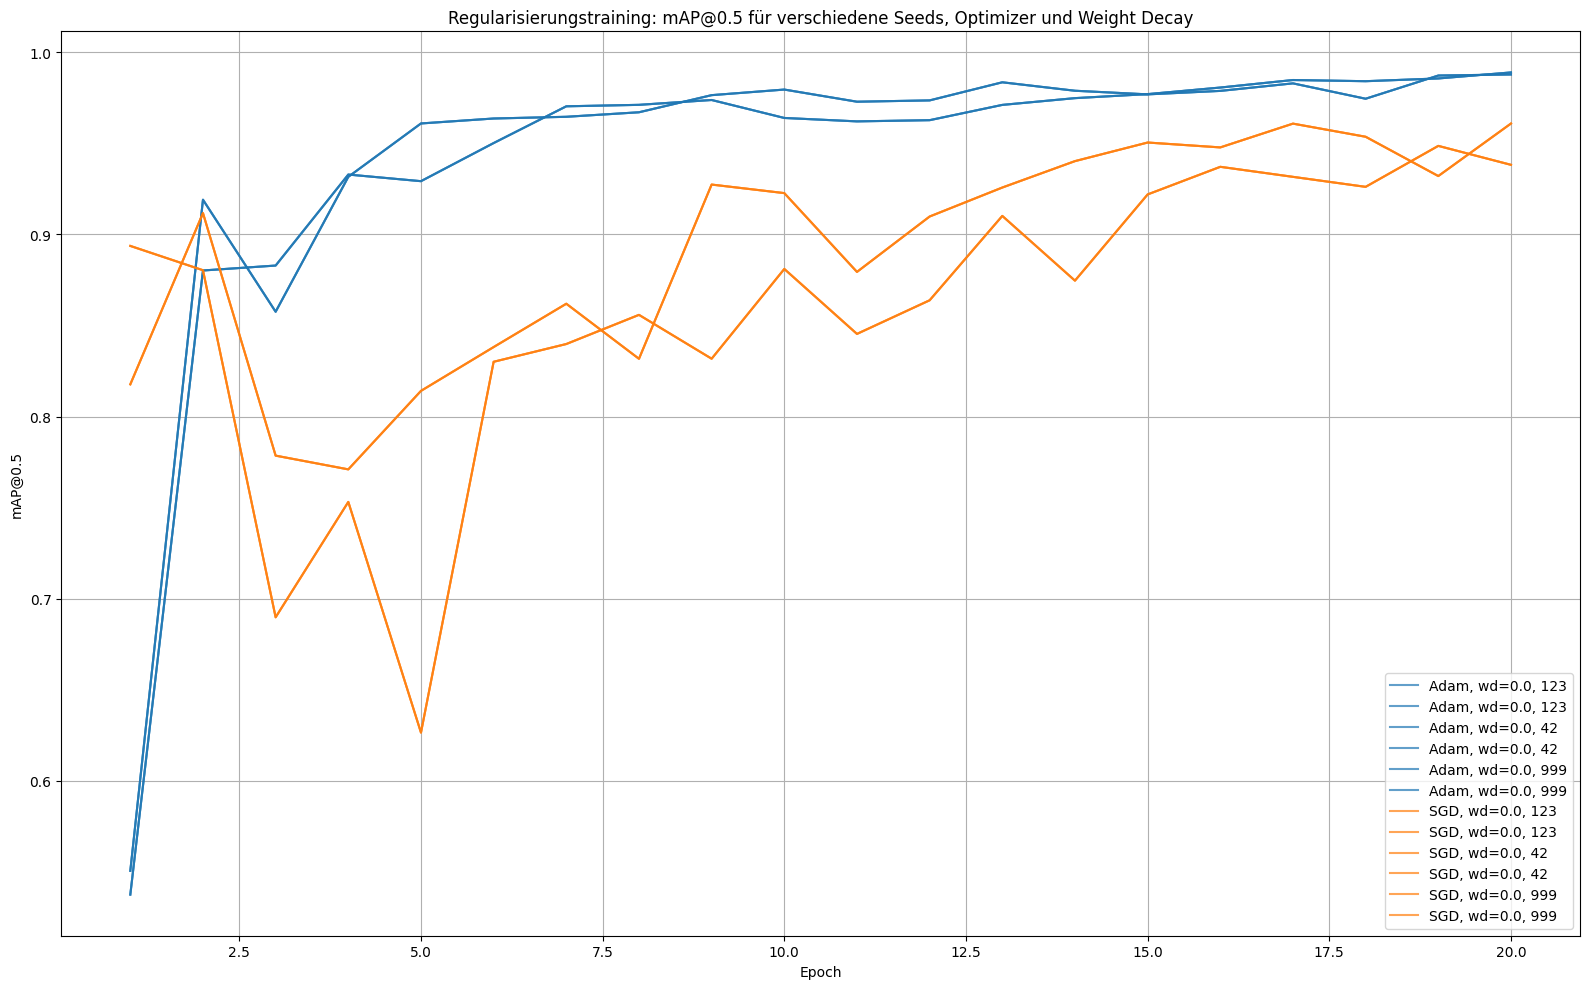

In [16]:
%matplotlib inline

# Finde alle Regularisierungs-Runs (Adam & SGD, verschiedene Seeds und Weight Decays)
reg_csvs = glob.glob('./runs/detect/regularise_*/results.csv', recursive=True)
print(f"Gefundene Regularisierungs-Runs: {reg_csvs}")

# Plot-Konfiguration
plt.figure(figsize=(16, 10))

# Farben und Marker für bessere Unterscheidung
color_map = {
    'adam': 'tab:blue',
    'sgd': 'tab:orange'
}
linestyle_map = {
    0.0: '-',
    0.01: '--'
}

# Plotte mAP@0.5 für alle Runs
for csv_path in reg_csvs:
    df = pd.read_csv(csv_path)
    run_dir = os.path.dirname(csv_path)
    run_name = os.path.basename(run_dir)
    # Extrahiere Optimizer und Weight Decay aus dem Run-Namen
    if 'adam' in run_name:
        color = color_map['adam']
    else:
        color = color_map['sgd']
    if '_wd0.000' in run_name or '_wd0.0' in run_name:
        ls = linestyle_map[0.0]
        wd_label = 'wd=0.0'
    else:
        ls = linestyle_map[0.01]
        wd_label = 'wd=0.01'
    label = f"{'Adam' if 'adam' in run_name else 'SGD'}, {wd_label}, {run_name.split('_seed')[1].split('_')[0]}"
    if 'metrics/mAP50(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=label, color=color, linestyle=ls, alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Regularisierungstraining: mAP@0.5 für verschiedene Seeds, Optimizer und Weight Decay')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()